# Degenerations between Jordan spaces

First we define our costfunctional $f(P,Q)$ and $F(P)=\min_Q f(P,Q)$ for two bases $X$, $Y$ of two Jordan algebras $J_1$ and $J_2$.

In [1]:
#necessary libraries to solve optimization problem efficiently
using LinearAlgebra, TensorOperations, Optim
#library to save data
using DelimitedFiles
#library for plots and graphs
using Plots, GraphRecipes

In [2]:
#cost function
function f(P,Q,X,Y)
    m=size(X)[3]
    n=size(X)[1]
    @tensor begin
        y[a,b,c]:=X[a1,b1,c1]*P[a,a1]*P[b,b1]*Q[c,c1]
    end
    return norm(y-Y)^2,y
end

# we can compute the optimal Q by solving a linear system of equations
function optimalQ(P,X,Y)
    n=size(X)[1]
    m=size(X)[3]
    Idm=Diagonal(ones(m))
    @tensor begin
        x[a1,a2,b1]:=P[a1,a3]*P[a2,a4]*X[a3,a4,b1]
    end
    x2=conj(x)
    @tensor begin
        Op[b4,b3,b1,b2]:=x2[a1,a3,b3]*x[a1,a3,b2]*Idm[b1,b4]
        rhs[b1,b3]:=x2[a1,a3,b3]*Y[a1,a3,b1]
    end
    Op=reshape(Op,m*m,m*m)
    rhs=reshape(rhs,m*m)
    
    b=qr(Op, Val(true)) \ rhs
    return reshape(b,m,m)
    
end

#We can define the cost functional without Q
function F(P,X,Y)
    m=size(X)[3]
    n=size(X)[1]
    Q=optimalQ(P,X,Y)
    @tensor begin
        y[a,b,c]:=X[a1,b1,c1]*P[a,a1]*P[b,b1]*Q[c,c1]
    end
    return norm(y-Y)^2,y
end

F (generic function with 1 method)

We need the gradient of $f$ and $F$ for efficient optimization methods. If $F$ is differentiable, the gradient is $\nabla F(P)=\nabla f(P,Q)$, where $Q$ is the minimizer in $\min_Q f(P,Q)$.

In [3]:
function gradf(P,Q,X,Y)
    m=size(X)[3]
    n=size(X)[1]
    #we need res=B(AXA)-Y for everything
    res=f(P,Q,X,Y)[2]-Y
    
    @tensor begin
        #grad with respect to A
        gradA[a,b] := 2*res[a,d,e]*conj(X[b,f,g]*P[d,f]*Q[e,g])
        #grad with respect to B
        gradB[a,b] := res[d,e,a]*conj(X[f,g,b]*P[d,f]*P[e,g])
    end
    return gradA,gradB
end

function gradF(P,X,Y)
    Q=optimalQ(P,X,Y)
    return gradf(P,Q,X,Y)[1]
end

gradF (generic function with 1 method)

Now we define optimization methods. We will use $F$ since having less variables makes this optimization problem easier to handle.

In [4]:
#if we have a candidate P
function finddegeneration(P,X,Y)
    #first define the specific function to be optimized
    F1(P)=F(P,X,Y)[1]
    #next the gradient
    function g!(G,P)
        G[:,:]=gradF(P,X,Y)
    end
    #we use the BFGS method
    return optimize(F1,g!, P,LBFGS())
end


#if no candidate is known
function finddegeneration(X,Y)
    n=size(X)[1]
    P=randn(n,n)+im*randn(n,n)
    return finddegeneration(P,X,Y)
end

finddegeneration (generic function with 2 methods)

Next we need to provide the bases of the Jordan Algebras.

In [5]:
#we need the antidiagonal a lot 
function JMatrix(n)
    J=zeros(n,n)
    for i in 1:n
        J[i,n+1-i]=1
    end
    return J
end

function JMatrix(n,k)
    J=zeros(n,n)
    for i in 1:n-k
        J[i,n+1-k-i]=1
    end
    return J
end

#helpful function for degenerations of diagonal type
function Atype(d,k)
    n=d*k
    X=zeros(n,n,d)
    for i in 1:d
        X[:,:,i]=kron(Diagonal(ones(k)),JMatrix(d,i-1))
    end
    return X
end

#we start with Jordan pencils

#Diagonal type
function JPA1(k1,k2)
    n=k1+2k2
    X=zeros(n,n,2)
    X[1:k1+k2,1:k1+k2,1]=Diagonal(ones(k1+k2))
    X[1+k1+k2:k1+2k2,1+k1+k2:k1+2k2,2]=Diagonal(ones(k2))
    return X
end
#degenerate type
function JPA2(k1,k2)
    n=k1+2k2
    X=zeros(n,n,2)
    X[1:2k2,1:2k2,:]=Atype(2,k2)
    X[2k2+1:n,2k2+1:n,1]=Diagonal(ones(k1))
    return X
end

#next Jordan nets

#Diagonal type
function JNA1(k1,k2,k3)
    n=k1+2k2+3k3
    r=k1+k2+k3
    X=zeros(n,n,3)
    X[r+1:n,r+1:n,2:3]=JPA1(k2,k3)
    X[1:r,1:r,1]=Diagonal(ones(r))
    return X
end
#Degenerations
function JNA2(r,k1,k2)
    n=r+k1+2k2
    X=zeros(n,n,3)
    X[1:r,1:r,1]=Diagonal(ones(r))
    X[r+1:n,r+1:n,2:3]=JPA2(k1,k2)
    return X
end
function JNA3(k1,k2,k3)
    n=k1+2k2+3k3
    X=zeros(n,n,3)
    X[1:3k3,1:3k3,:]=Atype(3,k3)   
    X[3k3+1:n,3k3+1:n,1:2]=JPA2(k1,k2)

    return X
end

#S^2 type

function JNB1(k)
    X=zeros(2k,2k,3)
    X[:,:,1]=kron([1 0; 0 0],Diagonal(ones(k)))
    X[:,:,2]=kron([0 0; 0 1],Diagonal(ones(k)))
    X[:,:,3]=kron([0 1; 1 0],Diagonal(ones(k)))
    
    return X
end
#Degeneration
function JNB2(k,l1,l2)
    n=l1+2l2
    X=zeros(n,n,3) 
    X[1:l2,1:l2,1]=JMatrix(l2)
    X[1+l2:2l2,1+l2:2l2,2]=JMatrix(l2)
    X[2l2+1:n,2l2+1:n,2]=Diagonal(ones(l1))
    X[1:k,l2+1:l2+k,3]=Diagonal(ones(k))
    X[l2+1:l2+k,1:k,3]=Diagonal(ones(k))
    return X
end

function JNC(n,typ)
    X=zeros(n,n,3)
    X[:,:,1]=JMatrix(n)
    if n==4 || n==5
        if typ==1
            X[1:2,1:2,2:3]=JPA1(0,1)
        else
            X[1:2,1:2,2:3]=JPA2(0,1)
        end
        
    else
        if typ==1
            X[1:2,1:2,2:3]=JPA1(0,1)
            X[3,3,2:3]=ones(2)
        elseif typ==2
            X[1:2,1:2,2:3]=JPA2(0,1)
            X[3,3,3]=1
        elseif typ==3
            X[1:3,1:3,2]=JMatrix(3)
            X[1:3,1:3,3]=JMatrix(3,1) 
            
        elseif typ==4
            X[1:3,1:3,2:3]=JPA1(1,1)
        elseif typ==5
            X[1:2,1:2,2:3]=JPA2(0,1)
            X[3,3,2]=1
        elseif typ==6
            X[1:3,1:3,2]=JMatrix(3)
            X[2,2,2]=0
            X[1:3,1:3,3]=JMatrix(3,1) 
        elseif typ==7
            X[1:2,1:2,2:3]=JPA1(0,1)
        else
            X[1:2,1:2,2:3]=JPA2(0,1)
        end
        
        
    end  
    
    
    return X
end

#Jordan webs

#Diagonal Type
function JWA1(k1,k2,k3,k4)
    n=k1+2k2+3k3+4k4
    n2=k1+k2+k3+k4
    X=zeros(n,n,4)
    X[n2+1:n,n2+1:n,2:4]=JNA1(k2,k3,k4)
    X[1:n2,1:n2,1]=Diagonal(ones(n2))
    return X
end

#degenerations
function JWA2(k1,k2,l1,l2)
    n1=k1+2k2
    n=n1+l1+2l2
    X=zeros(n,n,4)
    
    X[1:n1,1:n1,1:2]=JPA1(k1,k2)
    X[n1+1:n,n1+1:n,3:4]=JPA2(l1,l2)
    return X
end

function JWA3(k1,k2,l1,l2)
    n1=k1+2k2
    n=n1+l1+2l2
    X=zeros(n,n,4)
    
    X[1:n1,1:n1,1:2]=JPA2(k1,k2)
    X[n1+1:n,n1+1:n,3:4]=JPA2(l1,l2)
    return X
end

function JWA4(r,k1,k2,k3)
    n=r+k1+2k2+3k3
    X=zeros(n,n,4)
    X[1:r,1:r,1]=Diagonal(ones(r))
    X[r+1:n,1+r:n,2:4]=JNA3(k1,k2,k3)
    return X
end

function JWA5(k1,k2,k3,k4)
    n=k1+2k2+3k3+4k4
    X=zeros(n,n,4)
    X[1:4k4,1:4k4,1:4]=Atype(4,k4)
    X[4k4+1:n,4k4+1:n,1:3]=JNA3(k1,k2,k3)
    return X
end

#other types

function JWB1(k1,k2)
    n=k1+2k2
    X=zeros(n,n,4)
    X[1:k1,1:k1,1]=Diagonal(ones(k1))
    X[k1+1:n,k1+1:n,2:4]=JNB1(k2)
    return X
end

function JWB2(r,k,l1,l2)
    n=r+l1+2l2
    X=zeros(n,n,4)
    X[1:r,1:r,1]=Diagonal(ones(r))
    X[r+1:n,r+1:n,2:4]=JNB2(k,l1,l2)
    return X
end

function JWC1(k)
    n=4k
    X=zeros(n,n,4)
    X[:,:,1:3]=JNB1(2k)
    X[1:2k,2k+1:4k,4]= kron(Diagonal(ones(k)),[0 1; -1 0])
    X[2k+1:4k,1:2k,4]=kron(Diagonal(ones(k)),[0 -1; 1 0])
    return X
end


function JWC2(m,k)
    n=2m
    X=zeros(n,n,4)
    X[:,:,1:3]=JNB2(k,0,m)
    X[1:2k,1+m:m+2k,3]=kron(Diagonal(ones(k)),[0 1; -1 0])
    X[1+m:m+2k,1:2k,3]=kron(Diagonal(ones(k)),[0 -1; 1 0])
    
    X[1:m,1+m:n,4]=JMatrix(m)
    X[1+m:n,1:m,4]=JMatrix(m)
    
    return X
end

function JWD(n,typ)
    X=zeros(n,n,4)
    if n==5
        X[2:5,2:5,1:3]=JNC(4,typ)
        X[1,1,4]=1
    end
    return X
end

function JWE1(n,typ)
    X=zeros(n,n,4)
    X[1,1,3]=1
    X[1:2,1:2,4]=[0 1; 1 0]
    X[1:3,1:3,1]=[0 0 1; 0 0 0; 1 0 0 ]
    X[2,2,2]=1
    
    if n==4
        if typ ==1
            X[4,4,1]=1
        else
            X[4,4,2]=1   
        end
    elseif n==5
        if typ ==1
            X[4,4,1]=1
            X[5,5,1]=1            
        elseif typ ==2
            X[4,4,1]=1
            X[5,5,2]=1
        else
            X[4,4,2]=1
            X[5,5,2]=1
        end
    end
    return X
end

function JWE2(n,typ)
    X=zeros(n,n,4)
    X[1,1,3]=1
    X[1,3,4]=1
    X[3,1,4]=1
    X[1:2,1:2,1]=[0 1; 1 0]
    X[3:4,3:4,2]=[0 1; 1 0]
    if n==5
        if typ==1
            X[5,5,1]=1
        else
            X[5,5,2]=1 
        end
    end
    return X
end

function JWE2(n)
    return JWE2(n,1)
end

function JWE3(n,typ)
    X=zeros(n,n,4)
    X[1:3,1:3,1]=JMatrix(3)
    X[1:2,1:2,2]=JMatrix(2)
    X[1,1,3]=1
    if typ==1
        X[4:n,4:n,1]=Diagonal(ones(n-3))
        X[1,4,4]=1
        X[4,1,4]=1
    else
        X[1,5,4]=1
        X[5,1,4]=1
        X[4:5,4:5,1:2]=JPA2(0,1)
    end
    return X 
    
end

function JWE3(n)
    return JWE3(n,1)
end

function JWE4(n,typ)
    X=zeros(n,n,4)
    X[1:3,1:3,1]=JMatrix(3)
    X[1:2,1:2,2]=JMatrix(2)
    X[1,1,3]=1
    X[4:5,4:5,1]=JMatrix(2)
    if typ==1
        X[4,4,4]=1
    else
        X[1,4,4]=1
        X[4,1,4]=1
    end
    return X
end
function JWF(n)
    X=zeros(n,n,4)
    X[:,:,1]=JMatrix(n)
    X[1:2,1:2,2:4]=JNB1(1)
    return X
end

JWF (generic function with 1 method)

For more stability of the results we will transform the bases into orthonormal bases (w.r.t. the inner product $\langle A,B \rangle= \mathrm{tr} (AB)$).

In [6]:
function ONB(X)
    n=size(X)[1]
    m=size(X)[3]
    result=zeros(n,n,m)
    
    for i in 1:m
        tmp=X[:,:,i]
        for j in 1:i-1
            tmp-=tr(tmp*result[:,:,j])*result[:,:,j]
        end
        result[:,:,i]=tmp/norm(tmp)
    end
    
    return result
end

ONB (generic function with 1 method)

We collect the bases for the orbits of Jordan Algebras in $\mathbb{S}^n$ for $n=5,6,7$.


In [7]:
#Jordan nets in S^5
JordanNetsS5=ONB.([
    #codim 16
    JNA1(0,1,1),
    #codim 17
    JNA1(2,0,1),JNA2(1,0,2),JNA2(2,1,1),
    #codim 18
    JNA2(3,0,1),JNA2(1,2,1),JNA3(0,1,1),JNB2(1,1,2),
    #codim 19
    JNA3(2,0,1),JNC(5,1),
    #codim 20
    JNC(5,2)
]);

In [8]:
#Jordan nets in S^6
JordanNetsS6=ONB.([
        #codim 24
        JNA1(0,0,2),
        #codim 25
        JNA1(1,1,1),JNA2(2,0,2),JNC(6,1),JNB1(3),        
        #codim 26
        JNA2(3,1,1),JNA2(1,1,2),JNA2(2,2,1),JNA3(0,0,2),JNC(6,2),JNB2(1,0,3),
        #codim 27
        JNA1(3,0,1),JNA3(1,1,1),JNC(6,4),JNC(6,3),JNB2(1,2,2),
        #codim 28
        JNA2(4,0,1),JNA2(1,3,1),JNC(6,5),
        #codim 29
        JNA3(3,0,1),JNC(6,7),JNC(6,6),
        #codim 30        
        JNC(6,8)
]);

In [9]:
#Jordan nets in S^7
JordanNetsS7=ONB.([
        #codim 34
        JNA1(1,0,2),
        #codim 35
        JNA2(2,1,2), JNA2(3,0,2), JNA1(0,2,1),
        #codim 36
        JNB2(1,1,3),JNC(7,1),JNA3(1,0,2),JNA2(3,2,1),JNA1(2,1,1),JNA2(1,0,3),
        #codim 37
        JNC(7,2),JNA2(2,3,1),JNA2(1,2,2),JNA3(0,2,1),JNA2(4,1,1),
        #codim 38
        JNB2(1,3,2),JNC(7,3),JNC(7,4),JNA3(2,1,1),
        #codim 39
        JNC(7,5),JNA1(4,0,1),
        #codim 40
        JNC(7,6),JNA2(1,4,1),JNA2(5,0,1),
        #codim 41
        JNC(7,7),JNA3(4,0,1),
        #codim 42
        JNC(7,8)
]);

In [10]:
#Jordan webs in S^4
JordanWebsS4=ONB.([
        #codim 12
        JWA1(0,0,0,1),
        #codim 13
        JWA2(0,1,0,1),
        #codim 14
        JWE1(4,2), JWA3(0,1,0,1), JWA4(1,0,0,1), JWB1(2,1),
        #codim 15
        JWE2(4), JWA5(0,0,0,1), JWE1(4,1),
        #codim 16
        JWE3(4), JWC1(1),
        #codim 17  
        JWF(4)
]);

In [11]:
#Jordan webs in S^5
JordanWebsS5=ONB.([
         #codim 24
        JWA1(1,0,0,1),
         #codim 25
        JWA2(1,1,0,1),JWA2(0,1,1,1), JWE3(5,2), JWB1(1,2),
         #codim 26
        JWE1(5,3),JWA4(2,0,0,1), JWA4(1,1,0,1),JWA3(1,1,0,1),JWD(5,1),JWB2(1,1,0,2),JWE1(5,2),
         #codim 27
        JWB1(3,1),JWE2(5,2),JWA5(1,0,0,1),JWE4(5,1),JWD(5,2),JWE2(5,1),
         #codim 28
        JWE1(5,1),JWE3(5,1),
         #codim 29
        JWE4(5,2),
         #codim 30
        JWF(5)
]);

We would like to find all degenerations. Since there are many local minima, we will need multiple tries for some of the methods.

In [12]:
function  findminimum(X,Y,tries)
    n=size(X)[1]
    iterator=0
    error=100.
    P=0
    #first define the specific function to be optimized
    F1(P)=F(P,X,Y)[1]
    #next the gradient
    function g!(G,P)
        G[:,:]=gradF(P,X,Y)
    end
    
    while error>1e-6 && iterator<tries
        P_0=randn(n,n)+im*randn(n,n)
        iterator+=1
        #we use the BFGS method
        result=optimize(F1,g!, P_0,LBFGS())
        if error>result.minimum
            error=result.minimum
            P=result.minimizer
        end
    end
    return error,P,iterator
end

function finddistances(Data,tries)
    L=length(Data)
    n=size(Data[1])[1]
    dist=zeros(L,L)
    Ps=im*zeros(L,L,n,n)
    
    #first run
    for i in 1:L
        for j in 1:L
            X=Data[i]
            Y=Data[j]
            @time begin
            d,P,iterator=findminimum(X,Y,tries)
            end
            dist[i,j]=d
            Ps[i,j,:,:]=P
            println("distance squared from orbit of $i to $j is at most $d. $iterator tries ")
        end
        println()
    end
    
    println("first run done")
    println()
    println("second run")
    revisedistances!(Data,dist,Ps)
    recheckdegenerations!(Data,dist,Ps)
    println("third run")
    revisedistances!(Data,dist,Ps)
    recheckdegenerations!(Data,dist,Ps)
    #second run to check
    
    
    return dist,Ps
end

function distances(Data,Ps)
    L=length(Data)
    dist=zeros(L,L)
    for i in 1:L
        for j in 1:L
            X=Data[i]
            Y=Data[j]
            P_0=Ps[i,j,:,:]
            result=finddegeneration(P_0,X,Y)
            dist[i,j]=result.minimum
        end
    end
    return dist
end


function revisedistances!(Data,dist,Ps)
    L=length(Data)
    for i in 1:L
        for j in 1:L
            d=dist[i,j]
            for k in 1:L
                if d>dist[i,k]+dist[k,j]
                    println("distance squared from orbit of $i to $j will be revised since for $i $k $j: $(dist[i,k])+$(dist[k,j])<$d")
                    P_0=Ps[k,j,:,:]*Ps[i,k,:,:]
                    X=Data[i]
                    Y=Data[j]
                    result=finddegeneration(P_0,X,Y)
                    if result.minimum<d
                        d=result.minimum
                        dist[i,j]=d
                        Ps[i,j,:,:]=result.minimizer
                       
                    end
                    println("revised distance squared from orbit of $i to $j is at most $(dist[i,j]). ")
                end
            end
        end
        println()
    end
end

function recheckdegenerations!(Data,dist,Ps)
    #make values smaller
    L=length(Data)
    for i in 1:L
        for j in 1:L
            d=dist[i,j]
            X=Data[i]
            Y=Data[j]
            
            n=size(X)[1]
            P_1=randn(n,n)+im*randn(n,n)
            result=finddegeneration(P_1,X,Y)
            if result.minimum<d
                d=result.minimum
                
                Ps[i,j,:,:]=result.minimizer
                println("rechecked new distance squared from orbit of $i to $j is at most $d old is $(dist[i,j]). ")
                dist[i,j]=d    
            end
            P_0=Ps[i,j,:,:]
            result=finddegeneration(P_0,X,Y)
            
            if result.minimum<d
                d=result.minimum
                
                Ps[i,j,:,:]=result.minimizer
                println("rechecked better distance squared from orbit of $i to $j is at most $d old is $(dist[i,j]). ")
                dist[i,j]=d      
            end
            
        end
    end
end

recheckdegenerations! (generic function with 1 method)

We can draw the Hasse Diagram from this data.

In [13]:
function datatograph1(D,digs)
    #step one: get connections
    n=size(D)[1]
    C=falses(n,n)
    for i in 1:n-1
        for j in i+1:n
             C[i,j]=(round(D[i,j],digits=digs)==0)
        end
    end
    L=C
    for i in 1:n-2
        for j in i+2:n
            if C[i,j]
                for k in i+1:j-1
                    if C[i,k]*C[k,j]
                        L[i,j]=false
                    end
                end
            end
        end
    end
    return graphplot(L,method=:tree,names=1:n,curves=false,  curvature_scalar=0,nodesize=0.2),L
end

function datatograph2(D,eps)
    n=size(D)[1]
    C=falses(n,n)
    for i in 1:n-1
        for j in i+1:n
            C[i,j]=(prod(D[i,:].<=D[j,:] .+eps))
        end
    end
    L=C
    for i in 1:n-2
        for j in i+2:n
            if C[i,j]
                for k in i+1:j-1
                    if C[i,k]*C[k,j]
                        L[i,j]=false
                    end
                end
            end
        end
    end
    return graphplot(L,method=:tree,names=1:n,curves=false, curvature_scalar=0,nodesize=0.2),L
end

datatograph2 (generic function with 1 method)

We calculate degenerations for nets in $\mathbb S^5$.

In [14]:
D5s,P5s=finddistances(JordanNetsS5,10)
#save P5s

open("JNS5Ps.csv", "w") do io
           writedlm(io,P5s)
end

 26.398130 seconds (85.78 M allocations: 4.252 GiB, 7.00% gc time)
distance squared from orbit of 1 to 1 is at most 1.04946056742185e-15. 5 tries 
  0.246583 seconds (965.27 k allocations: 443.435 MiB, 23.27% gc time)
distance squared from orbit of 1 to 2 is at most 0.3333333333348262. 10 tries 
  2.142754 seconds (8.05 M allocations: 3.610 GiB, 19.05% gc time)
distance squared from orbit of 1 to 3 is at most 2.8719773209312435e-11. 10 tries 
  0.483927 seconds (1.95 M allocations: 896.760 MiB, 20.57% gc time)
distance squared from orbit of 1 to 4 is at most 1.7338312218616424e-7. 1 tries 
  1.038463 seconds (3.58 M allocations: 1.604 GiB, 19.39% gc time)
distance squared from orbit of 1 to 5 is at most 0.33333333333334986. 10 tries 
  3.364081 seconds (11.79 M allocations: 5.287 GiB, 18.77% gc time)
distance squared from orbit of 1 to 6 is at most 5.290054047361649e-7. 6 tries 
  4.944623 seconds (20.71 M allocations: 9.292 GiB, 19.95% gc time)
distance squared from orbit of 1 to 7 is

  0.208379 seconds (863.72 k allocations: 396.750 MiB, 20.21% gc time)
distance squared from orbit of 6 to 2 is at most 0.3333333333333597. 10 tries 
  0.688932 seconds (2.70 M allocations: 1.212 GiB, 19.94% gc time)
distance squared from orbit of 6 to 3 is at most 0.5000000000001265. 10 tries 
  2.189474 seconds (8.58 M allocations: 3.850 GiB, 19.16% gc time)
distance squared from orbit of 6 to 4 is at most 0.3333333344513619. 10 tries 
  2.773182 seconds (11.04 M allocations: 4.955 GiB, 19.55% gc time)
distance squared from orbit of 6 to 5 is at most 0.33333333337064724. 10 tries 
  2.013753 seconds (8.24 M allocations: 3.697 GiB, 19.48% gc time)
distance squared from orbit of 6 to 6 is at most 2.792588878885411e-15. 5 tries 
  4.724014 seconds (18.30 M allocations: 8.208 GiB, 19.26% gc time)
distance squared from orbit of 6 to 7 is at most 0.3333390903421969. 10 tries 
  3.362916 seconds (13.08 M allocations: 5.868 GiB, 19.05% gc time)
distance squared from orbit of 6 to 8 is at mos

  0.232620 seconds (913.13 k allocations: 419.440 MiB, 19.54% gc time)
distance squared from orbit of 11 to 3 is at most 0.9405818748261785. 10 tries 
  0.344892 seconds (1.27 M allocations: 583.180 MiB, 19.68% gc time)
distance squared from orbit of 11 to 4 is at most 0.7777777777777866. 10 tries 
  1.952498 seconds (8.41 M allocations: 3.773 GiB, 19.34% gc time)
distance squared from orbit of 11 to 5 is at most 0.6666666666679468. 10 tries 
  0.181377 seconds (761.42 k allocations: 349.733 MiB, 23.25% gc time)
distance squared from orbit of 11 to 6 is at most 0.5000000000001739. 10 tries 
  0.162861 seconds (703.42 k allocations: 323.097 MiB, 18.15% gc time)
distance squared from orbit of 11 to 7 is at most 0.4373410500935862. 10 tries 
  0.794621 seconds (3.08 M allocations: 1.381 GiB, 19.60% gc time)
distance squared from orbit of 11 to 8 is at most 0.9791666666773512. 10 tries 
  0.289743 seconds (1.15 M allocations: 528.597 MiB, 20.47% gc time)
distance squared from orbit of 11 t

revised distance squared from orbit of 6 to 11 is at most 1.883535898820926e-5. 

distance squared from orbit of 7 to 1 will be revised since for 7 6 1: 0.25000003809337423+0.5000000000000079<0.8964466874169591
revised distance squared from orbit of 7 to 1 is at most 0.8964466874169591. 
distance squared from orbit of 7 to 2 will be revised since for 7 6 2: 0.25000003809337423+0.3333333333333597<0.6666668815427842
revised distance squared from orbit of 7 to 2 is at most 0.6666668815427842. 
distance squared from orbit of 7 to 3 will be revised since for 7 6 3: 0.25000003809337423+0.5000000000001265<0.7889293512350632
revised distance squared from orbit of 7 to 3 is at most 0.647367221920634. 
distance squared from orbit of 7 to 5 will be revised since for 7 9 5: 2.89027354185097e-7+0.33333333337770016<0.333495757441839
revised distance squared from orbit of 7 to 5 is at most 0.3333346726944179. 
distance squared from orbit of 7 to 11 will be revised since for 7 9 11: 2.89027354185097e-

rechecked better distance squared from orbit of 4 to 11 is at most 1.356177884516216e-7 old is 1.5747476736317377e-6. 
rechecked new distance squared from orbit of 5 to 1 is at most 0.8333333333337548 old is 0.8333333333339403. 
rechecked new distance squared from orbit of 5 to 5 is at most 7.093808094289403e-14 old is 1.0100014347826951e-13. 
rechecked better distance squared from orbit of 5 to 7 is at most 0.3333442723045014 old is 0.3333503506511936. 
rechecked better distance squared from orbit of 5 to 9 is at most 1.1184020005785028e-5 old is 4.5822572180310364e-5. 
rechecked better distance squared from orbit of 5 to 10 is at most 0.5000001036999986 old is 0.5000001965355123. 
rechecked better distance squared from orbit of 5 to 11 is at most 1.846254762822496e-7 old is 2.570230864539608e-7. 
rechecked new distance squared from orbit of 6 to 3 is at most 0.5000000000000582 old is 0.5000000000001265. 
rechecked better distance squared from orbit of 6 to 4 is at most 0.333333334430

revised distance squared from orbit of 3 to 11 is at most 6.285146133894997e-6. 

distance squared from orbit of 4 to 3 will be revised since for 4 1 3: 0.5000000000000192+2.8719773209312435e-11<0.5669872981078216
revised distance squared from orbit of 4 to 3 is at most 0.5669872981078216. 
distance squared from orbit of 4 to 9 will be revised since for 4 7 9: 1.264426807109839e-5+4.995526700699464e-8<2.0518654508177737e-5
revised distance squared from orbit of 4 to 9 is at most 2.0518654508177737e-5. 

distance squared from orbit of 5 to 1 will be revised since for 5 4 1: 0.33333333333335535+0.5000000000000192<0.8333333333337548
revised distance squared from orbit of 5 to 1 is at most 0.8333333333337548. 
distance squared from orbit of 5 to 3 will be revised since for 5 1 3: 0.8333333333337548+2.8719773209312435e-11<0.8672522771155353
revised distance squared from orbit of 5 to 3 is at most 0.8672522771155353. 
distance squared from orbit of 5 to 10 will be revised since for 5 2 10: 0

The following is the calculated Hasse Diagram for nets in $\mathbb{S}^5$.

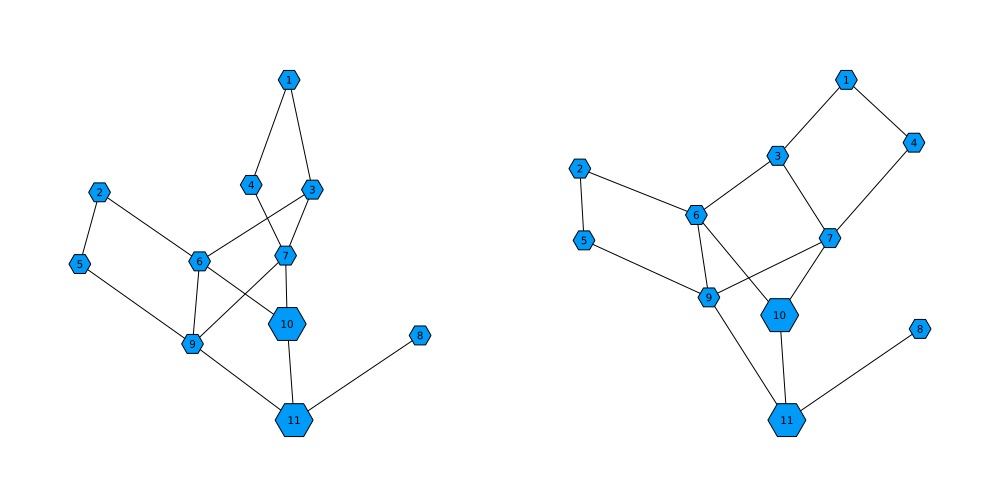

In [15]:
plot(datatograph1(D5s,3)[1],datatograph2(D5s,0.01)[1],size=(1000,500))

We calculate degenerations for nets in $\mathbb S^6$.

In [16]:
D6s,P6s=finddistances(JordanNetsS6,10)
#save P6s

open("JNS6Ps.csv", "w") do io
           writedlm(io,P6s)
end

  0.584379 seconds (2.14 M allocations: 995.454 MiB, 23.83% gc time)
distance squared from orbit of 1 to 1 is at most 3.009921880722286e-13. 2 tries 
  1.385249 seconds (4.99 M allocations: 2.266 GiB, 21.37% gc time)
distance squared from orbit of 1 to 2 is at most 0.3333333333368205. 10 tries 
  0.193149 seconds (705.71 k allocations: 328.244 MiB, 21.73% gc time)
distance squared from orbit of 1 to 3 is at most 4.690370893413399e-11. 1 tries 
  2.392815 seconds (8.62 M allocations: 3.920 GiB, 21.37% gc time)
distance squared from orbit of 1 to 4 is at most 2.417804599474063e-9. 4 tries 
  3.331407 seconds (12.43 M allocations: 5.644 GiB, 21.78% gc time)
distance squared from orbit of 1 to 5 is at most 1.0000000000001528. 10 tries 
  5.095222 seconds (18.55 M allocations: 8.424 GiB, 21.50% gc time)
distance squared from orbit of 1 to 6 is at most 0.33333333762932654. 10 tries 
  5.469185 seconds (20.54 M allocations: 9.326 GiB, 21.76% gc time)
distance squared from orbit of 1 to 7 is a

  3.169597 seconds (11.86 M allocations: 5.386 GiB, 20.76% gc time)
distance squared from orbit of 3 to 11 is at most 0.6666666666667316. 10 tries 
  0.827074 seconds (3.23 M allocations: 1.466 GiB, 20.59% gc time)
distance squared from orbit of 3 to 12 is at most 0.5000000000001374. 10 tries 
  5.393714 seconds (20.46 M allocations: 9.293 GiB, 20.75% gc time)
distance squared from orbit of 3 to 13 is at most 1.5393051702464955e-5. 10 tries 
  2.178327 seconds (7.08 M allocations: 3.215 GiB, 21.20% gc time)
distance squared from orbit of 3 to 14 is at most 9.741665047919257e-6. 10 tries 
  5.383987 seconds (19.74 M allocations: 8.963 GiB, 20.58% gc time)
distance squared from orbit of 3 to 15 is at most 0.0003394721789445783. 10 tries 
  2.830935 seconds (9.79 M allocations: 4.445 GiB, 20.57% gc time)
distance squared from orbit of 3 to 16 is at most 0.5000000000007083. 10 tries 
  2.807508 seconds (10.06 M allocations: 4.569 GiB, 20.62% gc time)
distance squared from orbit of 3 to 17 

  0.548950 seconds (1.99 M allocations: 925.147 MiB, 19.77% gc time)
distance squared from orbit of 5 to 21 is at most 6.063847859563902e-7. 1 tries 
  5.632015 seconds (20.70 M allocations: 9.399 GiB, 20.09% gc time)
distance squared from orbit of 5 to 22 is at most 0.4328163439834386. 10 tries 
  5.744495 seconds (20.63 M allocations: 9.368 GiB, 20.00% gc time)
distance squared from orbit of 5 to 23 is at most 0.0005434283932713884. 10 tries 

  0.465060 seconds (1.83 M allocations: 849.400 MiB, 20.23% gc time)
distance squared from orbit of 6 to 1 is at most 0.8964466094260284. 10 tries 
  0.308255 seconds (1.25 M allocations: 579.785 MiB, 19.12% gc time)
distance squared from orbit of 6 to 2 is at most 0.5000000000001337. 10 tries 
  1.855133 seconds (7.19 M allocations: 3.268 GiB, 20.55% gc time)
distance squared from orbit of 6 to 3 is at most 0.6473671297286967. 10 tries 
  4.877498 seconds (18.54 M allocations: 8.420 GiB, 20.11% gc time)
distance squared from orbit of 6 to 4 is

  0.487267 seconds (2.01 M allocations: 935.520 MiB, 19.27% gc time)
distance squared from orbit of 8 to 8 is at most 3.1292942660853836e-13. 2 tries 
  0.320774 seconds (1.25 M allocations: 582.787 MiB, 21.80% gc time)
distance squared from orbit of 8 to 9 is at most 0.5629971770848345. 10 tries 
  4.200895 seconds (17.07 M allocations: 7.754 GiB, 20.24% gc time)
distance squared from orbit of 8 to 10 is at most 0.3333333505519895. 10 tries 
  1.365429 seconds (5.56 M allocations: 2.524 GiB, 20.61% gc time)
distance squared from orbit of 8 to 11 is at most 0.8156829682957577. 10 tries 
  0.288858 seconds (1.17 M allocations: 543.175 MiB, 20.75% gc time)
distance squared from orbit of 8 to 12 is at most 0.5000000000051011. 10 tries 
  5.232430 seconds (20.19 M allocations: 9.166 GiB, 20.02% gc time)
distance squared from orbit of 8 to 13 is at most 5.615286448731454e-5. 10 tries 
  0.596223 seconds (2.09 M allocations: 972.011 MiB, 20.60% gc time)
distance squared from orbit of 8 to 14

  5.698430 seconds (20.54 M allocations: 9.326 GiB, 19.24% gc time)
distance squared from orbit of 10 to 18 is at most 0.20000000578967755. 10 tries 
  5.506247 seconds (20.81 M allocations: 9.452 GiB, 19.60% gc time)
distance squared from orbit of 10 to 19 is at most 1.1911716501194083e-6. 10 tries 
  5.690875 seconds (20.89 M allocations: 9.489 GiB, 19.61% gc time)
distance squared from orbit of 10 to 20 is at most 0.1666667696809195. 10 tries 
  0.578401 seconds (2.00 M allocations: 928.471 MiB, 19.62% gc time)
distance squared from orbit of 10 to 21 is at most 2.7384698575935387e-8. 1 tries 
  5.471962 seconds (20.97 M allocations: 9.523 GiB, 19.71% gc time)
distance squared from orbit of 10 to 22 is at most 3.461059854922562e-5. 10 tries 
  5.290717 seconds (20.72 M allocations: 9.408 GiB, 19.83% gc time)
distance squared from orbit of 10 to 23 is at most 6.752967172356981e-6. 10 tries 

  0.785154 seconds (3.10 M allocations: 1.407 GiB, 19.61% gc time)
distance squared from orbit

  1.680273 seconds (6.87 M allocations: 3.120 GiB, 19.59% gc time)
distance squared from orbit of 13 to 5 is at most 1.0000003937107163. 10 tries 
  3.177001 seconds (11.77 M allocations: 5.347 GiB, 19.38% gc time)
distance squared from orbit of 13 to 6 is at most 0.3334250465377652. 10 tries 
  3.599041 seconds (13.10 M allocations: 5.949 GiB, 19.14% gc time)
distance squared from orbit of 13 to 7 is at most 0.6301240222027034. 10 tries 
  2.605209 seconds (10.52 M allocations: 4.779 GiB, 19.48% gc time)
distance squared from orbit of 13 to 8 is at most 0.48732272822881634. 10 tries 
  0.758494 seconds (3.04 M allocations: 1.383 GiB, 19.60% gc time)
distance squared from orbit of 13 to 9 is at most 0.6623028564489924. 10 tries 
  5.639878 seconds (20.80 M allocations: 9.447 GiB, 19.21% gc time)
distance squared from orbit of 13 to 10 is at most 0.4587344996108677. 10 tries 
  4.787388 seconds (18.92 M allocations: 8.593 GiB, 19.41% gc time)
distance squared from orbit of 13 to 11 is a

  0.124777 seconds (433.05 k allocations: 201.461 MiB, 24.71% gc time)
distance squared from orbit of 15 to 15 is at most 1.4978729795838508e-13. 3 tries 
  3.926978 seconds (14.91 M allocations: 6.775 GiB, 19.38% gc time)
distance squared from orbit of 15 to 16 is at most 0.5000000076121053. 10 tries 
  1.327856 seconds (5.12 M allocations: 2.323 GiB, 19.35% gc time)
distance squared from orbit of 15 to 17 is at most 0.500009521425657. 10 tries 
  5.594357 seconds (19.96 M allocations: 9.064 GiB, 19.67% gc time)
distance squared from orbit of 15 to 18 is at most 0.20000000669850865. 10 tries 
  5.109274 seconds (20.89 M allocations: 9.489 GiB, 19.74% gc time)
distance squared from orbit of 15 to 19 is at most 9.076673087669767e-6. 10 tries 
  5.384284 seconds (20.88 M allocations: 9.483 GiB, 19.27% gc time)
distance squared from orbit of 15 to 20 is at most 0.16666668735135218. 10 tries 
  1.084022 seconds (4.19 M allocations: 1.903 GiB, 19.04% gc time)
distance squared from orbit of 

  0.232095 seconds (789.98 k allocations: 367.426 MiB, 19.20% gc time)
distance squared from orbit of 18 to 2 is at most 0.5000000000000184. 10 tries 
  2.137594 seconds (7.94 M allocations: 3.606 GiB, 18.99% gc time)
distance squared from orbit of 18 to 3 is at most 1.0000000000111782. 10 tries 
  5.357869 seconds (20.89 M allocations: 9.485 GiB, 19.51% gc time)
distance squared from orbit of 18 to 4 is at most 0.6666671269851395. 10 tries 
  3.036883 seconds (12.38 M allocations: 5.620 GiB, 19.96% gc time)
distance squared from orbit of 18 to 5 is at most 1.333333333348542. 10 tries 
  2.308765 seconds (7.79 M allocations: 3.541 GiB, 19.51% gc time)
distance squared from orbit of 18 to 6 is at most 0.3333333347333823. 10 tries 
  0.513720 seconds (2.09 M allocations: 970.250 MiB, 19.15% gc time)
distance squared from orbit of 18 to 7 is at most 0.5000000000001745. 10 tries 
  2.124533 seconds (9.17 M allocations: 4.163 GiB, 19.90% gc time)
distance squared from orbit of 18 to 8 is at

  2.057905 seconds (8.41 M allocations: 3.821 GiB, 19.34% gc time)
distance squared from orbit of 20 to 12 is at most 0.7500000000636526. 10 tries 
  0.698351 seconds (2.95 M allocations: 1.339 GiB, 19.34% gc time)
distance squared from orbit of 20 to 13 is at most 0.33333333333341597. 10 tries 
  1.721890 seconds (7.24 M allocations: 3.288 GiB, 19.70% gc time)
distance squared from orbit of 20 to 14 is at most 0.6666666666666987. 10 tries 
  4.925728 seconds (20.88 M allocations: 9.485 GiB, 19.56% gc time)
distance squared from orbit of 20 to 15 is at most 0.6666671685829043. 10 tries 
  3.185533 seconds (12.54 M allocations: 5.694 GiB, 19.48% gc time)
distance squared from orbit of 20 to 16 is at most 0.8750047644817286. 10 tries 
  3.646108 seconds (14.27 M allocations: 6.480 GiB, 19.66% gc time)
distance squared from orbit of 20 to 17 is at most 0.2500000000111853. 10 tries 
  3.192266 seconds (12.99 M allocations: 5.899 GiB, 19.56% gc time)
distance squared from orbit of 20 to 18 

  0.992592 seconds (4.23 M allocations: 1.922 GiB, 18.80% gc time)
distance squared from orbit of 22 to 23 is at most 4.383850250277859e-7. 3 tries 

  0.212077 seconds (882.35 k allocations: 410.371 MiB, 22.75% gc time)
distance squared from orbit of 23 to 1 is at most 1.000000000000007. 10 tries 
  0.613270 seconds (2.66 M allocations: 1.206 GiB, 19.16% gc time)
distance squared from orbit of 23 to 2 is at most 0.9166666666666813. 10 tries 
  0.325164 seconds (1.34 M allocations: 623.744 MiB, 18.79% gc time)
distance squared from orbit of 23 to 3 is at most 1.0000000000000355. 10 tries 
  0.294577 seconds (1.02 M allocations: 474.281 MiB, 19.06% gc time)
distance squared from orbit of 23 to 4 is at most 0.8333333333333628. 10 tries 
  0.224782 seconds (775.68 k allocations: 360.769 MiB, 20.45% gc time)
distance squared from orbit of 23 to 5 is at most 1.3333333333333757. 10 tries 
  1.378025 seconds (5.15 M allocations: 2.338 GiB, 18.93% gc time)
distance squared from orbit of 23 to 

revised distance squared from orbit of 1 to 19 is at most 8.704186067339618e-6. 
distance squared from orbit of 1 to 20 will be revised since for 1 3 20: 4.690370893413399e-11+0.00013501291486533946<0.0006060750859037013
revised distance squared from orbit of 1 to 20 is at most 8.23732357805451e-5. 
distance squared from orbit of 1 to 20 will be revised since for 1 9 20: 2.3346096191740106e-8+2.2014626825724582e-5<8.23732357805451e-5
revised distance squared from orbit of 1 to 20 is at most 7.651276419173611e-5. 
distance squared from orbit of 1 to 20 will be revised since for 1 13 20: 1.4084974200003334e-5+2.3173178116386578e-7<7.651276419173611e-5
revised distance squared from orbit of 1 to 20 is at most 7.651276419173611e-5. 
distance squared from orbit of 1 to 21 will be revised since for 1 4 21: 2.417804599474063e-9+7.862249340628232e-8<2.1416435886041514e-6
revised distance squared from orbit of 1 to 21 is at most 2.1416435886041514e-6. 
distance squared from orbit of 1 to 21 wil

revised distance squared from orbit of 3 to 17 is at most 0.250829212798954. 
distance squared from orbit of 3 to 17 will be revised since for 3 13 17: 4.369592260257876e-6+0.25012919239061054<0.250829212798954
revised distance squared from orbit of 3 to 17 is at most 0.250829212798954. 
distance squared from orbit of 3 to 17 will be revised since for 3 20 17: 0.00013501291486533946+0.2500000000111853<0.250829212798954
revised distance squared from orbit of 3 to 17 is at most 0.250829212798954. 
distance squared from orbit of 3 to 18 will be revised since for 3 8 18: 3.512082237424113e-10+0.20000000000025955<0.20000000051971098
revised distance squared from orbit of 3 to 18 is at most 0.20000000007983487. 
distance squared from orbit of 3 to 19 will be revised since for 3 9 19: 3.540142875819456e-8+0.0006769061504315461<0.0008553584625885956
revised distance squared from orbit of 3 to 19 is at most 0.0006684320681996045. 
distance squared from orbit of 3 to 19 will be revised since for

revised distance squared from orbit of 4 to 17 is at most 0.5000000002429835. 
distance squared from orbit of 4 to 20 will be revised since for 4 21 20: 7.862249340628232e-8+0.16666674130396128<0.1666670403088053
revised distance squared from orbit of 4 to 20 is at most 0.16666672867437932. 
distance squared from orbit of 4 to 21 will be revised since for 4 14 21: 7.480394254751195e-9+4.320819279485753e-8<7.862249340628232e-8
revised distance squared from orbit of 4 to 21 is at most 2.5702176668773888e-8. 
distance squared from orbit of 4 to 22 will be revised since for 4 10 22: 8.874732477996175e-7+3.461059854922562e-5<0.00011750332816364824
revised distance squared from orbit of 4 to 22 is at most 0.00011750332816364824. 
distance squared from orbit of 4 to 22 will be revised since for 4 15 22: 9.746637820280875e-7+3.724431103776777e-8<0.00011750332816364824
revised distance squared from orbit of 4 to 22 is at most 0.00011750332816364824. 
distance squared from orbit of 4 to 23 will 

revised distance squared from orbit of 5 to 23 is at most 2.284551496473722e-5. 
distance squared from orbit of 5 to 23 will be revised since for 5 21 23: 6.68250588192159e-8+8.01134703598284e-8<2.284551496473722e-5
revised distance squared from orbit of 5 to 23 is at most 3.6250002589513987e-6. 

distance squared from orbit of 6 to 1 will be revised since for 6 8 1: 0.25000000000065914+0.5000000000000103<0.8964466094260284
revised distance squared from orbit of 6 to 1 is at most 0.8964466094260284. 
distance squared from orbit of 6 to 7 will be revised since for 6 8 7: 0.25000000000065914+0.20000000000944446<0.5889020455429128
revised distance squared from orbit of 6 to 7 is at most 0.5889020455429128. 
distance squared from orbit of 6 to 9 will be revised since for 6 3 9: 0.6473671297286967+3.540142875819456e-8<0.6594466049442754
revised distance squared from orbit of 6 to 9 is at most 0.6594466049442754. 
distance squared from orbit of 6 to 14 will be revised since for 6 8 14: 0.250

revised distance squared from orbit of 8 to 21 is at most 1.1067870978388369e-7. 
distance squared from orbit of 8 to 22 will be revised since for 8 1 22: 0.5000000000000103+2.2283354733132625e-9<0.5000000070290742
revised distance squared from orbit of 8 to 22 is at most 0.5000000050783309. 
distance squared from orbit of 8 to 22 will be revised since for 8 4 22: 0.33333333711365387+0.00011750332816364824<0.5000000050783309
revised distance squared from orbit of 8 to 22 is at most 0.5000000050783309. 
distance squared from orbit of 8 to 22 will be revised since for 8 10 22: 0.3333333505519895+3.461059854922562e-5<0.5000000050783309
revised distance squared from orbit of 8 to 22 is at most 0.5000000050783309. 
distance squared from orbit of 8 to 22 will be revised since for 8 15 22: 0.3260768804057029+3.724431103776777e-8<0.5000000050783309
revised distance squared from orbit of 8 to 22 is at most 0.5000000050783309. 
distance squared from orbit of 8 to 23 will be revised since for 8 1

revised distance squared from orbit of 11 to 18 is at most 0.20000021231924314. 
distance squared from orbit of 11 to 20 will be revised since for 11 13 20: 0.16666666751136447+2.3173178116386578e-7<0.1666694267881068
revised distance squared from orbit of 11 to 20 is at most 0.1666680093536119. 
distance squared from orbit of 11 to 20 will be revised since for 11 14 20: 8.110006571315815e-9+0.1666679861468978<0.1666680093536119
revised distance squared from orbit of 11 to 20 is at most 0.1666680093536119. 
distance squared from orbit of 11 to 20 will be revised since for 11 19 20: 2.235975073395793e-8+0.16666666712385567<0.1666680093536119
revised distance squared from orbit of 11 to 20 is at most 0.1666666734862594. 
distance squared from orbit of 11 to 21 will be revised since for 11 14 21: 8.110006571315815e-9+4.320819279485753e-8<0.0006066717177827825
revised distance squared from orbit of 11 to 21 is at most 2.943373469431737e-7. 
distance squared from orbit of 11 to 22 will be r

revised distance squared from orbit of 12 to 23 is at most 4.4434345685845287e-7. 

distance squared from orbit of 13 to 1 will be revised since for 13 8 1: 0.48732272822881634+0.5000000000000103<1.0000000084890992
revised distance squared from orbit of 13 to 1 is at most 1.0000000084890992. 
distance squared from orbit of 13 to 6 will be revised since for 13 20 6: 2.3173178116386578e-7+0.3333333333583463<0.3334250465377652
revised distance squared from orbit of 13 to 6 is at most 0.333336025207328. 
distance squared from orbit of 13 to 12 will be revised since for 13 18 12: 0.20000006504030224+0.2500000000000241<0.5000724303719044
revised distance squared from orbit of 13 to 12 is at most 0.5000000165821706. 
distance squared from orbit of 13 to 14 will be revised since for 13 8 14: 0.48732272822881634+1.0759759688677524e-7<0.5000002585758326
revised distance squared from orbit of 13 to 14 is at most 0.5000002585758326. 
distance squared from orbit of 13 to 14 will be revised since fo

revised distance squared from orbit of 15 to 12 is at most 0.5000000023319603. 
distance squared from orbit of 15 to 13 will be revised since for 15 19 13: 9.076673087669767e-6+0.1666666666690595<0.16667632576674768
revised distance squared from orbit of 15 to 13 is at most 0.1666693713160223. 
distance squared from orbit of 15 to 14 will be revised since for 15 4 14: 0.3333333333333874+7.480394254751195e-9<0.41666666666676483
revised distance squared from orbit of 15 to 14 is at most 0.41666666666676483. 
distance squared from orbit of 15 to 14 will be revised since for 15 10 14: 0.208333333333367+7.21911927373819e-8<0.41666666666676483
revised distance squared from orbit of 15 to 14 is at most 0.41666666666676483. 
distance squared from orbit of 15 to 17 will be revised since for 15 12 17: 0.5000000023319603+6.84717979129814e-11<0.500009521425657
revised distance squared from orbit of 15 to 17 is at most 0.5000000008289308. 
distance squared from orbit of 15 to 17 will be revised sin

revised distance squared from orbit of 16 to 21 is at most 0.5000018935030033. 
distance squared from orbit of 16 to 21 will be revised since for 16 19 21: 0.33333333627921985+3.527290939866991e-7<0.5000018935030033
revised distance squared from orbit of 16 to 21 is at most 0.5000018935030033. 
distance squared from orbit of 16 to 21 will be revised since for 16 22 21: 9.576673164440107e-8+0.5000003698317023<0.5000018935030033
revised distance squared from orbit of 16 to 21 is at most 0.5000018935030033. 
distance squared from orbit of 16 to 21 will be revised since for 16 23 21: 5.193532522333365e-7+0.5000000000000612<0.5000018935030033
revised distance squared from orbit of 16 to 21 is at most 0.5000000290967263. 

distance squared from orbit of 17 to 3 will be revised since for 17 6 3: 0.33333333333336546+0.6473671297286967<1.0000000000030727
revised distance squared from orbit of 17 to 3 is at most 1.0000000000030727. 
distance squared from orbit of 17 to 3 will be revised since fo

revised distance squared from orbit of 18 to 9 is at most 1.0000000001150302. 
distance squared from orbit of 18 to 9 will be revised since for 18 13 9: 0.3333509871210373+0.6623028564489924<1.0000000001150302
revised distance squared from orbit of 18 to 9 is at most 1.0000000001150302. 
distance squared from orbit of 18 to 10 will be revised since for 18 20 10: 2.0986109542195287e-5+0.5000003607296684<0.5001622969736932
revised distance squared from orbit of 18 to 10 is at most 0.5000304906010737. 
distance squared from orbit of 18 to 10 will be revised since for 18 21 10: 8.212685945258158e-7+0.5000000378069758<0.5000304906010737
revised distance squared from orbit of 18 to 10 is at most 0.5000304906010737. 
distance squared from orbit of 18 to 14 will be revised since for 18 2 14: 0.5000000000000184+4.91061571098064e-9<0.5000000802253725
revised distance squared from orbit of 18 to 14 is at most 0.5000000802253725. 
distance squared from orbit of 18 to 15 will be revised since for 1

revised distance squared from orbit of 20 to 3 is at most 1.000000000000541. 
distance squared from orbit of 20 to 3 will be revised since for 20 8 3: 0.5000000000000204+0.5000000000000816<1.000000000000541
revised distance squared from orbit of 20 to 3 is at most 1.000000000000541. 
distance squared from orbit of 20 to 4 will be revised since for 20 6 4: 0.3333333333583463+0.5000000079279346<0.8333334606733845
revised distance squared from orbit of 20 to 4 is at most 0.8333334606733845. 
distance squared from orbit of 20 to 4 will be revised since for 20 8 4: 0.5000000000000204+0.33333333711365387<0.8333334606733845
revised distance squared from orbit of 20 to 4 is at most 0.8333334606733845. 
distance squared from orbit of 20 to 4 will be revised since for 20 10 4: 0.5000003607296684+0.16666666666675772<0.8333334606733845
revised distance squared from orbit of 20 to 4 is at most 0.8333334606733845. 
distance squared from orbit of 20 to 7 will be revised since for 20 8 7: 0.5000000000

revised distance squared from orbit of 21 to 22 is at most 0.8750000003968952. 

distance squared from orbit of 22 to 2 will be revised since for 22 8 2: 0.5000000046798673+0.33333333333340853<0.9166862508514282
revised distance squared from orbit of 22 to 2 is at most 0.9166862508514282. 
distance squared from orbit of 22 to 2 will be revised since for 22 23 2: 4.383850250277859e-7+0.9166666666666813<0.9166862508514282
revised distance squared from orbit of 22 to 2 is at most 0.9166666845367609. 
distance squared from orbit of 22 to 3 will be revised since for 22 10 3: 0.37500000000008465+0.5000000265958809<0.9370994204249926
revised distance squared from orbit of 22 to 3 is at most 0.9370994204249926. 
distance squared from orbit of 22 to 4 will be revised since for 22 10 4: 0.37500000000008465+0.16666666666675772<0.666666666666679
revised distance squared from orbit of 22 to 4 is at most 0.666666666666679. 
distance squared from orbit of 22 to 5 will be revised since for 22 15 5: 0.

revised distance squared from orbit of 23 to 12 is at most 0.9500000000002298. 
distance squared from orbit of 23 to 12 will be revised since for 23 18 12: 0.6000000016317334+0.2500000000000241<0.9500000000002298
revised distance squared from orbit of 23 to 12 is at most 0.9500000000002298. 
distance squared from orbit of 23 to 12 will be revised since for 23 19 12: 0.33333333333349163+0.5000000005201435<0.9500000000002298
revised distance squared from orbit of 23 to 12 is at most 0.9500000000002298. 
distance squared from orbit of 23 to 12 will be revised since for 23 20 12: 0.1666666666666969+0.7500000000636526<0.9500000000002298
revised distance squared from orbit of 23 to 12 is at most 0.9500000000002298. 
distance squared from orbit of 23 to 14 will be revised since for 23 8 14: 0.5000000000000896+1.0759759688677524e-7<0.6666666666667078
revised distance squared from orbit of 23 to 14 is at most 0.6666666666667078. 
distance squared from orbit of 23 to 14 will be revised since for

rechecked better distance squared from orbit of 4 to 8 is at most 0.5000000012027036 old is 0.5000000013227978. 
rechecked better distance squared from orbit of 4 to 9 is at most 0.5000357884371017 old is 0.5001088176366681. 
rechecked new distance squared from orbit of 4 to 10 is at most 9.920700983874293e-9 old is 8.874732477996175e-7. 
rechecked better distance squared from orbit of 4 to 10 is at most 2.634810415920225e-10 old is 9.920700983874293e-9. 
rechecked better distance squared from orbit of 4 to 11 is at most 0.6666844848224655 old is 0.6667130018751901. 
rechecked better distance squared from orbit of 4 to 12 is at most 0.5000000002947355 old is 0.5000000002947357. 
rechecked better distance squared from orbit of 4 to 13 is at most 0.16666680834971478 old is 0.16666691556824464. 
rechecked new distance squared from orbit of 4 to 14 is at most 4.116173384270994e-9 old is 7.480394254751195e-9. 
rechecked new distance squared from orbit of 4 to 15 is at most 4.392848491567675

rechecked better distance squared from orbit of 9 to 2 is at most 0.6667010429101614 old is 0.6667037927720919. 
rechecked new distance squared from orbit of 9 to 3 is at most 0.6324643726006665 old is 0.6324643726007304. 
rechecked better distance squared from orbit of 9 to 4 is at most 0.3333333353648525 old is 0.3333333353649726. 
rechecked better distance squared from orbit of 9 to 6 is at most 0.33336822786304715 old is 0.3333972179959877. 
rechecked better distance squared from orbit of 9 to 7 is at most 0.6000068254338897 old is 0.600016927944438. 
rechecked better distance squared from orbit of 9 to 8 is at most 0.44753157273572397 old is 0.4475317424834284. 
rechecked better distance squared from orbit of 9 to 10 is at most 0.20833333898512482 old is 0.20833333902778844. 
rechecked better distance squared from orbit of 9 to 12 is at most 0.5000033614438647 old is 0.5000034862662076. 
rechecked better distance squared from orbit of 9 to 13 is at most 1.0623115939692935e-6 old i

rechecked better distance squared from orbit of 13 to 17 is at most 0.25000222558417234 old is 0.2500086743301103. 
rechecked better distance squared from orbit of 13 to 18 is at most 0.20000001566882905 old is 0.20000006504030224. 
rechecked better distance squared from orbit of 13 to 19 is at most 1.706101532821378e-7 old is 9.413790254886094e-7. 
rechecked better distance squared from orbit of 13 to 20 is at most 7.710790158074996e-8 old is 2.3173178116386578e-7. 
rechecked new distance squared from orbit of 13 to 21 is at most 2.858624135730001e-7 old is 6.644275465248012e-7. 
rechecked better distance squared from orbit of 13 to 21 is at most 2.7083759575971507e-8 old is 2.858624135730001e-7. 
rechecked better distance squared from orbit of 13 to 22 is at most 0.6752404799788442 old is 0.6752406217484334. 
rechecked better distance squared from orbit of 13 to 23 is at most 7.185035027392841e-9 old is 2.1351873521118264e-8. 
rechecked better distance squared from orbit of 14 to 2 i

rechecked new distance squared from orbit of 19 to 23 is at most 2.934930933401749e-10 old is 6.891974903570625e-8. 
rechecked better distance squared from orbit of 19 to 23 is at most 2.919540786442655e-10 old is 2.934930933401749e-10. 
rechecked better distance squared from orbit of 20 to 4 is at most 0.8333333598487614 old is 0.8333334606733845. 
rechecked new distance squared from orbit of 20 to 6 is at most 0.3333333333340647 old is 0.3333333333583463. 
rechecked better distance squared from orbit of 20 to 10 is at most 0.5000002876722398 old is 0.5000003607296684. 
rechecked better distance squared from orbit of 20 to 12 is at most 0.7500000000425259 old is 0.7500000000636526. 
rechecked better distance squared from orbit of 20 to 15 is at most 0.6666668739366273 old is 0.6666669398484498. 
rechecked better distance squared from orbit of 20 to 16 is at most 0.8750001912677756 old is 0.8750001954806045. 
rechecked better distance squared from orbit of 20 to 19 is at most 0.3333335

revised distance squared from orbit of 1 to 17 is at most 0.2507736403149217. 
distance squared from orbit of 1 to 19 will be revised since for 1 4 19: 2.4176147355364287e-9+5.488903531577799e-7<8.683766512799532e-6
revised distance squared from orbit of 1 to 19 is at most 8.683766512799532e-6. 
distance squared from orbit of 1 to 19 will be revised since for 1 10 19: 8.062977790718892e-9+1.1182321965368853e-6<8.683766512799532e-6
revised distance squared from orbit of 1 to 19 is at most 8.683766512799532e-6. 
distance squared from orbit of 1 to 19 will be revised since for 1 13 19: 7.892373788358198e-6+1.706101532821378e-7<8.683766512799532e-6
revised distance squared from orbit of 1 to 19 is at most 8.683766512799532e-6. 
distance squared from orbit of 1 to 19 will be revised since for 1 15 19: 3.969727729320734e-7+7.5126645517381815e-6<8.683766512799532e-6
revised distance squared from orbit of 1 to 19 is at most 8.683766512799532e-6. 
distance squared from orbit of 1 to 20 will be 

revised distance squared from orbit of 3 to 13 is at most 4.360071481425021e-6. 
distance squared from orbit of 3 to 14 will be revised since for 3 8 14: 3.512082237424113e-10+4.723764181146227e-9<1.0973405704351779e-7
revised distance squared from orbit of 3 to 14 is at most 7.433720757201747e-9. 
distance squared from orbit of 3 to 15 will be revised since for 3 9 15: 1.9722253868198597e-8+3.272011150594233e-8<4.552182558127568e-7
revised distance squared from orbit of 3 to 15 is at most 2.3579150064921537e-7. 
distance squared from orbit of 3 to 17 will be revised since for 3 8 17: 3.512082237424113e-10+0.2503093827213933<0.25078618004355785
revised distance squared from orbit of 3 to 17 is at most 0.2503110045717507. 
distance squared from orbit of 3 to 17 will be revised since for 3 9 17: 1.9722253868198597e-8+0.2500528946323266<0.2503110045717507
revised distance squared from orbit of 3 to 17 is at most 0.2501277599504826. 
distance squared from orbit of 3 to 17 will be revised s

revised distance squared from orbit of 6 to 14 is at most 0.4262869158922584. 
distance squared from orbit of 6 to 17 will be revised since for 6 12 17: 0.250000000000005+8.760249092091713e-12<0.25000000002016587
revised distance squared from orbit of 6 to 17 is at most 0.25000000001018774. 
distance squared from orbit of 6 to 18 will be revised since for 6 19 18: 5.1325540254316486e-9+0.2000000005431086<0.20000002834654027
revised distance squared from orbit of 6 to 18 is at most 0.20000002834654027. 
distance squared from orbit of 6 to 20 will be revised since for 6 13 20: 4.0232162407384514e-5+7.710790158074996e-8<0.0001270838525064592
revised distance squared from orbit of 6 to 20 is at most 0.0001060795358567711. 
distance squared from orbit of 6 to 21 will be revised since for 6 19 21: 5.1325540254316486e-9+1.6158962806054044e-7<3.0796519508902654e-6
revised distance squared from orbit of 6 to 21 is at most 3.0796519508902654e-6. 
distance squared from orbit of 6 to 22 will be re

revised distance squared from orbit of 10 to 6 is at most 0.6273220039369519. 
distance squared from orbit of 10 to 7 will be revised since for 10 14 7: 3.166879682771498e-9+0.2000000000000981<0.2000000296919511
revised distance squared from orbit of 10 to 7 is at most 0.20000000193131212. 
distance squared from orbit of 10 to 8 will be revised since for 10 3 8: 0.5000000011257961+3.512082237424113e-10<0.5000000041081631
revised distance squared from orbit of 10 to 8 is at most 0.5000000041081631. 
distance squared from orbit of 10 to 8 will be revised since for 10 14 8: 3.166879682771498e-9+0.5000000000407157<0.5000000041081631
revised distance squared from orbit of 10 to 8 is at most 0.5000000008623232. 
distance squared from orbit of 10 to 9 will be revised since for 10 3 9: 0.5000000011257961+1.9722253868198597e-8<0.500008735817819
revised distance squared from orbit of 10 to 9 is at most 0.500008735817819. 
distance squared from orbit of 10 to 9 will be revised since for 10 15 9: 

revised distance squared from orbit of 11 to 22 is at most 0.4328053960685582. 
distance squared from orbit of 11 to 22 will be revised since for 11 15 22: 0.32607687470221536+3.2139880044953293e-9<0.4328053960685582
revised distance squared from orbit of 11 to 22 is at most 0.4328053960685582. 
distance squared from orbit of 11 to 22 will be revised since for 11 16 22: 0.25000000000178835+3.2748047952444684e-8<0.4328053960685582
revised distance squared from orbit of 11 to 22 is at most 0.4328053960685582. 
distance squared from orbit of 11 to 23 will be revised since for 11 14 23: 7.986329472594663e-9+6.018944844387001e-8<7.943344658403435e-7
revised distance squared from orbit of 11 to 23 is at most 7.943344658403435e-7. 
distance squared from orbit of 11 to 23 will be revised since for 11 19 23: 3.5597700168491997e-9+2.919540786442655e-10<7.943344658403435e-7
revised distance squared from orbit of 11 to 23 is at most 1.5833516128200079e-9. 

distance squared from orbit of 12 to 3 w

revised distance squared from orbit of 13 to 22 is at most 0.6752404799788442. 

distance squared from orbit of 14 to 6 will be revised since for 14 7 6: 0.2000000000000981+0.33333343585878794<0.6273220037501102
revised distance squared from orbit of 14 to 6 is at most 0.6273220037501102. 
distance squared from orbit of 14 to 6 will be revised since for 14 13 6: 0.16666950126734462+0.33333479295855734<0.6273220037501102
revised distance squared from orbit of 14 to 6 is at most 0.6273220037501102. 
distance squared from orbit of 14 to 6 will be revised since for 14 18 6: 0.20000000003896987+0.33333333472725574<0.6273220037501102
revised distance squared from orbit of 14 to 6 is at most 0.6273220037501102. 
distance squared from orbit of 14 to 6 will be revised since for 14 20 6: 0.16666672233287752+0.3333333333340647<0.6273220037501102
revised distance squared from orbit of 14 to 6 is at most 0.6273220037501102. 
distance squared from orbit of 14 to 9 will be revised since for 14 3 9: 0

revised distance squared from orbit of 17 to 13 is at most 0.3333746210142735. 
distance squared from orbit of 17 to 13 will be revised since for 17 20 13: 3.208806178694853e-5+0.33333333333341597<0.3333746210142735
revised distance squared from orbit of 17 to 13 is at most 0.3333417818475816. 
distance squared from orbit of 17 to 14 will be revised since for 17 8 14: 0.5000000000014072+4.723764181146227e-9<0.6666666666667367
revised distance squared from orbit of 17 to 14 is at most 0.6666666666667367. 
distance squared from orbit of 17 to 14 will be revised since for 17 10 14: 0.500000053400999+3.166879682771498e-9<0.6666666666667367
revised distance squared from orbit of 17 to 14 is at most 0.6666666666667367. 
distance squared from orbit of 17 to 15 will be revised since for 17 10 15: 0.500000053400999+2.4926875643230267e-6<0.6666669119722374
revised distance squared from orbit of 17 to 15 is at most 0.6666669119722374. 
distance squared from orbit of 17 to 18 will be revised since

revised distance squared from orbit of 19 to 6 is at most 0.6666666696611716. 
distance squared from orbit of 19 to 6 will be revised since for 19 23 6: 2.919540786442655e-10+0.6666666667440505<0.6666666696611716
revised distance squared from orbit of 19 to 6 is at most 0.6666666696611716. 
distance squared from orbit of 19 to 7 will be revised since for 19 21 7: 1.6158962806054044e-7+0.6301239602446058<0.6301242851061222
revised distance squared from orbit of 19 to 7 is at most 0.6301239793587722. 
distance squared from orbit of 19 to 8 will be revised since for 19 23 8: 2.919540786442655e-10+0.5000000000000896<0.5000000157604104
revised distance squared from orbit of 19 to 8 is at most 0.5000000002117881. 
distance squared from orbit of 19 to 12 will be revised since for 19 18 12: 0.2000000005431086+0.2500000000000241<0.5000000005201435
revised distance squared from orbit of 19 to 12 is at most 0.5000000003553317. 
distance squared from orbit of 19 to 14 will be revised since for 19 

revised distance squared from orbit of 20 to 21 is at most 0.5000001070845262. 
distance squared from orbit of 20 to 21 will be revised since for 20 19 21: 0.333333530256218+1.6158962806054044e-7<0.5000001070845262
revised distance squared from orbit of 20 to 21 is at most 0.5000001070845262. 
distance squared from orbit of 20 to 22 will be revised since for 20 4 22: 0.8333333598487614+1.0790470231772205e-5<0.8750001814034217
revised distance squared from orbit of 20 to 22 is at most 0.8750001814034217. 
distance squared from orbit of 20 to 22 will be revised since for 20 10 22: 0.5000002876722398+1.1516081427402227e-5<0.8750001814034217
revised distance squared from orbit of 20 to 22 is at most 0.8750001814034217. 
distance squared from orbit of 20 to 22 will be revised since for 20 15 22: 0.6666668739366273+3.2139880044953293e-9<0.8750001814034217
revised distance squared from orbit of 20 to 22 is at most 0.8750001814034217. 

distance squared from orbit of 21 to 6 will be revised si

revised distance squared from orbit of 22 to 21 is at most 0.5000000061313583. 
distance squared from orbit of 22 to 21 will be revised since for 22 15 21: 0.33333333333338266+2.8525644519544194e-9<0.5000000061313583
revised distance squared from orbit of 22 to 21 is at most 0.5000000061313583. 
distance squared from orbit of 22 to 21 will be revised since for 22 19 21: 0.33333333347756267+1.6158962806054044e-7<0.5000000061313583
revised distance squared from orbit of 22 to 21 is at most 0.5000000061313583. 

distance squared from orbit of 23 to 2 will be revised since for 23 8 2: 0.5000000000000896+0.33333333333340853<0.9166666666666813
revised distance squared from orbit of 23 to 2 is at most 0.9166666666666813. 
distance squared from orbit of 23 to 4 will be revised since for 23 10 4: 0.5000000000000316+0.16666666666675772<0.8333333333333628
revised distance squared from orbit of 23 to 4 is at most 0.8333333333333628. 
distance squared from orbit of 23 to 6 will be revised since for

rechecked better distance squared from orbit of 9 to 15 is at most 4.668014922252196e-9 old is 3.272011150594233e-8. 
rechecked better distance squared from orbit of 9 to 17 is at most 0.2500363623651248 old is 0.2500528946323266. 
rechecked better distance squared from orbit of 9 to 22 is at most 3.295409203774916e-8 old is 3.3955921498699066e-8. 
rechecked better distance squared from orbit of 9 to 23 is at most 2.502856109910413e-8 old is 2.502856284379666e-8. 
rechecked new distance squared from orbit of 10 to 1 is at most 1.0000000000000493 old is 1.0000000000007483. 
rechecked better distance squared from orbit of 10 to 2 is at most 0.6666666671008369 old is 0.6666666671008371. 
rechecked better distance squared from orbit of 10 to 3 is at most 0.5000000011202032 old is 0.5000000011257961. 
rechecked better distance squared from orbit of 10 to 9 is at most 0.50000648619468 old is 0.500008735817819. 
rechecked better distance squared from orbit of 10 to 12 is at most 0.50000000149

The following is the calculated Hasse Diagram for nets in $\mathbb{S}^6$.

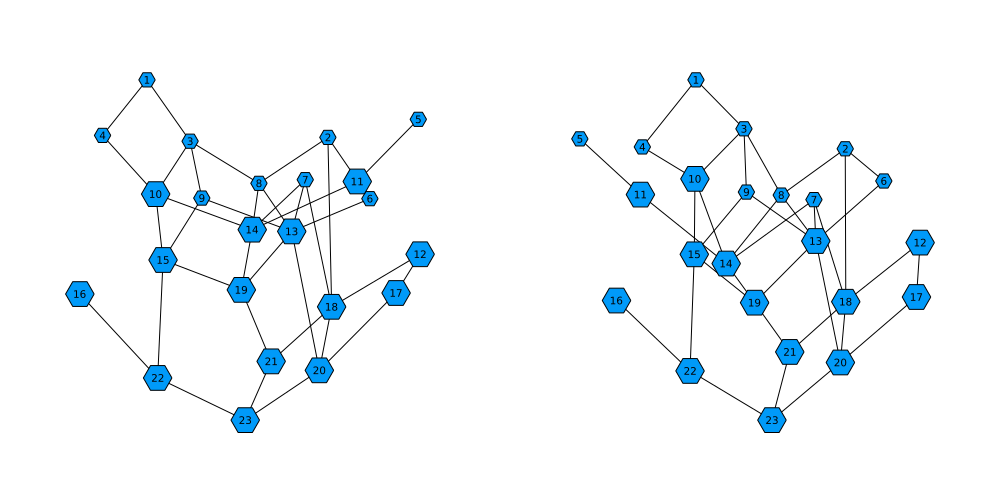

In [17]:
#P6s[13,19,:,:]=PA4i(0.5)
#D6s=distances(JordanNetsS6,P6s)
#revisedistances!(JordanNetsS6,D6s,P6s)

plot(datatograph1(D6s,3)[1],datatograph2(D6s,0.01)[1],size=(1000,500))

We calculate degenerations for nets in $\mathbb S^7$.

In [18]:
D7s,P7s=finddistances(JordanNetsS7,50)
#save P7s

open("JNS7Ps.csv", "w") do io
           writedlm(io,P7s)
end

  0.024880 seconds (44.49 k allocations: 21.186 MiB, 57.39% gc time)
distance squared from orbit of 1 to 1 is at most 2.8143940956213166e-14. 1 tries 
  1.802193 seconds (6.23 M allocations: 2.884 GiB, 18.82% gc time)
distance squared from orbit of 1 to 2 is at most 4.7390670297129574e-7. 3 tries 
  0.302997 seconds (1.02 M allocations: 482.204 MiB, 18.78% gc time)
distance squared from orbit of 1 to 3 is at most 7.805776850455649e-12. 1 tries 
  6.849903 seconds (21.52 M allocations: 9.958 GiB, 18.20% gc time)
distance squared from orbit of 1 to 4 is at most 0.3333333333343722. 50 tries 
  4.273116 seconds (14.17 M allocations: 6.555 GiB, 18.37% gc time)
distance squared from orbit of 1 to 5 is at most 0.500000000000046. 50 tries 
  8.638812 seconds (29.27 M allocations: 13.540 GiB, 18.33% gc time)
distance squared from orbit of 1 to 6 is at most 8.148479490541145e-8. 14 tries 
 31.340521 seconds (103.96 M allocations: 48.095 GiB, 18.36% gc time)
distance squared from orbit of 1 to 7 

  4.449796 seconds (17.06 M allocations: 7.895 GiB, 17.91% gc time)
distance squared from orbit of 3 to 2 is at most 0.2000000000037295. 50 tries 
  0.013457 seconds (60.19 k allocations: 28.517 MiB)
distance squared from orbit of 3 to 3 is at most 3.5223529778181723e-13. 1 tries 
  7.419543 seconds (28.45 M allocations: 13.161 GiB, 17.74% gc time)
distance squared from orbit of 3 to 4 is at most 0.3333333333498546. 50 tries 
  5.476402 seconds (20.96 M allocations: 9.701 GiB, 17.82% gc time)
distance squared from orbit of 3 to 5 is at most 0.5000000000003058. 50 tries 
 15.815955 seconds (61.58 M allocations: 28.490 GiB, 17.82% gc time)
distance squared from orbit of 3 to 6 is at most 0.16666702878448095. 50 tries 
 22.328024 seconds (89.77 M allocations: 41.523 GiB, 17.94% gc time)
distance squared from orbit of 3 to 7 is at most 3.527170575322729e-5. 50 tries 
  1.024178 seconds (4.12 M allocations: 1.904 GiB, 18.14% gc time)
distance squared from orbit of 3 to 8 is at most 7.380034

  9.833741 seconds (37.69 M allocations: 17.440 GiB, 18.89% gc time)
distance squared from orbit of 5 to 3 is at most 0.5833333333334517. 50 tries 
  4.404431 seconds (16.71 M allocations: 7.733 GiB, 18.99% gc time)
distance squared from orbit of 5 to 4 is at most 0.666666666669446. 50 tries 
  0.014385 seconds (65.89 k allocations: 31.228 MiB)
distance squared from orbit of 5 to 5 is at most 1.9479150376976526e-13. 1 tries 
 27.160797 seconds (103.76 M allocations: 48.003 GiB, 18.85% gc time)
distance squared from orbit of 5 to 6 is at most 0.16677340639336152. 50 tries 
  2.438462 seconds (9.49 M allocations: 4.394 GiB, 18.93% gc time)
distance squared from orbit of 5 to 7 is at most 0.4021790995729492. 50 tries 
  9.704723 seconds (37.30 M allocations: 17.259 GiB, 18.69% gc time)
distance squared from orbit of 5 to 8 is at most 0.5000165996930699. 50 tries 
  5.130397 seconds (19.48 M allocations: 9.016 GiB, 18.83% gc time)
distance squared from orbit of 5 to 9 is at most 0.50000000

 18.237085 seconds (71.36 M allocations: 33.016 GiB, 17.85% gc time)
distance squared from orbit of 7 to 4 is at most 0.6672132063510803. 50 tries 
 14.011014 seconds (55.09 M allocations: 25.492 GiB, 17.85% gc time)
distance squared from orbit of 7 to 5 is at most 0.5000000000001166. 50 tries 
 26.256549 seconds (102.83 M allocations: 47.576 GiB, 17.78% gc time)
distance squared from orbit of 7 to 6 is at most 0.16694033793526805. 50 tries 
  0.157512 seconds (622.66 k allocations: 295.061 MiB, 16.98% gc time)
distance squared from orbit of 7 to 7 is at most 2.7682962667153666e-13. 2 tries 
 25.574506 seconds (100.46 M allocations: 46.476 GiB, 17.76% gc time)
distance squared from orbit of 7 to 8 is at most 0.4573530652113512. 50 tries 
 10.906789 seconds (43.92 M allocations: 20.317 GiB, 17.72% gc time)
distance squared from orbit of 7 to 9 is at most 0.750002001507617. 50 tries 
 24.513035 seconds (97.01 M allocations: 44.875 GiB, 17.83% gc time)
distance squared from orbit of 7 to 

  3.124933 seconds (10.40 M allocations: 4.812 GiB, 16.66% gc time)
distance squared from orbit of 9 to 5 is at most 0.6666666666668035. 50 tries 
 33.151630 seconds (86.39 M allocations: 39.963 GiB, 16.42% gc time)
distance squared from orbit of 9 to 6 is at most 0.3333335519650089. 50 tries 
  7.305532 seconds (22.30 M allocations: 10.321 GiB, 17.10% gc time)
distance squared from orbit of 9 to 7 is at most 0.5494262597416593. 50 tries 
 21.923187 seconds (57.36 M allocations: 26.534 GiB, 16.49% gc time)
distance squared from orbit of 9 to 8 is at most 0.25000062794329564. 50 tries 
  1.426439 seconds (5.31 M allocations: 2.456 GiB, 18.86% gc time)
distance squared from orbit of 9 to 9 is at most 1.0162201993057261e-13. 32 tries 
 12.744352 seconds (46.17 M allocations: 21.359 GiB, 18.54% gc time)
distance squared from orbit of 9 to 10 is at most 0.33333333340210947. 50 tries 
 28.973592 seconds (103.38 M allocations: 47.824 GiB, 19.11% gc time)
distance squared from orbit of 9 to 11

  2.321080 seconds (8.94 M allocations: 4.135 GiB, 17.47% gc time)
distance squared from orbit of 11 to 6 is at most 0.16666666666674113. 50 tries 
 30.623346 seconds (104.49 M allocations: 48.343 GiB, 16.72% gc time)
distance squared from orbit of 11 to 7 is at most 0.5000168471779197. 50 tries 
 26.730955 seconds (98.27 M allocations: 45.464 GiB, 17.60% gc time)
distance squared from orbit of 11 to 8 is at most 0.5000002170686592. 50 tries 
 13.744389 seconds (49.56 M allocations: 22.928 GiB, 17.47% gc time)
distance squared from orbit of 11 to 9 is at most 0.7268409429801785. 50 tries 
 15.059107 seconds (56.41 M allocations: 26.100 GiB, 17.76% gc time)
distance squared from orbit of 11 to 10 is at most 0.460784766899273. 50 tries 
  0.018761 seconds (89.50 k allocations: 42.417 MiB)
distance squared from orbit of 11 to 11 is at most 4.595068364263424e-13. 1 tries 
 25.284216 seconds (89.99 M allocations: 41.633 GiB, 17.40% gc time)
distance squared from orbit of 11 to 12 is at most

  2.463836 seconds (8.81 M allocations: 4.076 GiB, 18.88% gc time)
distance squared from orbit of 13 to 7 is at most 0.5609503356752914. 50 tries 
 20.271169 seconds (71.63 M allocations: 33.140 GiB, 18.85% gc time)
distance squared from orbit of 13 to 8 is at most 0.48651951039500657. 50 tries 
 12.088974 seconds (43.14 M allocations: 19.958 GiB, 18.83% gc time)
distance squared from orbit of 13 to 9 is at most 0.5000000000001109. 50 tries 
 17.554191 seconds (62.56 M allocations: 28.943 GiB, 18.78% gc time)
distance squared from orbit of 13 to 10 is at most 0.33333333333340814. 50 tries 
 29.285632 seconds (104.64 M allocations: 48.409 GiB, 18.72% gc time)
distance squared from orbit of 13 to 11 is at most 0.33333438266905774. 50 tries 
 24.687138 seconds (87.97 M allocations: 40.690 GiB, 18.65% gc time)
distance squared from orbit of 13 to 12 is at most 0.40000010433417926. 50 tries 
  0.015678 seconds (70.18 k allocations: 33.263 MiB)
distance squared from orbit of 13 to 13 is at m

 10.733165 seconds (28.64 M allocations: 13.251 GiB, 16.56% gc time)
distance squared from orbit of 15 to 8 is at most 0.2500000000002711. 50 tries 
  5.483850 seconds (14.77 M allocations: 6.834 GiB, 16.36% gc time)
distance squared from orbit of 15 to 9 is at most 0.5000000000000145. 50 tries 
  7.829100 seconds (21.64 M allocations: 10.013 GiB, 16.52% gc time)
distance squared from orbit of 15 to 10 is at most 0.7113248654052632. 50 tries 
 36.978834 seconds (103.69 M allocations: 47.969 GiB, 16.47% gc time)
distance squared from orbit of 15 to 11 is at most 0.4587348501075406. 50 tries 
 23.045578 seconds (59.58 M allocations: 27.566 GiB, 16.03% gc time)
distance squared from orbit of 15 to 12 is at most 0.40000000000028285. 50 tries 
  6.489343 seconds (17.11 M allocations: 7.917 GiB, 16.16% gc time)
distance squared from orbit of 15 to 13 is at most 0.5929535825587424. 50 tries 
 36.816167 seconds (96.98 M allocations: 44.867 GiB, 16.30% gc time)
distance squared from orbit of 15

 22.188762 seconds (58.37 M allocations: 27.002 GiB, 14.90% gc time)
distance squared from orbit of 17 to 9 is at most 0.7500007170827269. 50 tries 
 22.310952 seconds (59.34 M allocations: 27.452 GiB, 15.05% gc time)
distance squared from orbit of 17 to 10 is at most 0.7275542039827162. 50 tries 
  2.361186 seconds (5.94 M allocations: 2.750 GiB, 14.70% gc time)
distance squared from orbit of 17 to 11 is at most 0.20833333333342846. 50 tries 
 37.920239 seconds (94.45 M allocations: 43.698 GiB, 16.83% gc time)
distance squared from orbit of 17 to 12 is at most 0.5000008406002721. 50 tries 
 25.907269 seconds (68.90 M allocations: 31.875 GiB, 18.67% gc time)
distance squared from orbit of 17 to 13 is at most 0.5833333333335727. 50 tries 
  7.001707 seconds (20.64 M allocations: 9.551 GiB, 19.01% gc time)
distance squared from orbit of 17 to 14 is at most 0.35358904945503555. 50 tries 
 20.675276 seconds (54.83 M allocations: 25.364 GiB, 18.40% gc time)
distance squared from orbit of 17

 31.997677 seconds (88.74 M allocations: 41.063 GiB, 17.00% gc time)
distance squared from orbit of 19 to 10 is at most 0.7275530212949703. 50 tries 
 39.679019 seconds (104.50 M allocations: 48.349 GiB, 16.83% gc time)
distance squared from orbit of 19 to 11 is at most 0.4587352502309134. 50 tries 
 34.517367 seconds (91.50 M allocations: 42.328 GiB, 16.75% gc time)
distance squared from orbit of 19 to 12 is at most 0.40000000327445356. 50 tries 
 27.668681 seconds (73.56 M allocations: 34.039 GiB, 16.74% gc time)
distance squared from orbit of 19 to 13 is at most 0.6145184472614486. 50 tries 
  6.555880 seconds (17.19 M allocations: 7.952 GiB, 16.85% gc time)
distance squared from orbit of 19 to 14 is at most 0.2500000000000806. 50 tries 
 27.660290 seconds (72.97 M allocations: 33.754 GiB, 16.81% gc time)
distance squared from orbit of 19 to 15 is at most 0.3334064953056072. 50 tries 
 13.502795 seconds (35.60 M allocations: 16.473 GiB, 16.82% gc time)
distance squared from orbit of

 35.483922 seconds (96.34 M allocations: 44.570 GiB, 16.03% gc time)
distance squared from orbit of 21 to 11 is at most 0.5000253421980629. 50 tries 
 20.354790 seconds (52.95 M allocations: 24.496 GiB, 15.76% gc time)
distance squared from orbit of 21 to 12 is at most 0.5000000000000336. 50 tries 
 28.118715 seconds (71.20 M allocations: 32.940 GiB, 15.47% gc time)
distance squared from orbit of 21 to 13 is at most 0.5000002295950677. 50 tries 
 29.324298 seconds (80.14 M allocations: 37.076 GiB, 15.76% gc time)
distance squared from orbit of 21 to 14 is at most 0.5000060962986014. 50 tries 
 19.922702 seconds (51.82 M allocations: 23.977 GiB, 15.71% gc time)
distance squared from orbit of 21 to 15 is at most 0.3333333333768747. 50 tries 
 11.228371 seconds (28.40 M allocations: 13.139 GiB, 15.48% gc time)
distance squared from orbit of 21 to 16 is at most 0.8750000000050625. 50 tries 
 39.396030 seconds (105.61 M allocations: 48.860 GiB, 15.75% gc time)
distance squared from orbit of

 22.792576 seconds (64.37 M allocations: 29.782 GiB, 17.99% gc time)
distance squared from orbit of 23 to 12 is at most 0.5000000000001849. 50 tries 
  3.952129 seconds (9.93 M allocations: 4.595 GiB, 17.50% gc time)
distance squared from orbit of 23 to 13 is at most 0.5000000000000431. 50 tries 
 25.611524 seconds (65.51 M allocations: 30.310 GiB, 17.44% gc time)
distance squared from orbit of 23 to 14 is at most 0.5000085439339349. 50 tries 
 13.704818 seconds (35.51 M allocations: 16.430 GiB, 17.54% gc time)
distance squared from orbit of 23 to 15 is at most 0.333333333536027. 50 tries 
 10.759208 seconds (28.00 M allocations: 12.958 GiB, 17.62% gc time)
distance squared from orbit of 23 to 16 is at most 0.8751566662498197. 50 tries 
 40.305622 seconds (105.19 M allocations: 48.663 GiB, 17.47% gc time)
distance squared from orbit of 23 to 17 is at most 0.6458341624494645. 50 tries 
 35.223801 seconds (91.44 M allocations: 42.303 GiB, 17.35% gc time)
distance squared from orbit of 23

  2.963104 seconds (8.08 M allocations: 3.738 GiB, 16.20% gc time)
distance squared from orbit of 25 to 13 is at most 0.614518333054956. 50 tries 
  9.927552 seconds (26.63 M allocations: 12.326 GiB, 16.63% gc time)
distance squared from orbit of 25 to 14 is at most 0.5793156242931875. 50 tries 
  9.462548 seconds (22.22 M allocations: 10.280 GiB, 15.80% gc time)
distance squared from orbit of 25 to 15 is at most 0.5833333335923028. 50 tries 
 11.805651 seconds (30.29 M allocations: 14.018 GiB, 16.23% gc time)
distance squared from orbit of 25 to 16 is at most 0.8750000235067725. 50 tries 
  1.910907 seconds (4.94 M allocations: 2.286 GiB, 16.04% gc time)
distance squared from orbit of 25 to 17 is at most 0.6458333333335508. 50 tries 
  5.811252 seconds (15.10 M allocations: 6.985 GiB, 16.55% gc time)
distance squared from orbit of 25 to 18 is at most 0.5000000000000911. 50 tries 
 25.461326 seconds (68.91 M allocations: 31.885 GiB, 16.61% gc time)
distance squared from orbit of 25 to 

  1.817855 seconds (4.94 M allocations: 2.286 GiB, 15.54% gc time)
distance squared from orbit of 27 to 14 is at most 0.5799193475827998. 50 tries 
  7.072844 seconds (19.01 M allocations: 8.799 GiB, 15.73% gc time)
distance squared from orbit of 27 to 15 is at most 0.5833333333333404. 50 tries 
  5.196654 seconds (14.00 M allocations: 6.481 GiB, 16.03% gc time)
distance squared from orbit of 27 to 16 is at most 0.8750000000000969. 50 tries 
  3.362271 seconds (9.03 M allocations: 4.179 GiB, 15.69% gc time)
distance squared from orbit of 27 to 17 is at most 0.6666666666668272. 50 tries 
 10.147303 seconds (27.30 M allocations: 12.636 GiB, 15.69% gc time)
distance squared from orbit of 27 to 18 is at most 0.7142857142909251. 50 tries 
  2.036495 seconds (5.47 M allocations: 2.529 GiB, 16.09% gc time)
distance squared from orbit of 27 to 19 is at most 0.4359405000379309. 50 tries 
  2.063794 seconds (5.59 M allocations: 2.588 GiB, 15.19% gc time)
distance squared from orbit of 27 to 20 i

revised distance squared from orbit of 1 to 24 is at most 0.20041302631016614. 
distance squared from orbit of 1 to 24 will be revised since for 1 19 24: 8.640753862370657e-6+0.20003145517115023<0.20041302631016614
revised distance squared from orbit of 1 to 24 is at most 0.20041302631016614. 
distance squared from orbit of 1 to 25 will be revised since for 1 6 25: 8.148479490541145e-8+1.2486974959020576e-8<1.3959149443160941e-6
revised distance squared from orbit of 1 to 25 is at most 1.3959149443160941e-6. 
distance squared from orbit of 1 to 25 will be revised since for 1 18 25: 7.938912410528549e-7+2.2542424581964638e-8<1.3959149443160941e-6
revised distance squared from orbit of 1 to 25 is at most 8.681864911463366e-7. 
distance squared from orbit of 1 to 26 will be revised since for 1 2 26: 4.7390670297129574e-7+0.00023162929264318807<0.00044474303138166847
revised distance squared from orbit of 1 to 26 is at most 0.00018448701835671653. 
distance squared from orbit of 1 to 26 wi

revised distance squared from orbit of 2 to 24 is at most 0.20029817027027005. 
distance squared from orbit of 2 to 25 will be revised since for 2 11 25: 1.850992574903488e-6+7.599419494807388e-7<4.6590551267635266e-6
revised distance squared from orbit of 2 to 25 is at most 1.604607221764158e-6. 
distance squared from orbit of 2 to 25 will be revised since for 2 18 25: 7.061251228349591e-7+2.2542424581964638e-8<1.604607221764158e-6
revised distance squared from orbit of 2 to 25 is at most 1.604607221764158e-6. 
distance squared from orbit of 2 to 26 will be revised since for 2 7 26: 1.3363366098697689e-5+1.3595408774010883e-5<0.00023162929264318807
revised distance squared from orbit of 2 to 26 is at most 0.00023162929264318807. 
distance squared from orbit of 2 to 26 will be revised since for 2 12 26: 1.663348421524005e-8+0.00017821694368675138<0.00023162929264318807
revised distance squared from orbit of 2 to 26 is at most 9.58163236080022e-5. 
distance squared from orbit of 2 to 26

revised distance squared from orbit of 4 to 7 is at most 0.5572454878309517. 
distance squared from orbit of 4 to 7 will be revised since for 4 2 7: 0.5000000014725496+1.3363366098697689e-5<0.5572454878309517
revised distance squared from orbit of 4 to 7 is at most 0.5572454878309517. 
distance squared from orbit of 4 to 7 will be revised since for 4 3 7: 0.5000000005038238+3.527170575322729e-5<0.5572454878309517
revised distance squared from orbit of 4 to 7 is at most 0.5572454878309517. 
distance squared from orbit of 4 to 11 will be revised since for 4 6 11: 0.3333333378743082+2.686787244106156e-7<0.3333339511341054
revised distance squared from orbit of 4 to 11 is at most 0.3333339511341054. 
distance squared from orbit of 4 to 12 will be revised since for 4 8 12: 2.399943510470258e-7+0.20000000000018708<0.20000034723523388
revised distance squared from orbit of 4 to 12 is at most 0.20000001888187613. 
distance squared from orbit of 4 to 13 will be revised since for 4 10 13: 5.2348

revised distance squared from orbit of 5 to 8 is at most 0.5000165996930699. 
distance squared from orbit of 5 to 8 will be revised since for 5 20 8: 1.168420505571088e-6+0.5000003508622973<0.5000165996930699
revised distance squared from orbit of 5 to 8 is at most 0.5000003665132761. 
distance squared from orbit of 5 to 10 will be revised since for 5 18 10: 1.8503968767362432e-6+0.46078472443212115<0.460808308928975
revised distance squared from orbit of 5 to 10 is at most 0.46078601053001045. 
distance squared from orbit of 5 to 13 will be revised since for 5 18 13: 1.8503968767362432e-6+0.16666666666682453<0.16677546720789996
revised distance squared from orbit of 5 to 13 is at most 0.16666726670568827. 
distance squared from orbit of 5 to 15 will be revised since for 5 19 15: 0.14285772146888634+0.3334064953056072<0.4768107655602449
revised distance squared from orbit of 5 to 15 is at most 0.4768107655602449. 
distance squared from orbit of 5 to 15 will be revised since for 5 26 15

revised distance squared from orbit of 6 to 16 is at most 0.400014388943892. 
distance squared from orbit of 6 to 21 will be revised since for 6 13 21: 0.16666667635466953+0.20000000147282754<0.4000000024690921
revised distance squared from orbit of 6 to 21 is at most 0.4000000024690921. 
distance squared from orbit of 6 to 21 will be revised since for 6 23 21: 0.16666667024741744+0.20000000000001478<0.4000000024690921
revised distance squared from orbit of 6 to 21 is at most 0.4000000016244594. 
distance squared from orbit of 6 to 22 will be revised since for 6 11 22: 2.686787244106156e-7+1.235564730351733e-5<5.8062241766333415e-5
revised distance squared from orbit of 6 to 22 is at most 5.8062241766333415e-5. 
distance squared from orbit of 6 to 22 will be revised since for 6 17 22: 7.605329686152696e-7+9.750836732961828e-7<5.8062241766333415e-5
revised distance squared from orbit of 6 to 22 is at most 5.8062241766333415e-5. 
distance squared from orbit of 6 to 24 will be revised sin

revised distance squared from orbit of 7 to 20 is at most 1.306905443653108e-5. 
distance squared from orbit of 7 to 21 will be revised since for 7 13 21: 0.1950300971310746+0.20000000147282754<0.40024849027647497
revised distance squared from orbit of 7 to 21 is at most 0.40024849027647497. 
distance squared from orbit of 7 to 21 will be revised since for 7 14 21: 1.4710941048008673e-5+0.4000000940194731<0.40024849027647497
revised distance squared from orbit of 7 to 21 is at most 0.40024849027647497. 
distance squared from orbit of 7 to 21 will be revised since for 7 17 21: 1.263027595839269e-6+0.40000050723038166<0.40024849027647497
revised distance squared from orbit of 7 to 21 is at most 0.4000013943126086. 
distance squared from orbit of 7 to 21 will be revised since for 7 23 21: 0.16704960052435328+0.20000000000001478<0.4000013943126086
revised distance squared from orbit of 7 to 21 is at most 0.4000013943126086. 
distance squared from orbit of 7 to 23 will be revised since for 

revised distance squared from orbit of 8 to 24 is at most 0.2001419260164852. 
distance squared from orbit of 8 to 25 will be revised since for 8 18 25: 6.06350248588218e-7+2.2542424581964638e-8<2.313516512584589e-6
revised distance squared from orbit of 8 to 25 is at most 2.953228993195046e-7. 
distance squared from orbit of 8 to 26 will be revised since for 8 14 26: 2.7021844120461495e-5+6.606043966159685e-7<0.0002165076757744574
revised distance squared from orbit of 8 to 26 is at most 4.065639360660219e-5. 
distance squared from orbit of 8 to 26 will be revised since for 8 19 26: 2.5821646947793584e-5+3.769987491983651e-7<4.065639360660219e-5
revised distance squared from orbit of 8 to 26 is at most 4.065639360660219e-5. 
distance squared from orbit of 8 to 27 will be revised since for 8 18 27: 6.06350248588218e-7+1.6852438882707318e-6<5.114882964073646e-6
revised distance squared from orbit of 8 to 27 is at most 5.114882964073646e-6. 
distance squared from orbit of 8 to 27 will be

revised distance squared from orbit of 10 to 18 is at most 6.2497385953656e-7. 
distance squared from orbit of 10 to 19 will be revised since for 10 13 19: 1.4204618059276604e-10+0.00013169016679439327<0.00015499658637500342
revised distance squared from orbit of 10 to 19 is at most 0.00010405578206829336. 
distance squared from orbit of 10 to 20 will be revised since for 10 14 20: 0.0001335380686589406+2.7703186720002404e-5<0.00046491331215565605
revised distance squared from orbit of 10 to 20 is at most 0.00046491331215565605. 
distance squared from orbit of 10 to 20 will be revised since for 10 18 20: 6.2497385953656e-7+1.1327787210726066e-5<0.00046491331215565605
revised distance squared from orbit of 10 to 20 is at most 0.00046491331215565605. 
distance squared from orbit of 10 to 20 will be revised since for 10 19 20: 0.00010405578206829336+7.246916594675523e-7<0.00046491331215565605
revised distance squared from orbit of 10 to 20 is at most 0.0003215790401518447. 
distance squar

revised distance squared from orbit of 11 to 24 is at most 0.400000024519607. 
distance squared from orbit of 11 to 24 will be revised since for 11 27 24: 2.4085920933492915e-8+0.4000000000000207<0.400000024519607
revised distance squared from orbit of 11 to 24 is at most 0.4000000120961839. 
distance squared from orbit of 11 to 25 will be revised since for 11 18 25: 3.1807084935053145e-7+2.2542424581964638e-8<7.599419494807388e-7
revised distance squared from orbit of 11 to 25 is at most 2.3583944455157915e-8. 

distance squared from orbit of 12 to 3 will be revised since for 12 1 3: 0.5000000000000222+7.805776850455649e-12<0.5669872981079116
revised distance squared from orbit of 12 to 3 is at most 0.5669872981079116. 
distance squared from orbit of 12 to 7 will be revised since for 12 1 7: 0.5000000000000222+3.737521804908807e-6<0.574427077456487
revised distance squared from orbit of 12 to 7 is at most 0.574427077456487. 
distance squared from orbit of 12 to 7 will be revised since

revised distance squared from orbit of 13 to 26 is at most 1.1454464931328675e-5. 
distance squared from orbit of 13 to 27 will be revised since for 13 18 27: 6.70577031519286e-7+1.6852438882707318e-6<0.00012852355615701453
revised distance squared from orbit of 13 to 27 is at most 6.396495350900023e-5. 
distance squared from orbit of 13 to 27 will be revised since for 13 25 27: 4.825120953945364e-7+4.14283971197918e-8<6.396495350900023e-5
revised distance squared from orbit of 13 to 27 is at most 6.396495350900023e-5. 
distance squared from orbit of 13 to 27 will be revised since for 13 26 27: 1.1454464931328675e-5+8.322754772760513e-7<6.396495350900023e-5
revised distance squared from orbit of 13 to 27 is at most 1.5255923450780328e-5. 

distance squared from orbit of 14 to 1 will be revised since for 14 8 1: 0.4865505027031861+0.5000000000000856<1.0000000000000768
revised distance squared from orbit of 14 to 1 is at most 1.0000000000000768. 
distance squared from orbit of 14 to 1 wi

revised distance squared from orbit of 15 to 2 is at most 0.7692257017757711. 
distance squared from orbit of 15 to 2 will be revised since for 15 14 2: 0.2500408702528596+0.5000000308592726<0.7692257017757711
revised distance squared from orbit of 15 to 2 is at most 0.7692257017757711. 
distance squared from orbit of 15 to 4 will be revised since for 15 8 4: 0.2500000000002711+0.33333333333335075<0.666666666666749
revised distance squared from orbit of 15 to 4 is at most 0.666666666666749. 
distance squared from orbit of 15 to 7 will be revised since for 15 3 7: 0.6473671297244358+3.527170575322729e-5<0.6606500560504187
revised distance squared from orbit of 15 to 7 is at most 0.6606500560504187. 
distance squared from orbit of 15 to 10 will be revised since for 15 4 10: 0.666666666666749+5.234815624435434e-12<0.7113248654052632
revised distance squared from orbit of 15 to 10 is at most 0.7113248654052632. 
distance squared from orbit of 15 to 10 will be revised since for 15 8 10: 0.2

revised distance squared from orbit of 16 to 10 is at most 0.9239074288061877. 
distance squared from orbit of 16 to 10 will be revised since for 16 5 10: 0.33333333333743037+0.46078601053001045<0.9239074288061877
revised distance squared from orbit of 16 to 10 is at most 0.9239074288061877. 
distance squared from orbit of 16 to 10 will be revised since for 16 8 10: 0.5000000000002398+0.39421966414260984<0.9239074288061877
revised distance squared from orbit of 16 to 10 is at most 0.9239074288061877. 
distance squared from orbit of 16 to 10 will be revised since for 16 11 10: 0.375000510093986+0.460784766899273<0.9239074288061877
revised distance squared from orbit of 16 to 10 is at most 0.9239074288061877. 
distance squared from orbit of 16 to 11 will be revised since for 16 5 11: 0.33333333333743037+0.0001315547549988315<0.375000510093986
revised distance squared from orbit of 16 to 11 is at most 0.375000510093986. 
distance squared from orbit of 16 to 13 will be revised since for 16

revised distance squared from orbit of 16 to 25 is at most 0.500007812163765. 
distance squared from orbit of 16 to 25 will be revised since for 16 19 25: 0.40970296308438264+4.431671039716268e-7<0.500007812163765
revised distance squared from orbit of 16 to 25 is at most 0.500007812163765. 
distance squared from orbit of 16 to 25 will be revised since for 16 20 25: 0.3333334666625278+3.613705994822693e-7<0.500007812163765
revised distance squared from orbit of 16 to 25 is at most 0.500007812163765. 
distance squared from orbit of 16 to 25 will be revised since for 16 22 25: 6.371313431564292e-7+0.5000031929900258<0.500007812163765
revised distance squared from orbit of 16 to 25 is at most 0.5000040097229032. 
distance squared from orbit of 16 to 25 will be revised since for 16 27 25: 3.1819785362965833e-6+0.5000000000000377<0.5000040097229032
revised distance squared from orbit of 16 to 25 is at most 0.5000008963508851. 
distance squared from orbit of 16 to 27 will be revised since fo

revised distance squared from orbit of 18 to 19 is at most 0.142860280597937. 
distance squared from orbit of 18 to 21 will be revised since for 18 13 21: 0.16666666666682453+0.20000000147282754<0.4000000011321646
revised distance squared from orbit of 18 to 21 is at most 0.4000000011321646. 
distance squared from orbit of 18 to 21 will be revised since for 18 23 21: 0.16666666960961546+0.20000000000001478<0.4000000011321646
revised distance squared from orbit of 18 to 21 is at most 0.4000000006617907. 
distance squared from orbit of 18 to 22 will be revised since for 18 6 22: 0.3333333333333851+5.8062241766333415e-5<0.500000000000104
revised distance squared from orbit of 18 to 22 is at most 0.500000000000104. 
distance squared from orbit of 18 to 22 will be revised since for 18 11 22: 0.3333333333334648+1.235564730351733e-5<0.500000000000104
revised distance squared from orbit of 18 to 22 is at most 0.500000000000104. 
distance squared from orbit of 18 to 22 will be revised since for

revised distance squared from orbit of 19 to 22 is at most 0.6752413585987581. 
distance squared from orbit of 19 to 22 will be revised since for 19 20 22: 7.246916594675523e-7+0.6752404735809641<0.6752413585987581
revised distance squared from orbit of 19 to 22 is at most 0.6752405342491549. 
distance squared from orbit of 19 to 24 will be revised since for 19 26 24: 3.769987491983651e-7+0.2000000000043958<0.20003145517115023
revised distance squared from orbit of 19 to 24 is at most 0.2000042811163801. 
distance squared from orbit of 19 to 27 will be revised since for 19 20 27: 7.246916594675523e-7+2.8689681112330136e-8<1.9008265974862912e-6
revised distance squared from orbit of 19 to 27 is at most 1.3746435994308026e-7. 

distance squared from orbit of 20 to 2 will be revised since for 20 14 2: 0.3588307783100731+0.5000000308592726<0.8964466094068897
revised distance squared from orbit of 20 to 2 is at most 0.8964466094068897. 
distance squared from orbit of 20 to 8 will be revised

revised distance squared from orbit of 21 to 20 is at most 0.3333583232646791. 
distance squared from orbit of 21 to 20 will be revised since for 21 24 20: 1.8704434396067724e-9+0.3333340747217656<0.3333583232646791
revised distance squared from orbit of 21 to 20 is at most 0.3333340746301301. 
distance squared from orbit of 21 to 20 will be revised since for 21 25 20: 4.359523553186725e-7+0.333333345609604<0.3333340746301301
revised distance squared from orbit of 21 to 20 is at most 0.3333340746301301. 
distance squared from orbit of 21 to 22 will be revised since for 21 6 22: 0.666666759470491+5.8062241766333415e-5<0.8750194604774518
revised distance squared from orbit of 21 to 22 is at most 0.8750194604774518. 
distance squared from orbit of 21 to 22 will be revised since for 21 11 22: 0.5000003946925087+1.235564730351733e-5<0.8750194604774518
revised distance squared from orbit of 21 to 22 is at most 0.8750194604774518. 
distance squared from orbit of 21 to 22 will be revised since

revised distance squared from orbit of 22 to 21 is at most 0.9000020348278731. 
distance squared from orbit of 22 to 21 will be revised since for 22 17 21: 0.3333333333334784+0.4000002160437883<0.9000020348278731
revised distance squared from orbit of 22 to 21 is at most 0.9000020348278731. 
distance squared from orbit of 22 to 21 will be revised since for 22 19 21: 0.43594064769560137+0.40000001376112604<0.9000020348278731
revised distance squared from orbit of 22 to 21 is at most 0.9000020348278731. 
distance squared from orbit of 22 to 21 will be revised since for 22 20 21: 0.33333336731801805+0.40000000896464255<0.9000020348278731
revised distance squared from orbit of 22 to 21 is at most 0.9000020348278731. 
distance squared from orbit of 22 to 21 will be revised since for 22 23 21: 0.6666666666667036+0.20000000000001478<0.9000020348278731
revised distance squared from orbit of 22 to 21 is at most 0.9000020348278731. 
distance squared from orbit of 22 to 21 will be revised since f

revised distance squared from orbit of 24 to 6 is at most 0.8333334745845482. 
distance squared from orbit of 24 to 7 will be revised since for 24 15 7: 0.33333333333341547+0.6606500560504187<1.0000000000973466
revised distance squared from orbit of 24 to 7 is at most 1.0000000000973466. 
distance squared from orbit of 24 to 7 will be revised since for 24 19 7: 0.33338112414868026+0.6611185183610793<1.0000000000973466
revised distance squared from orbit of 24 to 7 is at most 1.0000000000973466. 
distance squared from orbit of 24 to 9 will be revised since for 24 8 9: 0.5000000000011836+0.25000000000004585<0.8333333333336892
revised distance squared from orbit of 24 to 9 is at most 0.8333333333336892. 
distance squared from orbit of 24 to 9 will be revised since for 24 15 9: 0.33333333333341547+0.5000000000000145<0.8333333333336892
revised distance squared from orbit of 24 to 9 is at most 0.8333333333336892. 
distance squared from orbit of 24 to 10 will be revised since for 24 4 10: 0.9

revised distance squared from orbit of 25 to 17 is at most 0.6458333333335508. 
distance squared from orbit of 25 to 21 will be revised since for 25 23 21: 0.16666666666667862+0.20000000000001478<0.40000000000002134
revised distance squared from orbit of 25 to 21 is at most 0.40000000000002134. 
distance squared from orbit of 25 to 22 will be revised since for 25 6 22: 0.666666666666706+5.8062241766333415e-5<0.8750000298910977
revised distance squared from orbit of 25 to 22 is at most 0.8750000298910977. 
distance squared from orbit of 25 to 22 will be revised since for 25 11 22: 0.5000000190581585+1.235564730351733e-5<0.8750000298910977
revised distance squared from orbit of 25 to 22 is at most 0.8750000298910977. 
distance squared from orbit of 25 to 22 will be revised since for 25 17 22: 0.6458333333335508+9.750836732961828e-7<0.8750000298910977
revised distance squared from orbit of 25 to 22 is at most 0.8750000298910977. 
distance squared from orbit of 25 to 24 will be revised sin

revised distance squared from orbit of 26 to 25 is at most 0.5000003358035481. 
distance squared from orbit of 26 to 25 will be revised since for 26 19 25: 0.3333333333333942+4.431671039716268e-7<0.5000003358035481
revised distance squared from orbit of 26 to 25 is at most 0.5000003358035481. 
distance squared from orbit of 26 to 25 will be revised since for 26 20 25: 0.3333334932953352+3.613705994822693e-7<0.5000003358035481
revised distance squared from orbit of 26 to 25 is at most 0.5000003358035481. 

distance squared from orbit of 27 to 4 will be revised since for 27 8 4: 0.5000000000000453+0.33333333333335075<0.9166666666667459
revised distance squared from orbit of 27 to 4 is at most 0.9166666666667459. 
distance squared from orbit of 27 to 6 will be revised since for 27 11 6: 0.5000000000000749+0.16666666666674113<0.8333333333333859
revised distance squared from orbit of 27 to 6 is at most 0.8333333333333859. 
distance squared from orbit of 27 to 9 will be revised since for 27 

rechecked better distance squared from orbit of 4 to 25 is at most 2.133579459222375e-7 old is 1.8771333721754764e-6. 
rechecked better distance squared from orbit of 4 to 26 is at most 2.353075064261303e-5 old is 2.3536344560586534e-5. 
rechecked better distance squared from orbit of 4 to 27 is at most 1.230208533408735e-5 old is 1.2490883388787412e-5. 
rechecked better distance squared from orbit of 5 to 6 is at most 0.16669274129487496 old is 0.16677340639336152. 
rechecked better distance squared from orbit of 5 to 8 is at most 0.5000003664533484 old is 0.5000003665132761. 
rechecked better distance squared from orbit of 5 to 10 is at most 0.4607856989096745 old is 0.46078601053001045. 
rechecked better distance squared from orbit of 5 to 11 is at most 1.060564274287302e-5 old is 0.0001315547549988315. 
rechecked better distance squared from orbit of 5 to 13 is at most 0.16666725516526026 old is 0.16666726670568827. 
rechecked new distance squared from orbit of 5 to 17 is at most 0

rechecked better distance squared from orbit of 11 to 22 is at most 2.0415412651758296e-6 old is 1.235564730351733e-5. 
rechecked better distance squared from orbit of 11 to 23 is at most 0.166666677469554 old is 0.16666675155217792. 
rechecked better distance squared from orbit of 11 to 26 is at most 0.14285714557043194 old is 0.1428571562857499. 
rechecked better distance squared from orbit of 11 to 27 is at most 5.8374675951773705e-9 old is 2.4085920933492915e-8. 
rechecked better distance squared from orbit of 12 to 6 is at most 0.33333369953695485 old is 0.3333338359033596. 
rechecked better distance squared from orbit of 12 to 8 is at most 0.2500001310520578 old is 0.2500001573519962. 
rechecked better distance squared from orbit of 12 to 11 is at most 0.33333359825237874 old is 0.33333390787683137. 
rechecked better distance squared from orbit of 12 to 13 is at most 0.1666667317070736 old is 0.16666685980954538. 
rechecked better distance squared from orbit of 12 to 14 is at mos

rechecked better distance squared from orbit of 21 to 11 is at most 0.5000003883540204 old is 0.5000003946925087. 
rechecked better distance squared from orbit of 21 to 13 is at most 0.5000001633894312 old is 0.5000002295950677. 
rechecked better distance squared from orbit of 21 to 17 is at most 0.6458334752575285 old is 0.6458334774782098. 
rechecked better distance squared from orbit of 21 to 18 is at most 0.5000000582186045 old is 0.5000000584926472. 
rechecked better distance squared from orbit of 21 to 20 is at most 0.3333340746301152 old is 0.3333340746301301. 
rechecked better distance squared from orbit of 21 to 22 is at most 0.8750003407453729 old is 0.8750003471208884. 
rechecked better distance squared from orbit of 21 to 23 is at most 4.607386047575306e-7 old is 5.902143258015339e-7. 
rechecked better distance squared from orbit of 21 to 25 is at most 3.4609470580525476e-7 old is 4.359523553186725e-7. 
rechecked better distance squared from orbit of 21 to 26 is at most 1.7

revised distance squared from orbit of 1 to 11 is at most 2.759318815356846e-7. 
distance squared from orbit of 1 to 11 will be revised since for 1 6 11: 2.4332039892151664e-8+7.083323759597627e-8<2.759318815356846e-7
revised distance squared from orbit of 1 to 11 is at most 2.759318815356846e-7. 
distance squared from orbit of 1 to 13 will be revised since for 1 2 13: 9.50627875362481e-8+0.16666666666896607<0.16666691453363697
revised distance squared from orbit of 1 to 13 is at most 0.16666668960569508. 
distance squared from orbit of 1 to 14 will be revised since for 1 3 14: 7.805776850455649e-12+2.4116046893480727e-5<5.1159061894718174e-5
revised distance squared from orbit of 1 to 14 is at most 5.1159061894718174e-5. 
distance squared from orbit of 1 to 14 will be revised since for 1 7 14: 1.3187990789414354e-6+6.455847406885758e-6<5.1159061894718174e-5
revised distance squared from orbit of 1 to 14 is at most 4.443693196864974e-5. 
distance squared from orbit of 1 to 14 will be r

revised distance squared from orbit of 1 to 27 is at most 4.374215109378073e-6. 
distance squared from orbit of 1 to 27 will be revised since for 1 8 27: 1.0706428109095072e-10+1.091110255996825e-7<4.374215109378073e-6
revised distance squared from orbit of 1 to 27 is at most 4.374215109378073e-6. 
distance squared from orbit of 1 to 27 will be revised since for 1 11 27: 2.759318815356846e-7+5.8374675951773705e-9<4.374215109378073e-6
revised distance squared from orbit of 1 to 27 is at most 4.374215109378073e-6. 
distance squared from orbit of 1 to 27 will be revised since for 1 12 27: 9.15131479148756e-8+8.87983969669861e-7<4.374215109378073e-6
revised distance squared from orbit of 1 to 27 is at most 4.374215109378073e-6. 
distance squared from orbit of 1 to 27 will be revised since for 1 17 27: 9.825593302023341e-7+2.7635072886104213e-7<4.374215109378073e-6
revised distance squared from orbit of 1 to 27 is at most 4.374215109378073e-6. 
distance squared from orbit of 1 to 27 will be

revised distance squared from orbit of 3 to 14 is at most 2.1396323673348188e-5. 
distance squared from orbit of 3 to 17 will be revised since for 3 11 17: 2.73771142128751e-7+9.68401850109104e-7<2.2323347568765936e-6
revised distance squared from orbit of 3 to 17 is at most 1.7453068406722658e-6. 
distance squared from orbit of 3 to 18 will be revised since for 3 8 18: 7.380034948204456e-11+9.329262937935668e-8<6.045473436357119e-7
revised distance squared from orbit of 3 to 18 is at most 9.377062352945444e-8. 
distance squared from orbit of 3 to 19 will be revised since for 3 7 19: 1.1222367461176276e-5+3.146354551219097e-6<1.4660810773147276e-5
revised distance squared from orbit of 3 to 19 is at most 1.4660810773147276e-5. 
distance squared from orbit of 3 to 19 will be revised since for 3 8 19: 7.380034948204456e-11+5.26817781665533e-6<1.4660810773147276e-5
revised distance squared from orbit of 3 to 19 is at most 5.525011028859017e-6. 
distance squared from orbit of 3 to 20 will 

revised distance squared from orbit of 4 to 19 is at most 0.00010615602580794898. 
distance squared from orbit of 4 to 19 will be revised since for 4 10 19: 5.234815624435434e-12+9.826079534476745e-5<0.00010615602580794898
revised distance squared from orbit of 4 to 19 is at most 0.00010111152556917821. 
distance squared from orbit of 4 to 19 will be revised since for 4 13 19: 8.90854734895794e-11+8.547603329365403e-5<0.00010111152556917821
revised distance squared from orbit of 4 to 19 is at most 0.00010111152556917821. 
distance squared from orbit of 4 to 19 will be revised since for 4 14 19: 3.7423228337356285e-6+1.8151616060839324e-7<0.00010111152556917821
revised distance squared from orbit of 4 to 19 is at most 0.00010111152556917821. 
distance squared from orbit of 4 to 20 will be revised since for 4 8 20: 1.0389382486310245e-7+1.2639781511905269e-6<3.7516346748002733e-6
revised distance squared from orbit of 4 to 20 is at most 3.7516346748002733e-6. 
distance squared from orbit

revised distance squared from orbit of 5 to 24 is at most 0.40000001802964646. 
distance squared from orbit of 5 to 24 will be revised since for 5 26 24: 0.1428571642827109+0.20000000000267865<0.40000001802964646
revised distance squared from orbit of 5 to 24 is at most 0.40000001802964646. 
distance squared from orbit of 5 to 25 will be revised since for 5 18 25: 6.426445213062951e-7+2.2218616339020502e-8<7.870043256654237e-6
revised distance squared from orbit of 5 to 25 is at most 6.773238319890981e-6. 
distance squared from orbit of 5 to 25 will be revised since for 5 20 25: 9.482788010052418e-7+1.3805146185223954e-8<6.773238319890981e-6
revised distance squared from orbit of 5 to 25 is at most 6.773238319890981e-6. 

distance squared from orbit of 6 to 1 will be revised since for 6 12 1: 0.400000002490587+0.5000000000000222<0.9656654874304416
revised distance squared from orbit of 6 to 1 is at most 0.9656654874304416. 
distance squared from orbit of 6 to 1 will be revised since fo

revised distance squared from orbit of 7 to 1 is at most 0.9657213448278102. 
distance squared from orbit of 7 to 1 will be revised since for 7 13 1: 0.1815274277800422+0.6666666666668133<0.9657213448278102
revised distance squared from orbit of 7 to 1 is at most 0.9657213448278102. 
distance squared from orbit of 7 to 1 will be revised since for 7 14 1: 6.455847406885758e-6+0.9656654931288748<0.9657213448278102
revised distance squared from orbit of 7 to 1 is at most 0.9657213448278102. 
distance squared from orbit of 7 to 1 will be revised since for 7 19 1: 3.146354551219097e-6+0.9656654763774245<0.9657213448278102
revised distance squared from orbit of 7 to 1 is at most 0.9657213448278102. 
distance squared from orbit of 7 to 2 will be revised since for 7 11 2: 0.00014757610102239776+0.5000000246784221<0.5104644523506352
revised distance squared from orbit of 7 to 2 is at most 0.5104644523506352. 
distance squared from orbit of 7 to 2 will be revised since for 7 14 2: 6.455847406885

revised distance squared from orbit of 8 to 2 is at most 0.5000000108800544. 
distance squared from orbit of 8 to 7 will be revised since for 8 1 7: 0.5000000000000856+1.3187990789414354e-6<0.5941322384156831
revised distance squared from orbit of 8 to 7 is at most 0.5941322384156831. 
distance squared from orbit of 8 to 7 will be revised since for 8 2 7: 0.5000000108800544+1.1069157192829281e-5<0.5941322384156831
revised distance squared from orbit of 8 to 7 is at most 0.5941322384156831. 
distance squared from orbit of 8 to 7 will be revised since for 8 3 7: 0.5000000000000409+1.1222367461176276e-5<0.5941322384156831
revised distance squared from orbit of 8 to 7 is at most 0.5941322384156831. 
distance squared from orbit of 8 to 10 will be revised since for 8 4 10: 0.33333333333335075+5.234815624435434e-12<0.39421966414260984
revised distance squared from orbit of 8 to 10 is at most 0.39421966414260984. 
distance squared from orbit of 8 to 13 will be revised since for 8 18 13: 9.3292

revised distance squared from orbit of 11 to 7 is at most 0.5000009349425689. 
distance squared from orbit of 11 to 8 will be revised since for 11 25 8: 2.3583944455157915e-8+0.5000000001644399<0.5000000304567919
revised distance squared from orbit of 11 to 8 is at most 0.5000000304567919. 
distance squared from orbit of 11 to 8 will be revised since for 11 27 8: 5.8374675951773705e-9+0.5000000000000453<0.5000000304567919
revised distance squared from orbit of 11 to 8 is at most 0.5000000070730052. 
distance squared from orbit of 11 to 9 will be revised since for 11 12 9: 0.4000000010565354+0.2500000000000293<0.7268408485272501
revised distance squared from orbit of 11 to 9 is at most 0.7268408485272501. 
distance squared from orbit of 11 to 9 will be revised since for 11 13 9: 0.16666671778728231+0.5000000000001109<0.7268408485272501
revised distance squared from orbit of 11 to 9 is at most 0.7268408485272501. 
distance squared from orbit of 11 to 9 will be revised since for 11 23 9: 

revised distance squared from orbit of 12 to 27 is at most 3.1428804331177264e-7. 

distance squared from orbit of 13 to 7 will be revised since for 13 2 7: 0.5000000000056285+1.1069157192829281e-5<0.5609503356752914
revised distance squared from orbit of 13 to 7 is at most 0.5609503356752914. 
distance squared from orbit of 13 to 15 will be revised since for 13 23 15: 2.8547248059946984e-9+0.333333333536027<0.3333334368174438
revised distance squared from orbit of 13 to 15 is at most 0.3333334368174438. 
distance squared from orbit of 13 to 20 will be revised since for 13 18 20: 4.982223443887015e-7+1.0340022678018923e-5<0.00033077099973391645
revised distance squared from orbit of 13 to 20 is at most 0.00033077099973391645. 
distance squared from orbit of 13 to 20 will be revised since for 13 19 20: 8.547603329365403e-5+1.8112216149298326e-7<0.00033077099973391645
revised distance squared from orbit of 13 to 20 is at most 0.00032767271957215494. 
distance squared from orbit of 13 to 

revised distance squared from orbit of 15 to 10 is at most 0.7113248654052632. 
distance squared from orbit of 15 to 13 will be revised since for 15 8 13: 0.2500000000002711+0.16666667835649912<0.5929535825587424
revised distance squared from orbit of 15 to 13 is at most 0.5929535825587424. 
distance squared from orbit of 15 to 13 will be revised since for 15 9 13: 0.5000000000000145+3.1632085539932494e-7<0.5929535825587424
revised distance squared from orbit of 15 to 13 is at most 0.5929535825587424. 
distance squared from orbit of 15 to 13 will be revised since for 15 12 13: 0.40000000000028285+0.1666667317070736<0.5929535825587424
revised distance squared from orbit of 15 to 13 is at most 0.5929535825587424. 
distance squared from orbit of 15 to 13 will be revised since for 15 14 13: 0.25003096158989113+0.16666667890877537<0.5929535825587424
revised distance squared from orbit of 15 to 13 is at most 0.5929535825587424. 
distance squared from orbit of 15 to 14 will be revised since f

revised distance squared from orbit of 16 to 15 is at most 0.5660880769416338. 
distance squared from orbit of 16 to 18 will be revised since for 16 2 18: 0.6000000000012072+1.1609360244676677e-7<0.7142857142865391
revised distance squared from orbit of 16 to 18 is at most 0.7142857142865391. 
distance squared from orbit of 16 to 18 will be revised since for 16 3 18: 0.5000000000000384+9.377062352945444e-8<0.7142857142865391
revised distance squared from orbit of 16 to 18 is at most 0.7142857142865391. 
distance squared from orbit of 16 to 18 will be revised since for 16 5 18: 0.33333333333743037+6.426445213062951e-7<0.7142857142865391
revised distance squared from orbit of 16 to 18 is at most 0.7142857142865391. 
distance squared from orbit of 16 to 18 will be revised since for 16 6 18: 0.6666667998910412+7.769022529946462e-9<0.7142857142865391
revised distance squared from orbit of 16 to 18 is at most 0.7142857142865391. 
distance squared from orbit of 16 to 18 will be revised since 

revised distance squared from orbit of 18 to 24 is at most 0.4000000592125276. 
distance squared from orbit of 18 to 24 will be revised since for 18 25 24: 2.2218616339020502e-8+0.40000000006972475<0.4000000592125276
revised distance squared from orbit of 18 to 24 is at most 0.4000000592125276. 
distance squared from orbit of 18 to 24 will be revised since for 18 26 24: 0.14285719620168952+0.20000000000267865<0.4000000592125276
revised distance squared from orbit of 18 to 24 is at most 0.4000000592125276. 
distance squared from orbit of 18 to 24 will be revised since for 18 27 24: 4.109011660725096e-8+0.4000000000000207<0.4000000592125276
revised distance squared from orbit of 18 to 24 is at most 0.40000001081296654. 
distance squared from orbit of 18 to 26 will be revised since for 18 25 26: 2.2218616339020502e-8+0.14285717305207943<0.14285719620168952
revised distance squared from orbit of 18 to 26 is at most 0.14285719620168952. 
distance squared from orbit of 18 to 26 will be revis

revised distance squared from orbit of 20 to 15 is at most 0.5833333502822303. 
distance squared from orbit of 20 to 15 will be revised since for 20 23 15: 0.1666666767956503+0.333333333536027<0.5833333502822303
revised distance squared from orbit of 20 to 15 is at most 0.5833333502822303. 
distance squared from orbit of 20 to 15 will be revised since for 20 25 15: 1.3805146185223954e-8+0.5833333335782216<0.5833333502822303
revised distance squared from orbit of 20 to 15 is at most 0.5833333445699654. 
distance squared from orbit of 20 to 15 will be revised since for 20 26 15: 0.1428571453986435+0.33333333333381737<0.5833333445699654
revised distance squared from orbit of 20 to 15 is at most 0.5833333445699654. 
distance squared from orbit of 20 to 15 will be revised since for 20 27 15: 6.347134892009076e-9+0.5833333333333404<0.5833333445699654
revised distance squared from orbit of 20 to 15 is at most 0.5833333380080298. 
distance squared from orbit of 20 to 16 will be revised since f

revised distance squared from orbit of 22 to 9 is at most 0.9500001576188514. 
distance squared from orbit of 22 to 9 will be revised since for 22 12 9: 0.6000005580061945+0.2500000000000293<0.9500001576188514
revised distance squared from orbit of 22 to 9 is at most 0.9500001576188514. 
distance squared from orbit of 22 to 10 will be revised since for 22 4 10: 0.9166668810561742+5.234815624435434e-12<0.9494792369740299
revised distance squared from orbit of 22 to 10 is at most 0.9494792369740299. 
distance squared from orbit of 22 to 10 will be revised since for 22 8 10: 0.5000001710476896+0.39421966414260984<0.9494792369740299
revised distance squared from orbit of 22 to 10 is at most 0.9494792369740299. 
distance squared from orbit of 22 to 10 will be revised since for 22 11 10: 0.3750000000000357+0.4607847283463777<0.9494792369740299
revised distance squared from orbit of 22 to 10 is at most 0.9494792369740299. 
distance squared from orbit of 22 to 13 will be revised since for 22 1

revised distance squared from orbit of 24 to 17 is at most 0.6666669099374843. 
distance squared from orbit of 24 to 18 will be revised since for 24 8 18: 0.5000000000011836+9.329262937935668e-8<0.7142857142867813
revised distance squared from orbit of 24 to 18 is at most 0.7142857142867813. 
distance squared from orbit of 24 to 18 will be revised since for 24 11 18: 0.5000003268853619+5.399713188097772e-8<0.7142857142867813
revised distance squared from orbit of 24 to 18 is at most 0.7142857142867813. 
distance squared from orbit of 24 to 18 will be revised since for 24 12 18: 0.6000000000064735+2.3889869873413335e-7<0.7142857142867813
revised distance squared from orbit of 24 to 18 is at most 0.7142857142867813. 
distance squared from orbit of 24 to 18 will be revised since for 24 14 18: 0.5000119884685961+6.385757853854215e-7<0.7142857142867813
revised distance squared from orbit of 24 to 18 is at most 0.7142857142867813. 
distance squared from orbit of 24 to 19 will be revised sinc

revised distance squared from orbit of 26 to 13 is at most 0.8995526772384297. 
distance squared from orbit of 26 to 13 will be revised since for 26 11 13: 0.5000003959123668+0.16666671778728231<0.8995526772384297
revised distance squared from orbit of 26 to 13 is at most 0.8995526772384297. 
distance squared from orbit of 26 to 13 will be revised since for 26 12 13: 0.6000000000053151+0.1666667317070736<0.8995526772384297
revised distance squared from orbit of 26 to 13 is at most 0.8995526772384297. 
distance squared from orbit of 26 to 13 will be revised since for 26 14 13: 0.5000000000000738+0.16666667890877537<0.8995526772384297
revised distance squared from orbit of 26 to 13 is at most 0.8995526772384297. 
distance squared from orbit of 26 to 13 will be revised since for 26 18 13: 0.714285714286068+0.16666666666682453<0.8995526772384297
revised distance squared from orbit of 26 to 13 is at most 0.8995526772384297. 
distance squared from orbit of 26 to 17 will be revised since for 

revised distance squared from orbit of 27 to 21 is at most 0.900000000000817. 
distance squared from orbit of 27 to 21 will be revised since for 27 19 21: 0.4359405000379309+0.4000000087045617<0.900000000000817
revised distance squared from orbit of 27 to 21 is at most 0.900000000000817. 
distance squared from orbit of 27 to 21 will be revised since for 27 20 21: 0.3333333333334052+0.4000000065956657<0.900000000000817
revised distance squared from orbit of 27 to 21 is at most 0.900000000000817. 
distance squared from orbit of 27 to 21 will be revised since for 27 23 21: 0.6666666666667234+0.20000000000001478<0.900000000000817
revised distance squared from orbit of 27 to 21 is at most 0.900000000000817. 
distance squared from orbit of 27 to 21 will be revised since for 27 24 21: 0.4000000000000207+0.5000000000000285<0.900000000000817
revised distance squared from orbit of 27 to 21 is at most 0.900000000000817. 
distance squared from orbit of 27 to 21 will be revised since for 27 25 21: 

rechecked better distance squared from orbit of 4 to 6 is at most 0.3333333365062021 old is 0.3333333368612826. 
rechecked better distance squared from orbit of 4 to 8 is at most 9.245980817627318e-8 old is 1.0389382486310245e-7. 
rechecked better distance squared from orbit of 4 to 12 is at most 0.20000001552097282 old is 0.20000001558552905. 
rechecked better distance squared from orbit of 4 to 13 is at most 8.908547227684252e-11 old is 8.90854734895794e-11. 
rechecked better distance squared from orbit of 4 to 14 is at most 3.2743044254197213e-6 old is 3.7423228337356285e-6. 
rechecked better distance squared from orbit of 4 to 18 is at most 4.451859420904899e-9 old is 4.492765105004568e-9. 
rechecked better distance squared from orbit of 4 to 19 is at most 0.00010111150390183404 old is 0.00010111152556917821. 
rechecked better distance squared from orbit of 4 to 25 is at most 2.1003353649245145e-7 old is 2.133579459222375e-7. 
rechecked better distance squared from orbit of 4 to 26

rechecked better distance squared from orbit of 9 to 8 is at most 0.25000003277315136 old is 0.25000003277608124. 
rechecked better distance squared from orbit of 9 to 11 is at most 0.33333338142581853 old is 0.33333344355588934. 
rechecked better distance squared from orbit of 9 to 12 is at most 1.8961137824601316e-7 old is 2.1119642490826436e-7. 
rechecked better distance squared from orbit of 9 to 13 is at most 2.601435787561268e-7 old is 3.1632085539932494e-7. 
rechecked better distance squared from orbit of 9 to 14 is at most 0.2500241882398199 old is 0.250024302452051. 
rechecked better distance squared from orbit of 9 to 15 is at most 8.467827236260203e-8 old is 1.045447260598514e-7. 
rechecked better distance squared from orbit of 9 to 18 is at most 8.829838951580812e-8 old is 1.8593336335519942e-7. 
rechecked better distance squared from orbit of 9 to 19 is at most 4.1818339083414665e-5 old is 4.2131737414232027e-5. 
rechecked better distance squared from orbit of 9 to 20 is a

rechecked better distance squared from orbit of 13 to 22 is at most 0.5000002513668734 old is 0.5000002532079619. 
rechecked better distance squared from orbit of 13 to 24 is at most 0.2000000583556105 old is 0.2000000666145442. 
rechecked better distance squared from orbit of 13 to 25 is at most 8.430878558756279e-8 old is 4.105964711556116e-7. 
rechecked better distance squared from orbit of 13 to 26 is at most 9.182348135979921e-6 old is 9.94358309095874e-6. 
rechecked better distance squared from orbit of 14 to 4 is at most 0.6666666727768605 old is 0.6666666728848536. 
rechecked better distance squared from orbit of 14 to 5 is at most 0.7500001140189633 old is 0.7500001362792383. 
rechecked better distance squared from orbit of 14 to 6 is at most 0.3333334168480314 old is 0.33333345048235136. 
rechecked better distance squared from orbit of 14 to 8 is at most 0.4865205818484526 old is 0.48652168448562644. 
rechecked better distance squared from orbit of 14 to 11 is at most 0.33333

Excessive output truncated after 524326 bytes.

The following is the calculated Hasse Diagram for nets in $\mathbb{S}^7$.

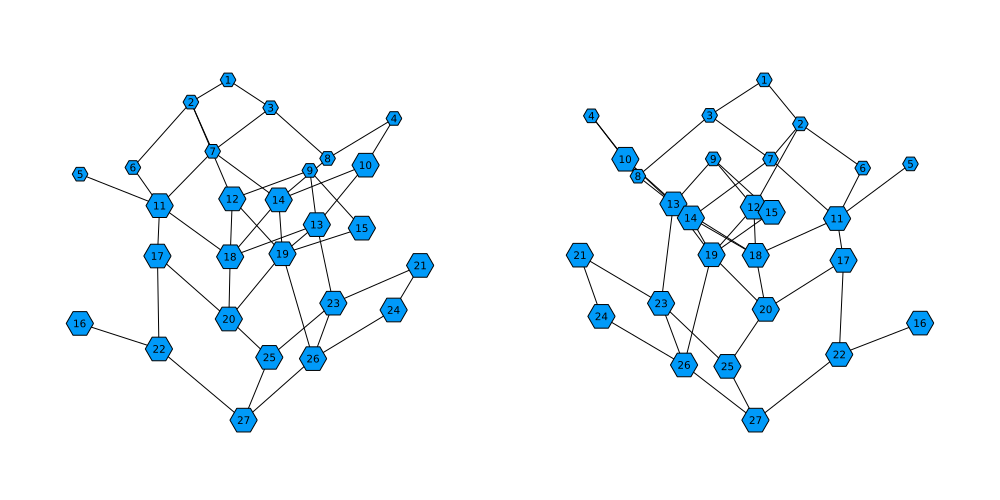

In [19]:
plot(datatograph1(D7s,3)[1],datatograph2(D7s,0.01)[1],size=(1000,500))

We calculate degenerations for webs in $\mathbb S^4$.

In [20]:
DW4s,PW4s=finddistances(JordanWebsS4,50)
#save PW4s

open("JWS4Ps.csv", "w") do io
           writedlm(io,PW4s)
end

  0.030392 seconds (26.50 k allocations: 12.059 MiB, 80.78% gc time)
distance squared from orbit of 1 to 1 is at most 1.6904428867639245e-16. 1 tries 
  0.163951 seconds (641.31 k allocations: 291.882 MiB, 19.70% gc time)
distance squared from orbit of 1 to 2 is at most 1.3201745607203392e-11. 1 tries 
 23.199938 seconds (94.70 M allocations: 42.080 GiB, 20.24% gc time)
distance squared from orbit of 1 to 3 is at most 0.500000000394917. 50 tries 
  0.568549 seconds (2.32 M allocations: 1.032 GiB, 21.01% gc time)
distance squared from orbit of 1 to 4 is at most 7.452597245907485e-10. 1 tries 
  0.527399 seconds (2.16 M allocations: 981.969 MiB, 21.03% gc time)
distance squared from orbit of 1 to 5 is at most 1.586386175318586e-8. 1 tries 
  0.504942 seconds (2.04 M allocations: 925.558 MiB, 19.48% gc time)
distance squared from orbit of 1 to 6 is at most 0.4999999999999999. 50 tries 
 25.943562 seconds (106.29 M allocations: 47.233 GiB, 20.51% gc time)
distance squared from orbit of 1 t

 12.787432 seconds (54.09 M allocations: 24.034 GiB, 21.46% gc time)
distance squared from orbit of 5 to 9 is at most 0.33333333333333576. 50 tries 
 26.544997 seconds (112.23 M allocations: 49.867 GiB, 21.35% gc time)
distance squared from orbit of 5 to 10 is at most 4.377696217345148e-6. 50 tries 
 15.120358 seconds (64.14 M allocations: 28.496 GiB, 21.34% gc time)
distance squared from orbit of 5 to 11 is at most 1.5000000000020508. 50 tries 
  0.512032 seconds (2.16 M allocations: 983.320 MiB, 21.30% gc time)
distance squared from orbit of 5 to 12 is at most 8.826729673522409e-9. 1 tries 

  0.563923 seconds (2.40 M allocations: 1.067 GiB, 20.81% gc time)
distance squared from orbit of 6 to 1 is at most 1.0. 50 tries 
  2.867093 seconds (11.93 M allocations: 5.300 GiB, 21.16% gc time)
distance squared from orbit of 6 to 2 is at most 1.0. 50 tries 
  1.237638 seconds (5.25 M allocations: 2.333 GiB, 21.30% gc time)
distance squared from orbit of 6 to 3 is at most 0.4999999999999999. 

  7.719288 seconds (32.79 M allocations: 14.569 GiB, 20.78% gc time)
distance squared from orbit of 10 to 6 is at most 1.000000000000385. 50 tries 
 10.815564 seconds (45.77 M allocations: 20.341 GiB, 20.86% gc time)
distance squared from orbit of 10 to 7 is at most 0.7736161775650159. 50 tries 
  0.990858 seconds (4.15 M allocations: 1.843 GiB, 20.84% gc time)
distance squared from orbit of 10 to 8 is at most 0.33333333333333354. 50 tries 
 11.841076 seconds (48.47 M allocations: 21.540 GiB, 20.66% gc time)
distance squared from orbit of 10 to 9 is at most 0.33333333333397647. 50 tries 
  0.014615 seconds (55.26 k allocations: 25.127 MiB)
distance squared from orbit of 10 to 10 is at most 1.2774210850590419e-15. 1 tries 
  5.709601 seconds (22.69 M allocations: 10.082 GiB, 20.91% gc time)
distance squared from orbit of 10 to 11 is at most 1.4999999999999998. 50 tries 
  8.726049 seconds (37.15 M allocations: 16.506 GiB, 20.54% gc time)
distance squared from orbit of 10 to 12 is at mos

revised distance squared from orbit of 3 to 10 is at most 8.319714701220834e-7. 
distance squared from orbit of 3 to 12 will be revised since for 3 5 12: 0.33333333333406157+8.826729673522409e-9<0.5000000000000047
revised distance squared from orbit of 3 to 12 is at most 0.5000000000000047. 
distance squared from orbit of 3 to 12 will be revised since for 3 8 12: 0.3333336751043995+7.893013483859424e-8<0.5000000000000047
revised distance squared from orbit of 3 to 12 is at most 0.5000000000000047. 
distance squared from orbit of 3 to 12 will be revised since for 3 9 12: 0.3333333333333401+8.708547156007589e-7<0.5000000000000047
revised distance squared from orbit of 3 to 12 is at most 0.5000000000000001. 

distance squared from orbit of 4 to 5 will be revised since for 4 2 5: 0.5000000000000002+2.2452804090361956e-7<0.5745033757762705
revised distance squared from orbit of 4 to 5 is at most 0.5745033757762705. 
distance squared from orbit of 4 to 7 will be revised since for 4 3 7: 0.50

revised distance squared from orbit of 12 to 10 is at most 0.7500000000000001. 
distance squared from orbit of 12 to 10 will be revised since for 12 8 10: 0.6666666666666671+9.516578198751493e-9<0.7500000000000001
revised distance squared from orbit of 12 to 10 is at most 0.7500000000000001. 

rechecked new distance squared from orbit of 1 to 1 is at most 1.3612367175669055e-16 old is 1.6904428867639245e-16. 
rechecked new distance squared from orbit of 1 to 4 is at most 1.2259746382076235e-10 old is 3.782286779706476e-10. 
rechecked better distance squared from orbit of 1 to 5 is at most 1.6071016196793103e-9 old is 1.586386175318586e-8. 
rechecked better distance squared from orbit of 1 to 7 is at most 0.5000000029692078 old is 0.5000000029693185. 
rechecked better distance squared from orbit of 1 to 8 is at most 4.1342773760222863e-7 old is 4.1499734706073344e-7. 
rechecked better distance squared from orbit of 1 to 10 is at most 6.549956696885046e-7 old is 6.588003615656136e-7. 
re

revised distance squared from orbit of 2 to 7 is at most 0.5000000012899515. 
distance squared from orbit of 2 to 10 will be revised since for 2 4 10: 2.630966947088636e-11+2.3148015018009487e-8<2.752334466766948e-7
revised distance squared from orbit of 2 to 10 is at most 2.752334466766948e-7. 
distance squared from orbit of 2 to 10 will be revised since for 2 8 10: 2.4006164004150595e-7+8.594618759372616e-10<2.752334466766948e-7
revised distance squared from orbit of 2 to 10 is at most 2.752334466766948e-7. 
distance squared from orbit of 2 to 11 will be revised since for 2 3 11: 0.5000000000000003+1.0000000001440434<1.5000000011096388
revised distance squared from orbit of 2 to 11 is at most 1.5000000011096388. 
distance squared from orbit of 2 to 11 will be revised since for 2 4 11: 2.630966947088636e-11+1.5000000003273195<1.5000000011096388
revised distance squared from orbit of 2 to 11 is at most 1.5000000011096388. 

distance squared from orbit of 3 to 1 will be revised since fo

revised distance squared from orbit of 10 to 12 is at most 0.5000000000000878. 
distance squared from orbit of 10 to 12 will be revised since for 10 9 12: 0.33333333333372517+4.727331073918969e-9<0.5000000000000878
revised distance squared from orbit of 10 to 12 is at most 0.5000000000000878. 

distance squared from orbit of 11 to 1 will be revised since for 11 9 1: 0.3333333333379797+1.0<1.5000000000000009
revised distance squared from orbit of 11 to 1 is at most 1.5000000000000009. 
distance squared from orbit of 11 to 5 will be revised since for 11 3 5: 0.500000000001107+0.33333333333406157<1.0000000000013234
revised distance squared from orbit of 11 to 5 is at most 1.0000000000013234. 
distance squared from orbit of 11 to 6 will be revised since for 11 9 6: 0.3333333333379797+0.5000000000000001<1.0000000000000537
revised distance squared from orbit of 11 to 6 is at most 1.000000000000044. 
distance squared from orbit of 11 to 7 will be revised since for 11 3 7: 0.500000000001107+3.

The following is the calculated Hasse Diagram for webs in $\mathbb{S}^4$.

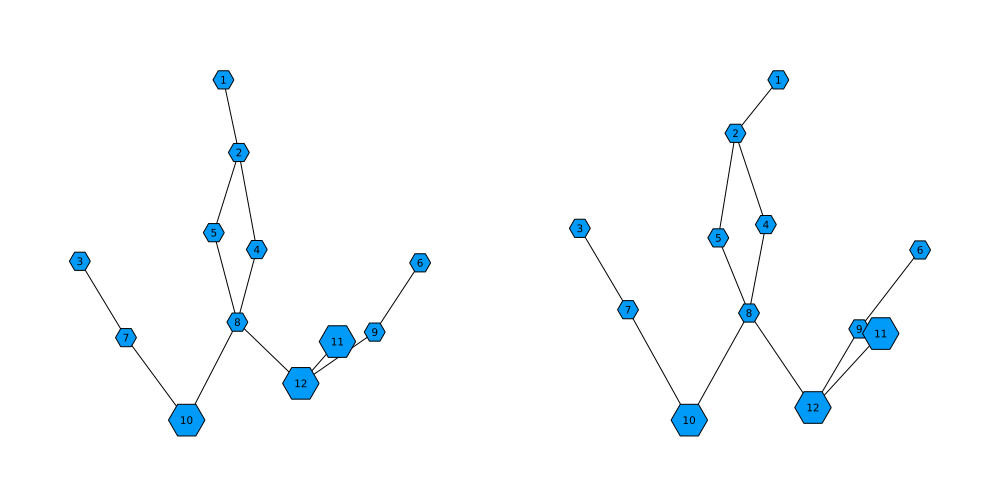

In [21]:
plot(datatograph1(DW4s,3)[1],datatograph2(DW4s,0.01)[1],size=(1000,500))
#round.(DW4s,digits=2)

We calculate degenerations for webs in $\mathbb S^5$.

In [22]:
DW5s,PW5s=finddistances(JordanWebsS5,50)
#save PW4s

open("JWS5Psnew.csv", "w") do io
           writedlm(io,PW5snew)
end

  0.012045 seconds (40.09 k allocations: 18.560 MiB)
distance squared from orbit of 1 to 1 is at most 1.109811132926366e-14. 1 tries 
  1.055690 seconds (4.04 M allocations: 1.823 GiB, 20.22% gc time)
distance squared from orbit of 1 to 2 is at most 4.094067759947357e-11. 3 tries 
  0.558416 seconds (2.17 M allocations: 1001.796 MiB, 21.18% gc time)
distance squared from orbit of 1 to 3 is at most 3.8319193021664773e-7. 1 tries 
 27.508114 seconds (110.96 M allocations: 50.073 GiB, 20.36% gc time)
distance squared from orbit of 1 to 4 is at most 0.33348888777628055. 50 tries 
  4.919569 seconds (19.68 M allocations: 8.880 GiB, 20.42% gc time)
distance squared from orbit of 1 to 5 is at most 1.0000000000000018. 50 tries 
 23.738876 seconds (94.64 M allocations: 42.714 GiB, 20.45% gc time)
distance squared from orbit of 1 to 6 is at most 0.3333333412476914. 50 tries 
  1.112581 seconds (4.48 M allocations: 2.021 GiB, 20.30% gc time)
distance squared from orbit of 1 to 7 is at most 1.0345

  1.494761 seconds (5.83 M allocations: 2.632 GiB, 20.73% gc time)
distance squared from orbit of 3 to 13 is at most 0.666666666666668. 50 tries 
 30.931928 seconds (116.08 M allocations: 52.387 GiB, 20.66% gc time)
distance squared from orbit of 3 to 14 is at most 0.3363467588015695. 50 tries 
 31.145316 seconds (113.97 M allocations: 51.433 GiB, 20.48% gc time)
distance squared from orbit of 3 to 15 is at most 2.349302448215903e-5. 50 tries 
 28.790455 seconds (113.42 M allocations: 51.183 GiB, 20.57% gc time)
distance squared from orbit of 3 to 16 is at most 1.4466555944556153e-6. 50 tries 
 28.960727 seconds (113.51 M allocations: 51.224 GiB, 20.59% gc time)
distance squared from orbit of 3 to 17 is at most 9.5021770136228e-5. 50 tries 
 31.192950 seconds (106.33 M allocations: 47.989 GiB, 19.40% gc time)
distance squared from orbit of 3 to 18 is at most 0.3362358931384372. 50 tries 
 20.008697 seconds (80.14 M allocations: 36.166 GiB, 20.61% gc time)
distance squared from orbit of

  7.497512 seconds (30.44 M allocations: 13.742 GiB, 19.93% gc time)
distance squared from orbit of 6 to 2 is at most 0.8750000000249685. 50 tries 
 10.042166 seconds (40.18 M allocations: 18.133 GiB, 19.67% gc time)
distance squared from orbit of 6 to 3 is at most 1.1111111111111174. 50 tries 
 27.746523 seconds (110.02 M allocations: 49.642 GiB, 19.66% gc time)
distance squared from orbit of 6 to 4 is at most 0.3333386452858914. 50 tries 
  5.824955 seconds (22.43 M allocations: 10.123 GiB, 19.02% gc time)
distance squared from orbit of 6 to 5 is at most 1.5000000000000024. 50 tries 
  0.013523 seconds (69.65 k allocations: 32.179 MiB)
distance squared from orbit of 6 to 6 is at most 4.214650422274438e-13. 1 tries 
 18.947572 seconds (76.55 M allocations: 34.551 GiB, 19.50% gc time)
distance squared from orbit of 6 to 7 is at most 0.33333333333442133. 50 tries 
  8.165007 seconds (32.93 M allocations: 14.865 GiB, 19.64% gc time)
distance squared from orbit of 6 to 8 is at most 0.5000

 21.857249 seconds (90.48 M allocations: 40.835 GiB, 19.73% gc time)
distance squared from orbit of 8 to 14 is at most 0.33333347556975806. 50 tries 
 26.565928 seconds (111.16 M allocations: 50.157 GiB, 19.67% gc time)
distance squared from orbit of 8 to 15 is at most 3.0484876238879996e-5. 50 tries 
  0.557264 seconds (2.34 M allocations: 1.054 GiB, 18.58% gc time)
distance squared from orbit of 8 to 16 is at most 9.507625444732163e-7. 1 tries 
  0.585250 seconds (2.34 M allocations: 1.057 GiB, 19.35% gc time)
distance squared from orbit of 8 to 17 is at most 5.20510983144151e-7. 1 tries 
 25.482114 seconds (104.03 M allocations: 46.944 GiB, 19.33% gc time)
distance squared from orbit of 8 to 18 is at most 0.3333333481505819. 50 tries 
 16.010952 seconds (63.05 M allocations: 28.451 GiB, 19.13% gc time)
distance squared from orbit of 8 to 19 is at most 0.2500000000000079. 50 tries 
 30.448003 seconds (118.35 M allocations: 53.418 GiB, 18.82% gc time)
distance squared from orbit of 8 

 10.313144 seconds (40.22 M allocations: 18.152 GiB, 21.59% gc time)
distance squared from orbit of 11 to 3 is at most 0.8128137886229868. 50 tries 
 28.923142 seconds (107.69 M allocations: 48.599 GiB, 20.94% gc time)
distance squared from orbit of 11 to 4 is at most 0.20000049195681077. 50 tries 
 15.266192 seconds (55.89 M allocations: 25.220 GiB, 20.37% gc time)
distance squared from orbit of 11 to 5 is at most 0.5000000000000029. 50 tries 
  5.938407 seconds (22.26 M allocations: 10.050 GiB, 20.82% gc time)
distance squared from orbit of 11 to 6 is at most 0.345226763716213. 50 tries 
 24.108972 seconds (92.37 M allocations: 41.684 GiB, 20.99% gc time)
distance squared from orbit of 11 to 7 is at most 0.5000000000040467. 50 tries 
 24.810805 seconds (93.38 M allocations: 42.136 GiB, 20.86% gc time)
distance squared from orbit of 11 to 8 is at most 0.2500000002618472. 50 tries 
  8.793074 seconds (33.26 M allocations: 15.013 GiB, 20.56% gc time)
distance squared from orbit of 11 to

  3.059516 seconds (11.78 M allocations: 5.317 GiB, 20.57% gc time)
distance squared from orbit of 13 to 14 is at most 0.9791666666666733. 50 tries 
 27.938188 seconds (112.14 M allocations: 50.602 GiB, 20.65% gc time)
distance squared from orbit of 13 to 15 is at most 0.6666668387678575. 50 tries 
  6.048043 seconds (24.35 M allocations: 10.991 GiB, 20.56% gc time)
distance squared from orbit of 13 to 16 is at most 0.8000000000001963. 50 tries 
 11.149486 seconds (44.94 M allocations: 20.284 GiB, 20.62% gc time)
distance squared from orbit of 13 to 17 is at most 1.0000000000002358. 50 tries 
  2.930431 seconds (11.84 M allocations: 5.344 GiB, 20.84% gc time)
distance squared from orbit of 13 to 18 is at most 0.8750000000000041. 50 tries 
  0.580359 seconds (2.34 M allocations: 1.056 GiB, 20.67% gc time)
distance squared from orbit of 13 to 19 is at most 4.4157722321110576e-7. 1 tries 
  1.618880 seconds (6.52 M allocations: 2.943 GiB, 20.80% gc time)
distance squared from orbit of 13 

  9.754919 seconds (39.79 M allocations: 17.958 GiB, 20.18% gc time)
distance squared from orbit of 16 to 3 is at most 0.8333333333413049. 50 tries 
 25.837675 seconds (102.56 M allocations: 46.291 GiB, 19.46% gc time)
distance squared from orbit of 16 to 4 is at most 0.3333414531122619. 50 tries 
  5.296219 seconds (21.05 M allocations: 9.501 GiB, 19.01% gc time)
distance squared from orbit of 16 to 5 is at most 1.5000000000000129. 50 tries 
  8.257027 seconds (32.33 M allocations: 14.592 GiB, 19.23% gc time)
distance squared from orbit of 16 to 6 is at most 0.6666666666666715. 50 tries 
  6.597988 seconds (25.82 M allocations: 11.651 GiB, 19.14% gc time)
distance squared from orbit of 16 to 7 is at most 0.500000000000006. 50 tries 
  5.062048 seconds (19.44 M allocations: 8.774 GiB, 19.21% gc time)
distance squared from orbit of 16 to 8 is at most 0.25000000000000844. 50 tries 
 23.429134 seconds (92.39 M allocations: 41.705 GiB, 19.37% gc time)
distance squared from orbit of 16 to 9

  3.628088 seconds (14.70 M allocations: 6.634 GiB, 19.95% gc time)
distance squared from orbit of 18 to 14 is at most 0.3333333333335715. 50 tries 
 27.615282 seconds (112.23 M allocations: 50.648 GiB, 19.74% gc time)
distance squared from orbit of 18 to 15 is at most 0.20000414842400902. 50 tries 
  8.077441 seconds (32.68 M allocations: 14.745 GiB, 19.97% gc time)
distance squared from orbit of 18 to 16 is at most 0.40000001565328136. 50 tries 
  8.458371 seconds (34.18 M allocations: 15.424 GiB, 19.89% gc time)
distance squared from orbit of 18 to 17 is at most 0.5000000000000026. 50 tries 
  0.011373 seconds (57.64 k allocations: 26.634 MiB)
distance squared from orbit of 18 to 18 is at most 1.3568415027580166e-13. 1 tries 
  5.041248 seconds (20.36 M allocations: 9.186 GiB, 20.15% gc time)
distance squared from orbit of 18 to 19 is at most 0.250000000000004. 50 tries 
 28.998577 seconds (117.10 M allocations: 52.851 GiB, 19.92% gc time)
distance squared from orbit of 18 to 20 is 

 12.175999 seconds (49.31 M allocations: 22.256 GiB, 19.49% gc time)
distance squared from orbit of 21 to 3 is at most 1.3148148148424488. 50 tries 
  1.369639 seconds (5.55 M allocations: 2.506 GiB, 19.37% gc time)
distance squared from orbit of 21 to 4 is at most 0.33333333333334575. 50 tries 
 11.718990 seconds (48.02 M allocations: 21.671 GiB, 19.32% gc time)
distance squared from orbit of 21 to 5 is at most 1.500000000006825. 50 tries 
 12.575547 seconds (52.86 M allocations: 23.861 GiB, 19.57% gc time)
distance squared from orbit of 21 to 6 is at most 0.6458333333358504. 50 tries 
  6.709414 seconds (27.54 M allocations: 12.433 GiB, 19.45% gc time)
distance squared from orbit of 21 to 7 is at most 0.9874912447228587. 50 tries 
 20.766951 seconds (84.99 M allocations: 38.363 GiB, 19.59% gc time)
distance squared from orbit of 21 to 8 is at most 0.9375000000054005. 50 tries 
 12.856633 seconds (52.54 M allocations: 23.715 GiB, 19.50% gc time)
distance squared from orbit of 21 to 9 

revised distance squared from orbit of 1 to 20 is at most 2.051456774175498e-5. 
distance squared from orbit of 1 to 20 will be revised since for 1 9 20: 1.3878658757248452e-7+8.173923814405148e-7<2.051456774175498e-5
revised distance squared from orbit of 1 to 20 is at most 9.357243705185978e-6. 
distance squared from orbit of 1 to 20 will be revised since for 1 15 20: 4.078980220252395e-6+5.946380520562365e-8<9.357243705185978e-6
revised distance squared from orbit of 1 to 20 is at most 9.357243705185978e-6. 
distance squared from orbit of 1 to 21 will be revised since for 1 2 21: 4.094067759947357e-11+5.771360581426329e-5<9.59577813112997e-5
revised distance squared from orbit of 1 to 21 is at most 5.609234710568275e-5. 
distance squared from orbit of 1 to 21 will be revised since for 1 7 21: 1.034554570360594e-7+2.6809079016377847e-6<5.609234710568275e-5
revised distance squared from orbit of 1 to 21 is at most 3.0626299630403434e-6. 

distance squared from orbit of 2 to 4 will be 

revised distance squared from orbit of 3 to 21 is at most 0.0001599811150533404. 
distance squared from orbit of 3 to 21 will be revised since for 3 15 21: 2.349302448215903e-5+8.604343995575701e-5<0.0001599811150533404
revised distance squared from orbit of 3 to 21 is at most 0.0001599811150533404. 
distance squared from orbit of 3 to 21 will be revised since for 3 16 21: 1.4466555944556153e-6+1.9107249097988013e-5<0.0001599811150533404
revised distance squared from orbit of 3 to 21 is at most 8.771084800924832e-5. 
distance squared from orbit of 3 to 21 will be revised since for 3 17 21: 1.5371870306593515e-5+3.9794982397571155e-5<8.771084800924832e-5
revised distance squared from orbit of 3 to 21 is at most 8.771084800924832e-5. 
distance squared from orbit of 3 to 21 will be revised since for 3 20 21: 8.362002531402511e-7+7.206985143597535e-7<8.771084800924832e-5
revised distance squared from orbit of 3 to 21 is at most 8.771084800924832e-5. 
distance squared from orbit of 3 to 22 

revised distance squared from orbit of 6 to 3 is at most 1.1111111111111174. 
distance squared from orbit of 6 to 3 will be revised since for 6 8 3: 0.5000000000000127+0.33333333333557147<1.1111111111111174
revised distance squared from orbit of 6 to 3 is at most 1.1111111111111174. 
distance squared from orbit of 6 to 3 will be revised since for 6 12 3: 0.33333333333334086+0.3333333333470999<1.1111111111111174
revised distance squared from orbit of 6 to 3 is at most 1.1111111111111174. 
distance squared from orbit of 6 to 4 will be revised since for 6 21 4: 1.3414072432615764e-6+0.33333333333334575<0.3333386452858914
revised distance squared from orbit of 6 to 4 is at most 0.3333341899723501. 
distance squared from orbit of 6 to 5 will be revised since for 6 12 5: 0.33333333333334086+1.0000000000000022<1.5000000000000024
revised distance squared from orbit of 6 to 5 is at most 1.5000000000000024. 
distance squared from orbit of 6 to 9 will be revised since for 6 4 9: 0.333334189972350

revised distance squared from orbit of 8 to 4 is at most 0.33340266744474883. 
distance squared from orbit of 8 to 4 will be revised since for 8 17 4: 5.20510983144151e-7+0.3333858822869955<0.33340266744474883
revised distance squared from orbit of 8 to 4 is at most 0.33334789222172306. 
distance squared from orbit of 8 to 9 will be revised since for 8 3 9: 0.33333333333557147+1.8001371196911488e-11<0.33333353251790143
revised distance squared from orbit of 8 to 9 is at most 0.33333336176530615. 
distance squared from orbit of 8 to 10 will be revised since for 8 3 10: 0.33333333333557147+4.84112647998051e-7<0.5000000000006879
revised distance squared from orbit of 8 to 10 is at most 0.5000000000006879. 
distance squared from orbit of 8 to 13 will be revised since for 8 19 13: 0.2500000000000079+0.3333333333333356<0.6666666666666701
revised distance squared from orbit of 8 to 13 is at most 0.6666666666666701. 
distance squared from orbit of 8 to 18 will be revised since for 8 12 18: 0.3

revised distance squared from orbit of 10 to 12 is at most 0.5000057620510233. 
distance squared from orbit of 10 to 13 will be revised since for 10 19 13: 0.2500149549098285+0.3333333333333356<0.666666666666668
revised distance squared from orbit of 10 to 13 is at most 0.666666666666668. 
distance squared from orbit of 10 to 14 will be revised since for 10 17 14: 3.324980915900516e-8+0.33333333633267986<0.3333337175456291
revised distance squared from orbit of 10 to 14 is at most 0.3333337175456291. 
distance squared from orbit of 10 to 15 will be revised since for 10 17 15: 3.324980915900516e-8+0.20000028897884967<0.200001776352391
revised distance squared from orbit of 10 to 15 is at most 0.20000019840513464. 
distance squared from orbit of 10 to 18 will be revised since for 10 17 18: 3.324980915900516e-8+0.33333333613147487<0.33333453865869545
revised distance squared from orbit of 10 to 18 is at most 0.33333453865869545. 
distance squared from orbit of 10 to 19 will be revised sin

revised distance squared from orbit of 12 to 15 is at most 0.2000014049050479. 
distance squared from orbit of 12 to 20 will be revised since for 12 18 20: 1.3748689144095614e-9+3.610274603100392e-6<0.0001040704589115363
revised distance squared from orbit of 12 to 20 is at most 1.055847066840736e-5. 
distance squared from orbit of 12 to 21 will be revised since for 12 16 21: 1.5265731641837333e-6+1.9107249097988013e-5<0.00273868200482568
revised distance squared from orbit of 12 to 21 is at most 0.00022589395877515564. 
distance squared from orbit of 12 to 21 will be revised since for 12 20 21: 1.055847066840736e-5+7.206985143597535e-7<0.00022589395877515564
revised distance squared from orbit of 12 to 21 is at most 0.00022589395877515564. 

distance squared from orbit of 13 to 3 will be revised since for 13 12 3: 0.500000000000003+0.3333333333470999<1.0000000000000062
revised distance squared from orbit of 13 to 3 is at most 1.0000000000000062. 
distance squared from orbit of 13 to 4

revised distance squared from orbit of 14 to 9 is at most 0.8750000000000151. 
distance squared from orbit of 14 to 9 will be revised since for 14 8 9: 0.5000000000000104+0.33333336176530615<0.8750000000000151
revised distance squared from orbit of 14 to 9 is at most 0.8750000000000151. 
distance squared from orbit of 14 to 9 will be revised since for 14 12 9: 0.33333333333336096+0.33333338835317483<0.8750000000000151
revised distance squared from orbit of 14 to 9 is at most 0.8750000000000151. 
distance squared from orbit of 14 to 10 will be revised since for 14 4 10: 0.33333750803063983+0.5000036088207991<1.0000000000000058
revised distance squared from orbit of 14 to 10 is at most 1.0000000000000058. 
distance squared from orbit of 14 to 10 will be revised since for 14 12 10: 0.33333333333336096+0.500000000001394<1.0000000000000058
revised distance squared from orbit of 14 to 10 is at most 1.0000000000000058. 
distance squared from orbit of 14 to 13 will be revised since for 14 19 1

revised distance squared from orbit of 15 to 16 is at most 0.4000000000089977. 
distance squared from orbit of 15 to 17 will be revised since for 15 8 17: 0.25000001979360914+5.20510983144151e-7<0.5000000018655709
revised distance squared from orbit of 15 to 17 is at most 0.5000000018655709. 
distance squared from orbit of 15 to 18 will be revised since for 15 12 18: 0.3333341856786552+1.3748689144095614e-9<0.33596054154881705
revised distance squared from orbit of 15 to 18 is at most 0.3336141480582339. 
distance squared from orbit of 15 to 18 will be revised since for 15 20 18: 5.946380520562365e-8+0.3333368117235279<0.3336141480582339
revised distance squared from orbit of 15 to 18 is at most 0.33353085969505636. 
distance squared from orbit of 15 to 18 will be revised since for 15 21 18: 8.604343995575701e-5+0.33333333333527587<0.33353085969505636
revised distance squared from orbit of 15 to 18 is at most 0.33353085969505636. 
distance squared from orbit of 15 to 21 will be revised

revised distance squared from orbit of 18 to 3 is at most 0.8333333333333707. 
distance squared from orbit of 18 to 3 will be revised since for 18 8 3: 0.2500000033117721+0.33333333333557147<0.8333333333333707
revised distance squared from orbit of 18 to 3 is at most 0.8333333333333707. 
distance squared from orbit of 18 to 3 will be revised since for 18 12 3: 0.33494313493247496+0.3333333333470999<0.8333333333333707
revised distance squared from orbit of 18 to 3 is at most 0.8333333333333707. 
distance squared from orbit of 18 to 4 will be revised since for 18 20 4: 3.610274603100392e-6+0.3333338057196087<0.3345389432484799
revised distance squared from orbit of 18 to 4 is at most 0.3345389432484799. 
distance squared from orbit of 18 to 6 will be revised since for 18 20 6: 3.610274603100392e-6+0.3333333333365662<0.3346179476181265
revised distance squared from orbit of 18 to 6 is at most 0.33442613164529983. 
distance squared from orbit of 18 to 9 will be revised since for 18 4 9: 0.

revised distance squared from orbit of 20 to 1 is at most 1.5000000000000062. 
distance squared from orbit of 20 to 1 will be revised since for 20 12 1: 0.3333333333369671+0.8333333333391154<1.5000000000000062
revised distance squared from orbit of 20 to 1 is at most 1.5000000000000062. 
distance squared from orbit of 20 to 1 will be revised since for 20 15 1: 0.33333333333334175+1.0000000000000049<1.5000000000000062
revised distance squared from orbit of 20 to 1 is at most 1.5000000000000062. 
distance squared from orbit of 20 to 1 will be revised since for 20 18 1: 0.3333368117235279+1.0000000000000044<1.5000000000000062
revised distance squared from orbit of 20 to 1 is at most 1.5000000000000062. 
distance squared from orbit of 20 to 1 will be revised since for 20 19 1: 0.5000000000000033+1.0000000000000013<1.5000000000000062
revised distance squared from orbit of 20 to 1 is at most 1.5000000000000062. 
distance squared from orbit of 20 to 2 will be revised since for 20 4 2: 0.33333

revised distance squared from orbit of 21 to 2 is at most 1.0000000000000036. 
distance squared from orbit of 21 to 3 will be revised since for 21 4 3: 0.33333333333334575+0.33334051830304295<1.3148148148424488
revised distance squared from orbit of 21 to 3 is at most 1.3148148148424488. 
distance squared from orbit of 21 to 3 will be revised since for 21 8 3: 0.9375000000054005+0.33333333333557147<1.3148148148424488
revised distance squared from orbit of 21 to 3 is at most 1.3148148148424488. 
distance squared from orbit of 21 to 3 will be revised since for 21 12 3: 0.7083333333362949+0.3333333333470999<1.3148148148424488
revised distance squared from orbit of 21 to 3 is at most 1.3148148148424488. 
distance squared from orbit of 21 to 3 will be revised since for 21 18 3: 0.33333333333527587+0.8333333333333707<1.3148148148424488
revised distance squared from orbit of 21 to 3 is at most 1.3148148148424488. 
distance squared from orbit of 21 to 3 will be revised since for 21 20 3: 0.200

revised distance squared from orbit of 21 to 22 is at most 0.6000000000000035. 
distance squared from orbit of 21 to 22 will be revised since for 21 15 22: 0.5169141908353714+5.5132868163977015e-8<0.6000000000000035
revised distance squared from orbit of 21 to 22 is at most 0.6000000000000035. 
distance squared from orbit of 21 to 22 will be revised since for 21 18 22: 0.33333333333527587+4.6030564285690235e-5<0.6000000000000035
revised distance squared from orbit of 21 to 22 is at most 0.6000000000000035. 
distance squared from orbit of 21 to 22 will be revised since for 21 19 22: 0.5000000000000073+3.2766039796357316e-7<0.6000000000000035
revised distance squared from orbit of 21 to 22 is at most 0.6000000000000035. 

distance squared from orbit of 22 to 3 will be revised since for 22 12 3: 0.5000000000000033+0.3333333333470999<1.0000000000000036
revised distance squared from orbit of 22 to 3 is at most 1.0000000000000036. 
distance squared from orbit of 22 to 4 will be revised since

rechecked new distance squared from orbit of 2 to 18 is at most 0.33333333420552214 old is 0.3333333353710921. 
rechecked better distance squared from orbit of 2 to 18 is at most 0.33333333420265165 old is 0.33333333420552214. 
rechecked better distance squared from orbit of 2 to 19 is at most 0.2500000584541998 old is 0.2500000824270371. 
rechecked better distance squared from orbit of 2 to 20 is at most 2.1151256615848048e-6 old is 2.1151937372752664e-6. 
rechecked better distance squared from orbit of 2 to 21 is at most 2.976679538530771e-6 old is 2.9766895730188965e-6. 
rechecked better distance squared from orbit of 2 to 22 is at most 2.988500734253775e-8 old is 8.977493452662758e-7. 
rechecked better distance squared from orbit of 3 to 4 is at most 0.33340539366189076 old is 0.333405421393464. 
rechecked better distance squared from orbit of 3 to 5 is at most 1.0000000033719498 old is 1.0000000180333952. 
rechecked better distance squared from orbit of 3 to 6 is at most 0.3333475

rechecked better distance squared from orbit of 7 to 20 is at most 3.411114894801218e-5 old is 5.9302433053413125e-5. 
rechecked better distance squared from orbit of 7 to 21 is at most 1.607851061821382e-6 old is 2.6809079016377847e-6. 
rechecked better distance squared from orbit of 7 to 22 is at most 3.553348000672683e-7 old is 9.266767505538992e-7. 
rechecked better distance squared from orbit of 8 to 2 is at most 0.5000000000091405 old is 0.5000000000164387. 
rechecked better distance squared from orbit of 8 to 3 is at most 0.3333333333346109 old is 0.33333333333557147. 
rechecked better distance squared from orbit of 8 to 4 is at most 0.3333432139919103 old is 0.33334789222172306. 
rechecked better distance squared from orbit of 8 to 6 is at most 0.3333333359451907 old is 0.33333333656273734. 
rechecked better distance squared from orbit of 8 to 9 is at most 0.33333333453214503 old is 0.33333336176530615. 
rechecked better distance squared from orbit of 8 to 10 is at most 0.50000

rechecked better distance squared from orbit of 12 to 16 is at most 6.524694289123085e-7 old is 1.5265731641837333e-6. 
rechecked better distance squared from orbit of 12 to 17 is at most 0.2500000000003948 old is 0.2500000000012774. 
rechecked better distance squared from orbit of 12 to 18 is at most 1.3264135471619084e-9 old is 1.3748689144095614e-9. 
rechecked better distance squared from orbit of 12 to 20 is at most 8.705884449257095e-6 old is 1.055847066840736e-5. 
rechecked better distance squared from orbit of 12 to 21 is at most 0.00016172425343563882 old is 0.00022589395877515564. 
rechecked better distance squared from orbit of 12 to 22 is at most 8.858214699172528e-7 old is 9.948924813705813e-7. 
rechecked new distance squared from orbit of 13 to 13 is at most 6.055530603529431e-13 old is 1.1090389342952386e-12. 
rechecked better distance squared from orbit of 13 to 15 is at most 0.6666667709114448 old is 0.6666668387678575. 
rechecked better distance squared from orbit of 1

rechecked better distance squared from orbit of 20 to 11 is at most 1.000000000151847 old is 1.0000000010954797. 
rechecked better distance squared from orbit of 20 to 12 is at most 0.33333333333691884 old is 0.3333333333369671. 
rechecked better distance squared from orbit of 20 to 14 is at most 0.3333337977438183 old is 0.3333338043940591. 
rechecked better distance squared from orbit of 20 to 17 is at most 0.5000000002276626 old is 0.5000000044919142. 
rechecked better distance squared from orbit of 20 to 21 is at most 6.461700369955103e-7 old is 7.206985143597535e-7. 
rechecked better distance squared from orbit of 21 to 6 is at most 0.6458333333347999 old is 0.6458333333358504. 
rechecked better distance squared from orbit of 21 to 11 is at most 1.000000000004738 old is 1.0000000000063238. 
rechecked better distance squared from orbit of 21 to 14 is at most 0.3333333333344813 old is 0.33333333333482423. 
rechecked better distance squared from orbit of 21 to 18 is at most 0.3333333

revised distance squared from orbit of 3 to 21 is at most 8.761948868678227e-5. 
distance squared from orbit of 3 to 21 will be revised since for 3 17 21: 1.0026084030975109e-6+1.3150328336319726e-5<8.761948868678227e-5
revised distance squared from orbit of 3 to 21 is at most 8.761948868678227e-5. 
distance squared from orbit of 3 to 21 will be revised since for 3 20 21: 6.704337675085366e-7+6.461700369955103e-7<8.761948868678227e-5
revised distance squared from orbit of 3 to 21 is at most 8.761948868678227e-5. 
distance squared from orbit of 3 to 22 will be revised since for 3 9 22: 1.8001371196911488e-11+3.804624240464907e-8<6.897832164666486e-7
revised distance squared from orbit of 3 to 22 is at most 5.053192322423709e-8. 

distance squared from orbit of 4 to 1 will be revised since for 4 3 1: 0.33333725544135284+0.5000000000000012<0.8334046367151529
revised distance squared from orbit of 4 to 1 is at most 0.8334046367151529. 
distance squared from orbit of 4 to 5 will be revised 

revised distance squared from orbit of 6 to 3 is at most 1.1111111111111174. 
distance squared from orbit of 6 to 3 will be revised since for 6 8 3: 0.5000000000000127+0.3333333333346109<1.1111111111111174
revised distance squared from orbit of 6 to 3 is at most 1.1111111111111174. 
distance squared from orbit of 6 to 3 will be revised since for 6 12 3: 0.33333333333334086+0.33333333334709964<1.1111111111111174
revised distance squared from orbit of 6 to 3 is at most 1.1111111111111174. 
distance squared from orbit of 6 to 5 will be revised since for 6 12 5: 0.33333333333334086+1.0000000000000022<1.5000000000000024
revised distance squared from orbit of 6 to 5 is at most 1.5000000000000024. 
distance squared from orbit of 6 to 9 will be revised since for 6 2 9: 0.8750000000191027+9.93830870855646e-8<0.8750001738324654
revised distance squared from orbit of 6 to 9 is at most 0.8750001738324654. 
distance squared from orbit of 6 to 9 will be revised since for 6 4 9: 0.33333409219124455+0

revised distance squared from orbit of 8 to 4 is at most 0.3333432139919103. 
distance squared from orbit of 8 to 4 will be revised since for 8 21 4: 6.963676781960129e-6+0.33333333333334575<0.3333432139919103
revised distance squared from orbit of 8 to 4 is at most 0.333342179643029. 
distance squared from orbit of 8 to 9 will be revised since for 8 3 9: 0.3333333333346109+1.8001371196911488e-11<0.33333333453214503
revised distance squared from orbit of 8 to 9 is at most 0.33333333453214503. 
distance squared from orbit of 8 to 10 will be revised since for 8 3 10: 0.3333333333346109+1.7194489865487187e-9<0.5000000000003667
revised distance squared from orbit of 8 to 10 is at most 0.5000000000003667. 
distance squared from orbit of 8 to 13 will be revised since for 8 19 13: 0.2500000000000079+0.3333333333333356<0.6666666666666701
revised distance squared from orbit of 8 to 13 is at most 0.6666666666666701. 
distance squared from orbit of 8 to 18 will be revised since for 8 12 18: 0.333

revised distance squared from orbit of 10 to 14 is at most 0.3333334353504338. 
distance squared from orbit of 10 to 18 will be revised since for 10 17 18: 1.5320161556870528e-8+0.33333333613147487<0.3333336642606296
revised distance squared from orbit of 10 to 18 is at most 0.3333336642606296. 
distance squared from orbit of 10 to 19 will be revised since for 10 17 19: 1.5320161556870528e-8+0.25000815537766846<0.25001153670945425
revised distance squared from orbit of 10 to 19 is at most 0.25001153670945425. 
distance squared from orbit of 10 to 19 will be revised since for 10 22 19: 1.0672503463607808e-5+0.25000000000000144<0.25001153670945425
revised distance squared from orbit of 10 to 19 is at most 0.2500115366424111. 
distance squared from orbit of 10 to 20 will be revised since for 10 15 20: 0.20000016608164245+1.4138063419312197e-8<0.20000020429701984
revised distance squared from orbit of 10 to 20 is at most 0.20000020429701984. 
distance squared from orbit of 10 to 20 will be

revised distance squared from orbit of 13 to 14 is at most 0.9791666666666733. 
distance squared from orbit of 13 to 14 will be revised since for 13 12 14: 0.500000000000003+0.33333333398724946<0.9791666666666733
revised distance squared from orbit of 13 to 14 is at most 0.9791666666666733. 
distance squared from orbit of 13 to 15 will be revised since for 13 22 15: 5.270052935793376e-8+0.6666666666666725<0.6666667709114448
revised distance squared from orbit of 13 to 15 is at most 0.6666666720173545. 
distance squared from orbit of 13 to 16 will be revised since for 13 8 16: 0.7500000000001662+7.354209272564662e-7<0.8000000000001963
revised distance squared from orbit of 13 to 16 is at most 0.8000000000001963. 
distance squared from orbit of 13 to 16 will be revised since for 13 12 16: 0.500000000000003+6.524694289123085e-7<0.8000000000001963
revised distance squared from orbit of 13 to 16 is at most 0.8000000000001963. 
distance squared from orbit of 13 to 17 will be revised since fo

revised distance squared from orbit of 14 to 16 is at most 0.6000000000000109. 
distance squared from orbit of 14 to 22 will be revised since for 14 4 22: 0.3333355582315921+3.818371962564866e-5<0.6000000000000043
revised distance squared from orbit of 14 to 22 is at most 0.6000000000000043. 
distance squared from orbit of 14 to 22 will be revised since for 14 8 22: 0.5000000000000104+2.0716241617581967e-7<0.6000000000000043
revised distance squared from orbit of 14 to 22 is at most 0.6000000000000043. 
distance squared from orbit of 14 to 22 will be revised since for 14 12 22: 0.33333333333334664+8.858214699172528e-7<0.6000000000000043
revised distance squared from orbit of 14 to 22 is at most 0.6000000000000043. 
distance squared from orbit of 14 to 22 will be revised since for 14 15 22: 0.3333372782166444+7.735745003300851e-9<0.6000000000000043
revised distance squared from orbit of 14 to 22 is at most 0.6000000000000043. 
distance squared from orbit of 14 to 22 will be revised sinc

revised distance squared from orbit of 16 to 3 is at most 0.8333333333369737. 
distance squared from orbit of 16 to 3 will be revised since for 16 8 3: 0.25000000000000844+0.3333333333346109<0.8333333333369737
revised distance squared from orbit of 16 to 3 is at most 0.8333333333369737. 
distance squared from orbit of 16 to 3 will be revised since for 16 9 3: 0.3333333333409176+0.3333333333333388<0.8333333333369737
revised distance squared from orbit of 16 to 3 is at most 0.8333333333369737. 
distance squared from orbit of 16 to 5 will be revised since for 16 8 5: 0.25000000000000844+1.0000000000000089<1.5000000000000129
revised distance squared from orbit of 16 to 5 is at most 1.5000000000000129. 
distance squared from orbit of 16 to 6 will be revised since for 16 8 6: 0.25000000000000844+0.3333333359451907<0.6458344751826144
revised distance squared from orbit of 16 to 6 is at most 0.6458344751826144. 
distance squared from orbit of 16 to 6 will be revised since for 16 15 6: 0.200000

revised distance squared from orbit of 18 to 12 is at most 0.333482366205354. 
distance squared from orbit of 18 to 13 will be revised since for 18 19 13: 0.250000000000004+0.3333333333333356<0.6666666666666701
revised distance squared from orbit of 18 to 13 is at most 0.6666666666666701. 
distance squared from orbit of 18 to 16 will be revised since for 18 4 16: 0.33416950821356234+0.00014028921801070949<0.40000001557008413
revised distance squared from orbit of 18 to 16 is at most 0.40000001557008413. 
distance squared from orbit of 18 to 16 will be revised since for 18 8 16: 0.25000000317027726+7.354209272564662e-7<0.40000001557008413
revised distance squared from orbit of 18 to 16 is at most 0.40000001557008413. 
distance squared from orbit of 18 to 16 will be revised since for 18 12 16: 0.333482366205354+6.524694289123085e-7<0.40000001557008413
revised distance squared from orbit of 18 to 16 is at most 0.40000001557008413. 
distance squared from orbit of 18 to 17 will be revised s

revised distance squared from orbit of 20 to 7 is at most 0.8333333333351695. 
distance squared from orbit of 20 to 9 will be revised since for 20 4 9: 0.3333336240403301+0.3333452941558319<1.0000000000000084
revised distance squared from orbit of 20 to 9 is at most 1.0000000000000084. 
distance squared from orbit of 20 to 9 will be revised since for 20 8 9: 0.500000000112487+0.33333333453214503<1.0000000000000084
revised distance squared from orbit of 20 to 9 is at most 1.0000000000000084. 
distance squared from orbit of 20 to 9 will be revised since for 20 12 9: 0.33333333333691884+0.3333333486574222<1.0000000000000084
revised distance squared from orbit of 20 to 9 is at most 1.0000000000000084. 
distance squared from orbit of 20 to 9 will be revised since for 20 16 9: 0.6000000000151852+0.3333333333409176<1.0000000000000084
revised distance squared from orbit of 20 to 9 is at most 1.0000000000000084. 
distance squared from orbit of 20 to 10 will be revised since for 20 4 10: 0.33333

revised distance squared from orbit of 21 to 8 is at most 0.9375000000054005. 
distance squared from orbit of 21 to 8 will be revised since for 21 18 8: 0.3333333333347608+0.25000000317027726<0.9375000000054005
revised distance squared from orbit of 21 to 8 is at most 0.9375000000054005. 
distance squared from orbit of 21 to 8 will be revised since for 21 20 8: 0.20000000000000204+0.500000000112487<0.9375000000054005
revised distance squared from orbit of 21 to 8 is at most 0.9375000000054005. 
distance squared from orbit of 21 to 9 will be revised since for 21 4 9: 0.33333333333334575+0.3333452941558319<1.000000000000007
revised distance squared from orbit of 21 to 9 is at most 1.000000000000007. 
distance squared from orbit of 21 to 10 will be revised since for 21 3 10: 1.3148148148424488+1.7194489865487187e-9<1.3788459433912368
revised distance squared from orbit of 21 to 10 is at most 1.3788459433912368. 
distance squared from orbit of 21 to 10 will be revised since for 21 4 10: 0.

revised distance squared from orbit of 22 to 17 is at most 1.000000000000003. 
distance squared from orbit of 22 to 18 will be revised since for 22 12 18: 0.5000000000000033+1.3264135471619084e-9<0.8750000000000041
revised distance squared from orbit of 22 to 18 is at most 0.8750000000000041. 
distance squared from orbit of 22 to 20 will be revised since for 22 6 20: 0.666666666666678+6.949844779197367e-6<0.800000000000046
revised distance squared from orbit of 22 to 20 is at most 0.800000000000046. 
distance squared from orbit of 22 to 20 will be revised since for 22 8 20: 0.750000000000017+3.197410894446797e-5<0.800000000000046
revised distance squared from orbit of 22 to 20 is at most 0.800000000000046. 
distance squared from orbit of 22 to 20 will be revised since for 22 12 20: 0.5000000000000033+8.268465409175108e-6<0.800000000000046
revised distance squared from orbit of 22 to 20 is at most 0.800000000000046. 
distance squared from orbit of 22 to 20 will be revised since for 22 1

rechecked better distance squared from orbit of 5 to 16 is at most 2.450302710824274e-6 old is 3.0725485963192534e-6. 
rechecked better distance squared from orbit of 5 to 18 is at most 8.98467650393458e-6 old is 8.984677543977733e-6. 
rechecked better distance squared from orbit of 5 to 19 is at most 0.2500002893902847 old is 0.2500006614492084. 
rechecked better distance squared from orbit of 5 to 20 is at most 9.935029619569071e-5 old is 0.0002615173305719495. 
rechecked better distance squared from orbit of 5 to 21 is at most 2.511823663200228e-5 old is 2.5130301468404285e-5. 
rechecked better distance squared from orbit of 6 to 4 is at most 0.33333398356293453 old is 0.33333409219124455. 
rechecked new distance squared from orbit of 6 to 6 is at most 2.5430567361261917e-13 old is 3.9785797980697416e-13. 
rechecked better distance squared from orbit of 6 to 9 is at most 0.8750001429956359 old is 0.8750001738324654. 
rechecked better distance squared from orbit of 6 to 14 is at most

rechecked better distance squared from orbit of 14 to 4 is at most 0.3333355573206143 old is 0.3333355582315921. 
rechecked better distance squared from orbit of 14 to 15 is at most 0.3333367843453794 old is 0.3333372782166444. 
rechecked better distance squared from orbit of 14 to 20 is at most 6.394707178131996e-6 old is 7.356506411208378e-6. 
rechecked better distance squared from orbit of 14 to 21 is at most 2.2887395655641075e-6 old is 2.5905586203683997e-6. 
rechecked better distance squared from orbit of 15 to 2 is at most 0.906008166196069 old is 0.906008195490466. 
rechecked better distance squared from orbit of 15 to 3 is at most 0.8822704334326062 old is 0.8822704368010049. 
rechecked better distance squared from orbit of 15 to 4 is at most 0.3333357433547754 old is 0.3333357615821535. 
rechecked better distance squared from orbit of 15 to 6 is at most 0.33333376839063744 old is 0.3333338898536232. 
rechecked better distance squared from orbit of 15 to 7 is at most 0.5000000

LoadError: [91mUndefVarError: PW5snew not defined[39m

The following is the calculated Hasse Diagram for webs in $\mathbb{S}^5$.

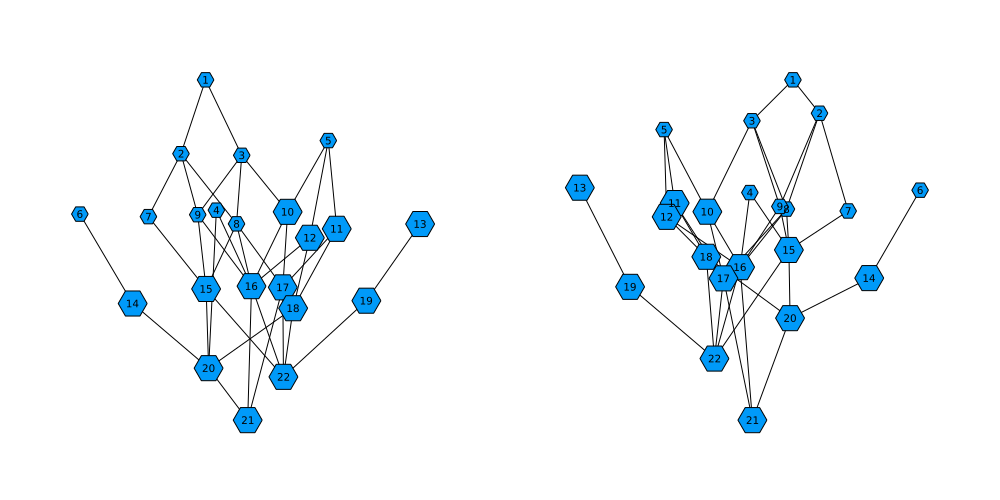

In [23]:
plot(datatograph1(DW5s,3)[1],datatograph2(DW5s,0.01)[1],size=(1000,500))

## Degenerations in the appendix

We can also check the degenerations in the appendix:

In [24]:

function P_A1toA2(typ,k1,k2,k3,t)
    n=k1+2k2+3k3
    n1,n2,n3=k1+k2+k3,k2+k3,k3
    P=zeros(n,n)
    if typ==1
        r,l1,l2=k3,k1,k2+k3
        P[1:k2+k3,r+1:r+2l2]=kron(Diagonal(ones(l2)),[1 t^2])
        P[1+l2:k1+k2+k3,r+2l2+1:n]=t*Diagonal(ones(l1))
        P[1+k1+k2+k3:k1+2k2+2k3,r+1:r+2l2]=kron(Diagonal(ones(l2)),[1 0])
        P[1+k1+2k2+2k3:n,1:r]=Diagonal(ones(r))
    elseif typ==2
        r,l1,l2=k2+k3,k1+k2,k3
        P[1:l2,r+1:r+2l2]=kron(Diagonal(ones(l2)),[1 t^2])
        P[l2+1:l2+l1,r+2l2+1:r+2l2+l1]=t*Diagonal(ones(l1))
        P[k1+k2+k3+1:k1+k2+k3+r,1:r]=Diagonal(ones(r))
        P[k1+2k2+2k3+1:k1+2k2+2k3+l2,r+1:r+2l2]=kron(Diagonal(ones(l2)),[1 0])
    else
        r,l1,l2=k1+k2+k3,k2,k3
        P[1:r,1:r]=Diagonal(ones(r))
        P[k1+k2+k3+1:k1+k2+k3+l2,r+1:r+2l2]=kron(Diagonal(ones(l2)),[1 t^2])
        P[1+k1+k2+k3+l2:k1+k2+k3+l2+l1,r+2l2+1:n]=t*Diagonal(ones(l1))
        P[k1+2k2+2k3+1:k1+2k2+2k3+l2,r+1:r+2l2]=kron(Diagonal(ones(l2)),[1 0])
    end
    return P'
end

function P_A2toA2(r,k1,k2,t)
    n=r+k1+2k2
    P=im*zeros(n,n)
    P[1:r,1:r]=Diagonal(ones(r))
    P[r+1:r+2k2-2,r+1:r+2k2-2]=kron(Diagonal(ones(k2-1)),[1 0; 0 t^2])
    P[r+2k2-1:r+2k2,r+2k2-1:r+2k2]=[t im*t; t/2 -im*t/2]
    P[r+2k2+1:n,r+2k2+1:n]=t*Diagonal(ones(k1))
    return P'
end

function P_A2toA3(typ,r,k1,k2,t)
    n=r+k1+2k2
    P=im*zeros(n,n)
    if typ==1
        l1,l2,l3=k1,k2-r,r
        P[1:l3,1:3l3]=kron(Diagonal(ones(l3)),[1 0 0])
        P[1+l3:3l3,1:3l3]=kron(Diagonal(ones(l3)),[1 t^2 0; 0 1 t^2])
        P[1+3l3:3l3+2l2,3l3+1:2l2+3l3]=kron(Diagonal(ones(l2)),[t 0; 1/(2t) t])
        P[3l3+2l2+1:n,3l3+2l2+1:n]=t*Diagonal(ones(l1))
    elseif typ==2
        l1,l2,l3=k1+k2-r,r-k2,k2
        P[1:l3,1:3l3]=kron(Diagonal(ones(l3)),[1 -t^2 0])
        P[1+l3:r,1+3l3:3l3+2l2]=kron(Diagonal(ones(l2)),[im*t 0])
        P[1+r:r+2k2,1:3l3]=kron(Diagonal(ones(l3)),[1 0 0; 0 1 t^2])
        P[1+r+2k2:r+2k2+2l2,1+3l3:3l3+2l2]=kron(Diagonal(ones(l2)),[1 t^2])
        P[1+r+2k2+2l2:n,1+3l3+2l2:n]=t*Diagonal(ones(l1))
    else
        l1,l2,l3=r-k1-k2,k1,k2
        P[1:l3,1:3l3]=kron(Diagonal(ones(l3)),[1 t^2 t^4])
        P[1+l3:l3+l2,1+3l3:3l3+2l2]=kron(Diagonal(ones(l2)),[t t^3])
        P[1+l2+l3:r,1+3l3+2l2:n]=t^2*Diagonal(ones(l1))
        P[1+r:r+2k2,1:3l3]=kron(Diagonal(ones(l3)),[1 0 0; 0 1 0])
        P[1+r+2k2:n,1+3l3:3l3+2l2]=kron(Diagonal(ones(l2)),[1 0 ])
    end
    return P'
end

function P_A3toA3(typ,k1,k2,k3,t)
    n=k1+2k2+3k3
    P=im*zeros(n,n)
    if typ==1
        l1,l2,l3=k1+1,k2+1,k3-1
        P[1:3l3,1:3l3]=Diagonal(ones(3l3))
        P[1+3k3:2k2+3k3,1+3l3:3l3+2k2]=Diagonal(ones(2k2))
        P[1+2k2+3k3:k1+2k2+3k3,1+2l2+3l3:k1+3l3+2l2]=Diagonal(ones(k1))
        
        P[1+3l3:3k3,[3l3+2l2-1,3l3+2l2,n]]=[t 0 0; 1/(2t) 0 1; -1/(8t^3) 1/t  -1/(2t^2)]
    elseif typ==2
        l1,l2,l3=k1+2,k2-1,k3
        P[1:3k3+2l2,1:3l3+2l2]=Diagonal(ones(3l3+2l2))
        P[3k3+2l2+1:3k3+2k2,n-1:n]=[t +im*t; 1/(2t) -im/(2t)]
        P[3k3+2k2+1:n,3l3+2l2+1:3l3+2l2+k1]=Diagonal(ones(k1))
    else 
        l1,l2,l3=k1-1,k2+2,k3-1
        P[1:3l3,1:3l3]=Diagonal(ones(3l3))
        P[1+3k3:3k3+2k2,1+3l3:2k2+3l3]=Diagonal(ones(2k2))
        P[1+2k2+3k3:l1+2k2+3k3,1+2l2+3l3:n]=Diagonal(ones(l1))
        P[3k3-2:3k3,3l3+2l2-3:3l3+2l2]=[t 0 t*im 0; 1/(2t) 0 -im/(2t) 0; 0 1/(2t) 0 -im/(2t)]
        P[n,3l3+2l2-3:3l3+2l2]=im*[1/(2t) -t -im/(2t) -t*im]
    end
    return P'
end

function QMatrix(n)
    m=1
    odd=true
    if n %2 ==0
        m=Int(n/2) 
        odd=false
    else
        m=Int((n-1)/2)
    end
    Q=im*zeros(n,n)
    Q[1:m,1:m]=Diagonal(ones(m))
    Q[n-m+1:n,n-m+1:n]=-im*Diagonal(ones(m))
    Q[1:m,n-m+1:n]=JMatrix(m)
    Q[n-m+1:n,1:m]=im*JMatrix(m)
    if odd
        Q[m+1,m+1]=sqrt(2)
    end
    return Q/sqrt(2)
end

function P_B1toB2(k,m,t)
    n=m*2
    P=im*zeros(n,n)
    P[1:m,1:m]=QMatrix(m)*JMatrix(m)
    P[m+1:n,m+1:n]=QMatrix(m)
    P2=Diagonal(ones(n))
    P2[k+1:m,k+1:m]*=t
    P2[m-k+1:m,m-k+1:m]*=t
    return P2*P'
end

function P_B2toB2(k,l1,l2,t)
    n=l1+2l2
    P=Matrix(Diagonal(ones(n)))
    P[k:l2,k:l2]*=t
    P[l2-k+2:l2,l2-k+2:l2]*=t    
    return P
end


PA3a(t)=[1 0 0 0 1/t; 0 1 0 0 0; 0 0 0 1 0; 0 0 1 0 0; 0 0 0 0 t]
PA3b(t)=[1 0 0 0 0; 0 1 0 0 im; 0 0 0 t 0; 0 0 0 0 -im*t^2; 0 0 t^2 0 0]
PA3c(t)=[1 0 0 0 0; 0 0 0 1 0; 0 t 0 0 0; 0 0 0 0 t^2; 0 0 t^2 0 0]
PA3d(t)=[1 0 1 0 0; 0 1 0 1 0; 0 0 0 0 t; -t^2 0 0 0 0; 0 -t^2 0 0 0]
PA3e(t)=[1 1 0 0 0; 0 t^2 0 0 0; 0 0 t 0 0; 0 0 0 1 -1; 0 0 0 0 t^2]


PA4a(t)=[0 0 1 0 0 0; 0 1 0 0 0 0; 1 0 0 0 0 0; 0 0 1 t 0 0; 0 1 0 0 t 0; im 0 0 0 0 -im*t]'
PA4b(t)=[1 0 0 0 0 0; 0 1 0 0 0 0; 0 0 0 0 1 0; 1/t 0 0 0 0 t; 0 0 im/t 0 0 0; 0 0 1/t t 0 0]'
PA4c(t)=[0 0 1 0 0 0; 0 1 0 0 0 0; 0 0 0 0 1 0; 1 0 0 0 0 0; 0 0 0 0 0 1; 0 0 1/t t 0 0]'
PA4d(t)=[1 0 0 0 0 0; 0 1 0 0 0 0; 0 0 1 0 0 0; 0 0 0 1 0 0; 0 1/t 0 0 t 0; 1/t 0 0 0 0 t]'
PA4e(t)=[1 1 0 0 t t; im -im 0 0 t*im -t*im; 1 0 0 0 0 0; 0 1 0 0 0 0; 0 0 1 0 0 0; 0 0 0 -t 0 0]'

PA4f(t)=[1 0 0 0 0 0; 0 1 0 0 0 0; 0 0 1 0 0 0; 0 0 0 t 0 0; 1 1 0 0 t/2 t/2; im -im 0 0 t*im/2 -t*im/2]'
PA4g(t)=[1 im 0 0 0 0; 0 0 1 t 0 0; 0 0 0 0 -t*im/2 t/2; 1 -im 0 0 0 0; 0 0 1 0 0 0; 0 0 0 0 -t*im/2 -t/2]'
PA4h(t)=[1 0 0 0 0 0; 0 1 0 0 0 0; 0 0 0 0 0 t^2; 0 im 0 0 -t^2*im 0; 0 0 t/sqrt(2) t/sqrt(2) 0 0; 0 0 -t*im/sqrt(2) t*im/sqrt(2) 0 0]'
PA4i(t)=[1 0 0 0 0 0; 0 1 0 0 0 0; 0 0 0 0 0 t; 0 0 1 0 0 0; 0 0 0 t 0 0; 0 im 0 0 -im*t 0]'
PA4j(t)=[0 1 0 0 0 0; 0 t -2*im t^2*im/2 0 0; 0 -t^2/2 2t*im 0 t^2 -t*im; t im 0 0 0 0; 0 0 2 0 0 0; 0 0 0 0 0 t]'

PA4k(t)=[1 t 0 0 0 0; 1 0 0 0 0 0; 0 0 1 0 0 0; 0 0 0 t 0 0; 0 0 0 0 -1 t; 0 0 0 0 1 0]'
PA4l(t)=[1 0 0 0 0 0; 0 1 0 0 0 0; im t*im t^2*im 0 0 0; 0 0 0 -im 0 0; 0 0 0 -t t^2 0; 0 0 0 -1 0 t^2]'
PA4m(t)=[t -im*t 0 0 0 0; 1 im 0 0 0 0; 0 0 1 0 0 0; 0 0 0 t^2 0 0; 0 0 0 0 -im*t^2/2 t^2/2; 0 0 0 0 t*im/2 t/2]'
PA4n(t)=[1 0 0 0 0 0; 1 0 t 0 0 0; 0 t^2 -t/2 0 0 0; 0 0 0 0 1 0; 0 0 0 t 1/2 0; 0 0 0 -t -1/2 t^2]'
PA4o(t)=[1 0 0 0 0 0; 0 t 0 0 0 0; 0 0 1 0 0 0; 0 0 0 t 0 0; 0 0 0 0 1 0; 0 0 0 0 0 t]'

PA4p(t)=[1 t^2 0 0 0 0; 0 0 t 0 0 0; 1 0 0 0 0 0; 0 0 0 0 -1 t^2; 0 0 0 t 0 0; 0 0 0 0 1 0]'
PA4q(t)=[t 0 0 0 0 0; 0 0 1 0 0 0; 0 1 0 0 0 0; 0 0 0 0 t 0; 0 0 0 t 0 0; 0 0 0 0 0 1]'
PA4r(t)=[1 0 0 0 0 0; 1 0 t 0 0 0; 0 1 0 0 0 0; 0 0 0 0 t 0; 0 0 0 1 0 0; 0 0 0 -1 0 t]'
PA4s(t)=[1 0 0 0 0 0; 1 t 0 0 0 0; 0 0 1 0 0 0; 0 0 0 t 0 0; 0 0 0 0 1 0; 0 0 0 0 -1 t]'

PA5a(t)=[1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 1 t]'
PA5b(t)=[1 0 0 0; 1 t 0 0; 0 0 1 0; 0 0 0 1]'
PA5c(t)=[1 0 0 0; 0 1 t t^2; 0 1 0 0; 0 0 1 0]'
PA5d(t)=[1 0 0 0; 0 1 0 0; 1 t t^2 0; 0 1 2t t^2]'

PA5e(t)=[1 t t^2 t^3; 1 0 0 0; 0 1 0 0; 0 0 1 0]'
PA5f(t)=[1 0 0 0; 0 t 0 im*t; 0 1 0 -im; 0 0 2t 0]'
PA5g(t)=[1 0 0 0; 0 1 0 0; 0 0 t 0; 0 0 0 t]'
PA5h(t)=[1 0 t^2 0; 0 0 0 t; 1 0 0 0; 0 1 0 0]'

PA5i(t)=[1 0 0 0; 0 0 -t 0; 0 1 0 0; 0 0 0 t]'
PA5j(t)=[1 0 0 0; 0 1 0 0; 0 0 0 t; 0 1 t 0]'
PA5k(t)=[1 0 0 0; 0 0 im 0; 0 1 0 0; 0 0 1 t]'
PA5l(t)=[1 0 0 0; 0 1 0 im; 1 t 0 -t*im; 0 1 2t im]';

As example we verify the degeneration from $B_3^{(1)}$ to $B_{1,0,3}^{(2)}$.

In [25]:
X=JNB1(3)
Y=JNB2(1,0,3)


for t in[0.5,0.1,0.01,0.001,0.0005]

    println(F(P_B1toB2(1,3,t),X,Y)[1])

end

0.4761904761904764
0.019998019998020013
0.00019999999800020008
1.9999999999980013e-6
4.99999999999977e-7
